# CSEDM 2021

## Preliminaries

### Import Packages

In [1]:
import sys
sys.path.append('..')
from utilities import * 

### Constants

In [2]:
# paths
PATH_TO_INTERACTION_DATA = '../../../../../../data/ddia/CSEDM_2021_F19_Release_All_05_23_22/All/Data/MainTable.csv'
PATH_TO_COURSE_EVALUATION_DATA = '../../../../../../data/ddia/CSEDM_2021_F19_Release_All_05_23_22/All/Data/LinkTables/Subject.csv'

# dataset name
DATASET_NAME = 'csedm_2021'

# fields used in the analysis
USER_FIELD = 'SubjectID'
GROUP_FIELD = 'AssignmentID'
LEARNING_ACTIVITY_FIELD = 'ProblemID'
COURSE_FIELD = 'Course'
TIMESTAMP_FIELD = 'ServerTimestamp'
ORDER_FIELD = 'Order'

# fields used in dataset preparation
EVENT_TYPE_FIELD = 'EventType'

# strings and values used in dataset preparation
EVENT_TYPE_RUN_PROGRAM_VALUE_STR = 'Run.Program'
EVENT_TYPE_COMPILE_VALUE_STR = 'Compile'
EVENT_TYPE_COMPILE_ERROR_VALUE_STR = 'Compile.Error'

# evaluation fields
# learning activity level
EVALUATION_LEARNING_ACTIVITY_SCORE_FIELD = 'Score'
EVALUATION_LEARNING_ACTIVITY_IS_CORRECT_FIELD = None
# group level
EVALUATION_GROUP_SCORE_FIELD = None
EVALUATION_GROUP_IS_CORRECT_FIELD = None 
# course level
EVALUATION_COURSE_SCORE_FIELD = 'X-Grade'
EVALUATION_COURSE_IS_CORRECT_FIELD = None 

# score threshold is correct
EVALUATION_LEARNING_ACTIVITY_SCORE_CORRECT_THRESHOLD = 1
EVALUATION_GROUP_SCORE_CORRECT_THRESHOLD = None
EVALUATION_COURSE_SCORE_CORRECT_THRESHOLD = None

# evaluation min and max in dataset docu
EVALUATION_LEARNING_ACTIVITY_SCORE_MINIMUM_IN_DATASET_DOCU = None
EVALUATION_LEARNING_ACTIVITY_SCORE_MAXIMUM_IN_DATASET_DOCU = None
EVALUATION_GROUP_SCORE_MINIMUM_IN_DATASET_DOCU = None
EVALUATION_GROUP_SCORE_MAXIMUM_IN_DATASET_DOCU = None
EVALUATION_COURSE_SCORE_MINIMUM_IN_DATASET_DOCU = None
EVALUATION_COURSE_SCORE_MAXIMUM_IN_DATASET_DOCU = None

# used for generating html tables
HTML_TABLES_DATA_LIST = [[LEARNING_ACTIVITY_FIELD, EVALUATION_LEARNING_ACTIVITY_SCORE_FIELD, EVALUATION_LEARNING_ACTIVITY_IS_CORRECT_FIELD, EVALUATION_LEARNING_ACTIVITY_SCORE_CORRECT_THRESHOLD, EVALUATION_LEARNING_ACTIVITY_SCORE_MINIMUM_IN_DATASET_DOCU, EVALUATION_LEARNING_ACTIVITY_SCORE_MAXIMUM_IN_DATASET_DOCU], 
                         [GROUP_FIELD, EVALUATION_GROUP_SCORE_FIELD, EVALUATION_GROUP_IS_CORRECT_FIELD, EVALUATION_GROUP_SCORE_CORRECT_THRESHOLD, EVALUATION_GROUP_SCORE_MINIMUM_IN_DATASET_DOCU, EVALUATION_GROUP_SCORE_MAXIMUM_IN_DATASET_DOCU], 
                         [COURSE_FIELD, EVALUATION_COURSE_SCORE_FIELD, EVALUATION_COURSE_IS_CORRECT_FIELD, EVALUATION_COURSE_SCORE_CORRECT_THRESHOLD, EVALUATION_COURSE_SCORE_MINIMUM_IN_DATASET_DOCU, EVALUATION_COURSE_SCORE_MAXIMUM_IN_DATASET_DOCU]]

### Import Pickled Objects

In [3]:
# seq_distances = pickle_read(PATH_TO_SEQUENCE_DISTANCES_PICKLE_FOLDER,
#                             DATASET_NAME + SEQUENCE_DISTANCE_DICT_PER_GROUP_PICKLE_NAME)

# learning_activity_sequence_stats_per_group = pickle_read(PATH_TO_SEQUENCE_STATISTICS_PICKLE_FOLDER,
#                                                          DATASET_NAME + SEQUENCE_STATISTICS_TABLES_PICKLE_NAME)

# html_table = pickle_read(PATH_TO_HTML_TABLES_PICKLE_FOLDER,
#                          DATASET_NAME + HTML_TABLES_PICKLE_NAME)

# cluster_eval = pickle_read(PATH_TO_SEQUENCE_CLUSTER_EVALUATION_METRIC_ANALYSIS_PICKLE_FOLDER,
#                            DATASET_NAME + SEQUENCE_CLUSTER_EVALUATION_METRIC_ANALYSIS_PER_GROUP_OBJECT_PICKLE_NAME)

### Functions

In [4]:
def calculate_eval_metrics(df: pd.DataFrame,
                           evaluation_score_field=None,
                           evaluation_score_correct_threshold=None,
                           event_type_field=None,
                           event_type_run_program_value_str=None,
                           server_timestamp_field=None):
    """Calculate evaluation metrics per single learning_activity. This function should be used as input of the
    add_evaluation_fields function.

    Parameters
    ----------
    df : pd.DataFrame
        A subset of the interactions dataframe containing data of a single learning_activity
    evaluation_score_field : _type_
        The learning_activity evaluation score field column, by default None
    evaluation_score_correct_threshold : _type_
        The threshold for the learning_activity score values to be evaluated as correct, by default None
    event_type_field : _type_, optional
        The event_type field column, by default None
    event_type_run_program_value_str : _type_
        The run_program value of the event_type field, by default None
    server_timestamp_field : _type_
        The server_timestamp_field field, by default None

    Returns
    -------
    tuple
        A tuple of evaluation metric scalars per learning activity
    """
    df = df.copy()

    # generate corrects from score
    evaluation_correct_field = 'correct'
    df[evaluation_correct_field] = df[evaluation_score_field].apply(lambda x: int(x) if pd.notna(x) else x) >= evaluation_score_correct_threshold

    # number interactions (Run.Program)
    number_interactions_total = sum(df[event_type_field]==event_type_run_program_value_str)

    # number attempts
    number_attempts_total = sum(df[event_type_field]==event_type_run_program_value_str)

    # number hints
    number_hints_total = None

    # total time
    # (timedelta between first and last run_program interaction, can be 0 for only 1 attempt)
    run_program_df = df.loc[df[event_type_field]==event_type_run_program_value_str, :]
    time_total = round((run_program_df[server_timestamp_field].iloc[-1] - run_program_df[server_timestamp_field].iloc[0]).total_seconds())
        
    # scores
    # single score
    single_score = None
    # single score hint lowest 
    single_score_hint_lowest = None 
    # single score not first attempt lowest
    single_score_not_first_attempt_lowest = None
    # highest score
    score_highest = df[evaluation_score_field].max()
    # highest score without hint
    score_highest_without_hint = None
    # score first attempt
    score_first_attempt = df[evaluation_score_field][df[event_type_field]==event_type_run_program_value_str].to_list()[0]
    # score last attempt
    score_last_attempt = df[evaluation_score_field][df[event_type_field]==event_type_run_program_value_str].to_list()[-1]
    # number interactions until highest score
    number_interactions_until_score_highest = np.argmax(df[evaluation_score_field][df[event_type_field]==event_type_run_program_value_str]) + 1
    # number attempts until highest score
    number_attempts_until_score_highest = np.argmax(df[evaluation_score_field][df[event_type_field]==event_type_run_program_value_str]) + 1
    # number hints until highest score
    number_hints_until_score_highest = None
    # time until highest score
    # (timedelta between first run_program interaction and highest score run_program interaction, can be 0 for only 1 attempt)
    index_highest_score = np.argmax(run_program_df[evaluation_score_field])
    time_until_score_highest = round((run_program_df[server_timestamp_field].iloc[index_highest_score] - run_program_df[server_timestamp_field].iloc[0]).total_seconds())

    # corrects
    # correct
    is_correct = df[evaluation_correct_field].any()
    # correct without hint
    is_correct_without_hint = None
    # correct first attempt
    try:
        is_correct_first_attempt = df[evaluation_correct_field][df[event_type_field]==event_type_run_program_value_str].to_list()[0]
    except:
        is_correct_first_attempt = False
    # correct first attempt without hint
    is_correct_first_attempt_without_hint = None
    # correct last attempt
    try:
        is_correct_last_attempt = df[evaluation_correct_field][df[event_type_field]==event_type_run_program_value_str].to_list()[-1]
    except:
        is_correct_last_attempt = False
    # correct last attempt without hint
    is_correct_last_attempt_without_hint = None
    # number interactions until correct
    if is_correct:
        number_interactions_until_correct = np.argmax(df[evaluation_correct_field][df[event_type_field]==event_type_run_program_value_str]) + 1
    else:
        number_interactions_until_correct = -1 # -1 means that there was no correct -> therefore also no interactions until correct
    # number attempts until correct
    if is_correct:
        number_attempts_until_correct = np.argmax(df[evaluation_correct_field][df[event_type_field]==event_type_run_program_value_str]) + 1
    else:
        number_attempts_until_correct = -1 # -1 means that there was no correct -> therefore also no attempts until correct
    # number hints until correct
    number_hints_until_correct = None
    # time until correct
    # (timedelta between first run_program interaction and first is_correct run_program interaction, can be 0 for only 1 attempt)
    if is_correct:
        index_is_correct = np.argmax(run_program_df[evaluation_correct_field])
        time_until_correct = round((run_program_df[server_timestamp_field].iloc[index_is_correct] - run_program_df[server_timestamp_field].iloc[0]).total_seconds())
    else:
        time_until_correct = -1 # -1 means that there was no correct -> therefore also no attempts until correct

    return (number_interactions_total,
            number_attempts_total,
            number_hints_total,
            time_total,
            single_score,
            single_score_hint_lowest,
            single_score_not_first_attempt_lowest,
            score_highest,
            score_highest_without_hint,
            score_first_attempt,
            score_last_attempt,
            number_interactions_until_score_highest,
            number_attempts_until_score_highest,
            number_hints_until_score_highest,
            time_until_score_highest,
            is_correct,
            is_correct_without_hint,
            is_correct_first_attempt,
            is_correct_first_attempt_without_hint,
            is_correct_last_attempt,
            is_correct_last_attempt_without_hint,
            number_interactions_until_correct,
            number_attempts_until_correct,
            number_hints_until_correct,
            time_until_correct)

## Dataset Preparation

### Import Data

In [5]:
interactions = pd.read_csv(PATH_TO_INTERACTION_DATA)
course_grade = pd.read_csv(PATH_TO_COURSE_EVALUATION_DATA)

### Set Data Type

In [6]:
interactions = typecast_fields(interactions,
                               TIMESTAMP_FIELD,
                               GROUP_FIELD,
                               USER_FIELD,
                               LEARNING_ACTIVITY_FIELD)

### Merge and Filter Data

In [7]:
interactions = interactions.merge(course_grade, how="left", on=USER_FIELD)

### Transform Categorical Variable Values

In [8]:
interactions, value_mapping_df = map_new_to_old_values(interactions, 
                                                       GROUP_FIELD, 
                                                       USER_FIELD, 
                                                       LEARNING_ACTIVITY_FIELD)

### Filter Sequences by NAs in Dataset 

In [9]:
pct_na = get_nas_in_data(interactions)

SubjectID                                  0.0 %
ToolInstances                              0.0 %
ServerTimestamp                            0.0 %
ServerTimezone                             0.0 %
CourseID                                   0.0 %
AssignmentID                               0.0 %
ProblemID                                  0.0 %
CodeStateID                                0.0 %
IsEventOrderingConsistent                  0.0 %
EventType                                  0.0 %
Score                         65.1342676913509 %
Compile.Result                65.1342676913509 %
CompileMessageType           69.73146461729822 %
CompileMessageData           69.73146461729822 %
EventID                                    0.0 %
Order                                      0.0 %
ParentEventID                34.86573230864911 %
X-Grade                                    0.0 %
dtype: object

In [10]:
interactions, na_indices_list = drop_learning_activity_sequence_if_contains_na_in_field(interactions, 
                                                                                        GROUP_FIELD, 
                                                                                        USER_FIELD, 
                                                                                        field_list=[TIMESTAMP_FIELD, 
                                                                                                    ORDER_FIELD, 
                                                                                                    EVALUATION_LEARNING_ACTIVITY_SCORE_FIELD, 
                                                                                                    EVALUATION_COURSE_SCORE_FIELD], 
                                                                                        field_value_tuple_filter_list=[(EVENT_TYPE_FIELD, EVENT_TYPE_COMPILE_VALUE_STR), 
                                                                                                                        (EVENT_TYPE_FIELD, EVENT_TYPE_COMPILE_ERROR_VALUE_STR)])



Input length: 360176
Outpunt length: 360176
Number of rows removed: 0
Percentage of rows removed: 0.0%
--------------------------------------------------
Input number of sequences: 2454
Output number of sequences: 2454
Number of sequences removed: 0
Percentage of sequences removed: 0.0%


In [11]:
interactions = drop_na_by_fields(interactions,
                                 field_list=[GROUP_FIELD,
                                             USER_FIELD])

Input length: 360176
Outpunt length: 360176
Number of rows removed: 0
Percentage of rows removed: 0%


In [12]:
pct_na = get_nas_in_data(interactions)

SubjectID                                  0.0 %
ToolInstances                              0.0 %
ServerTimestamp                            0.0 %
ServerTimezone                             0.0 %
CourseID                                   0.0 %
AssignmentID                               0.0 %
ProblemID                                  0.0 %
CodeStateID                                0.0 %
IsEventOrderingConsistent                  0.0 %
EventType                                  0.0 %
Score                         65.1342676913509 %
Compile.Result                65.1342676913509 %
CompileMessageType           69.73146461729822 %
CompileMessageData           69.73146461729822 %
EventID                                    0.0 %
Order                                      0.0 %
ParentEventID                34.86573230864911 %
X-Grade                                    0.0 %
dtype: object

### Sort by Timestamp

In [13]:
interactions = sort_by_timestamp(interactions,
                                 GROUP_FIELD,
                                 USER_FIELD,
                                 TIMESTAMP_FIELD,
                                 ORDER_FIELD)

### Evaluation Score Fields Ranges

Learning Resource Evaluation Score Range:

Number of Learning Resources: 50
Number of Unique Score Ranges: 1
Minima of Learning Resource Ranges are all equal: True
Maxima of Learning Resource Ranges are all equal: True
Minimum Learning Resource Score: 0.0
Maximum Learning Resource Score: 1.0


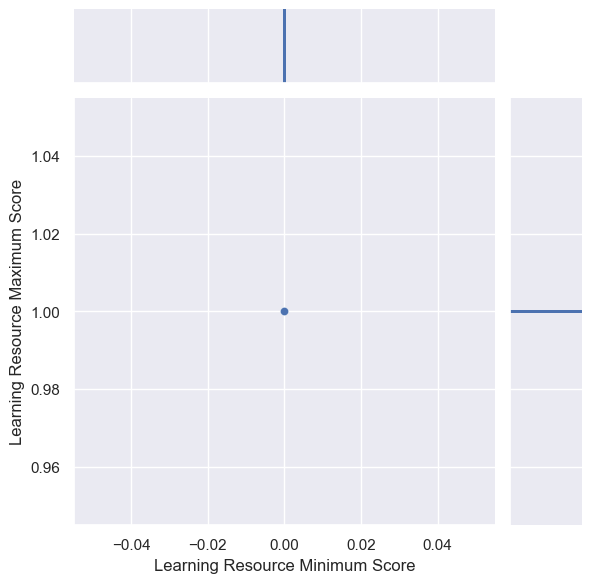

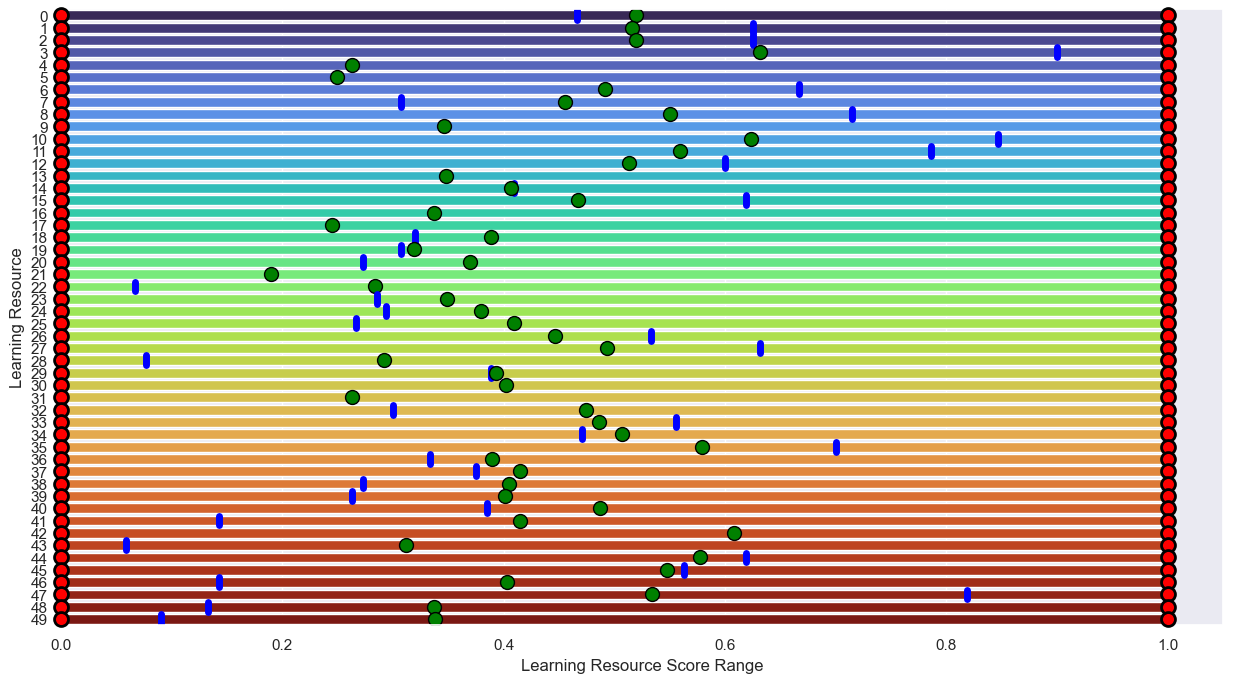

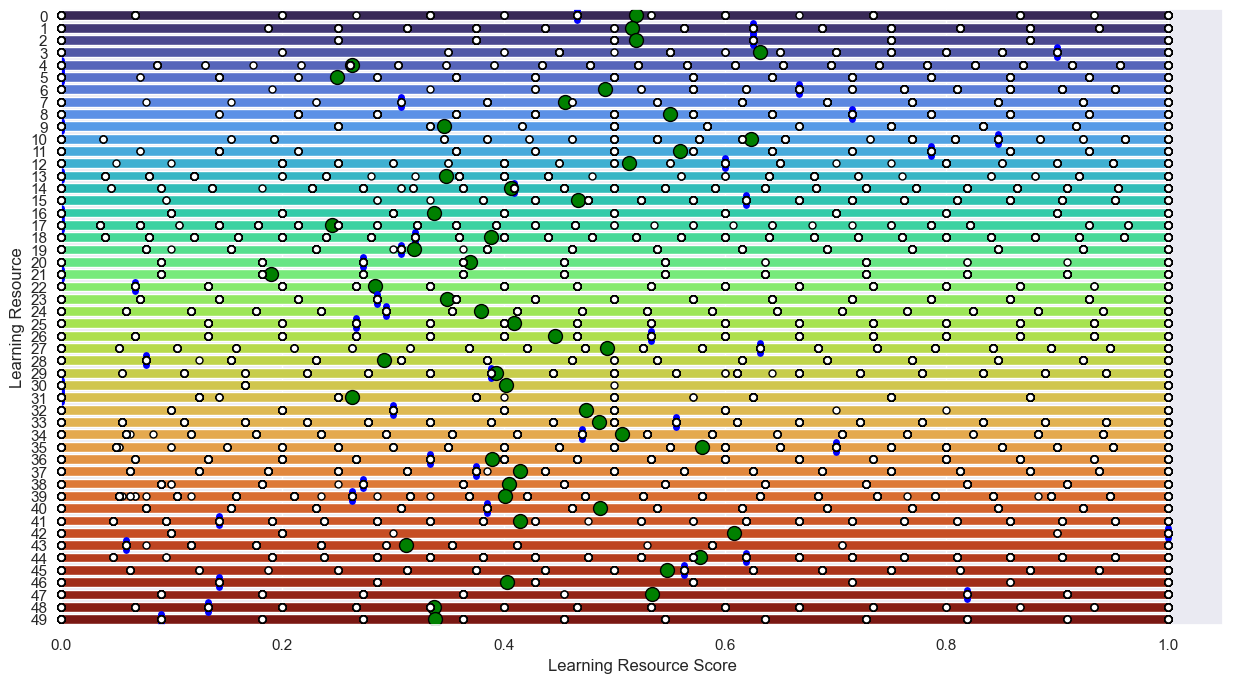

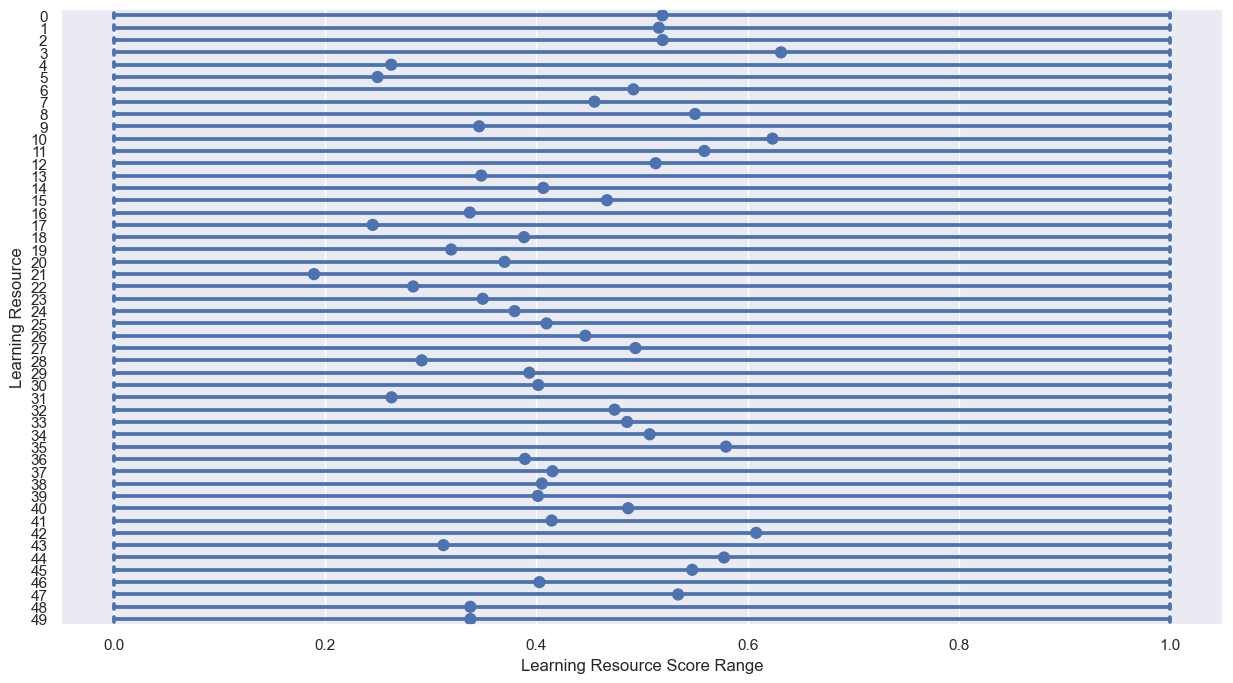

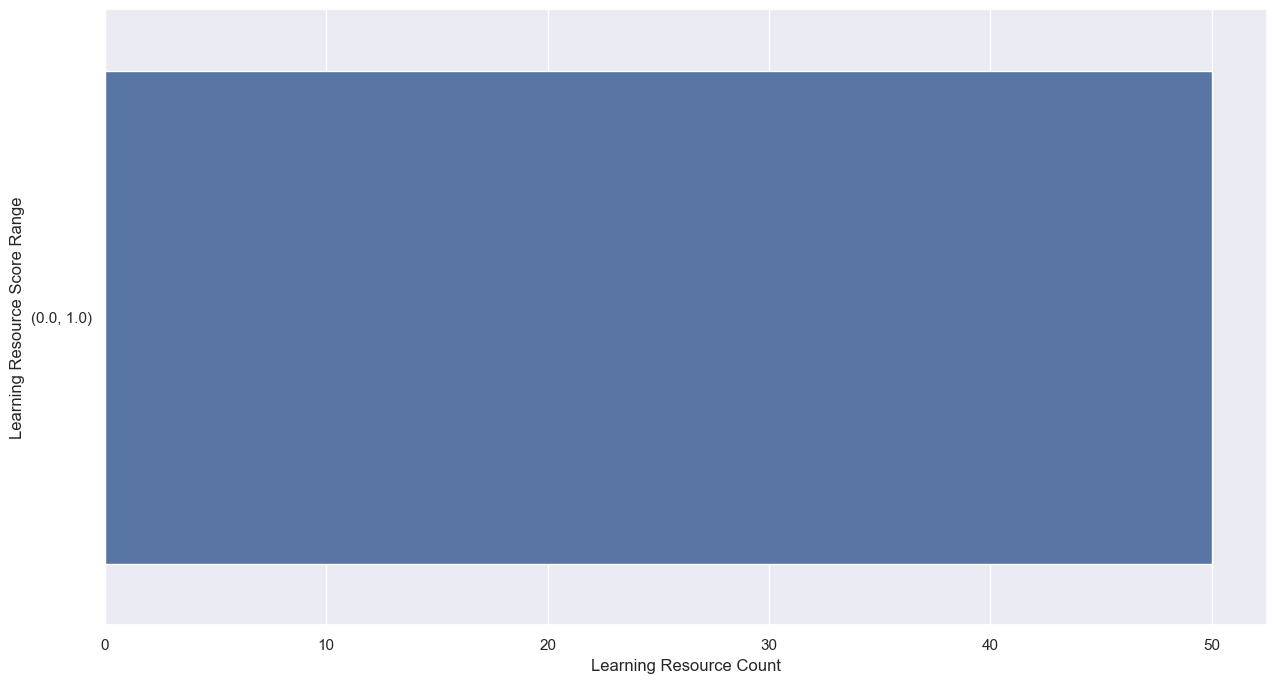

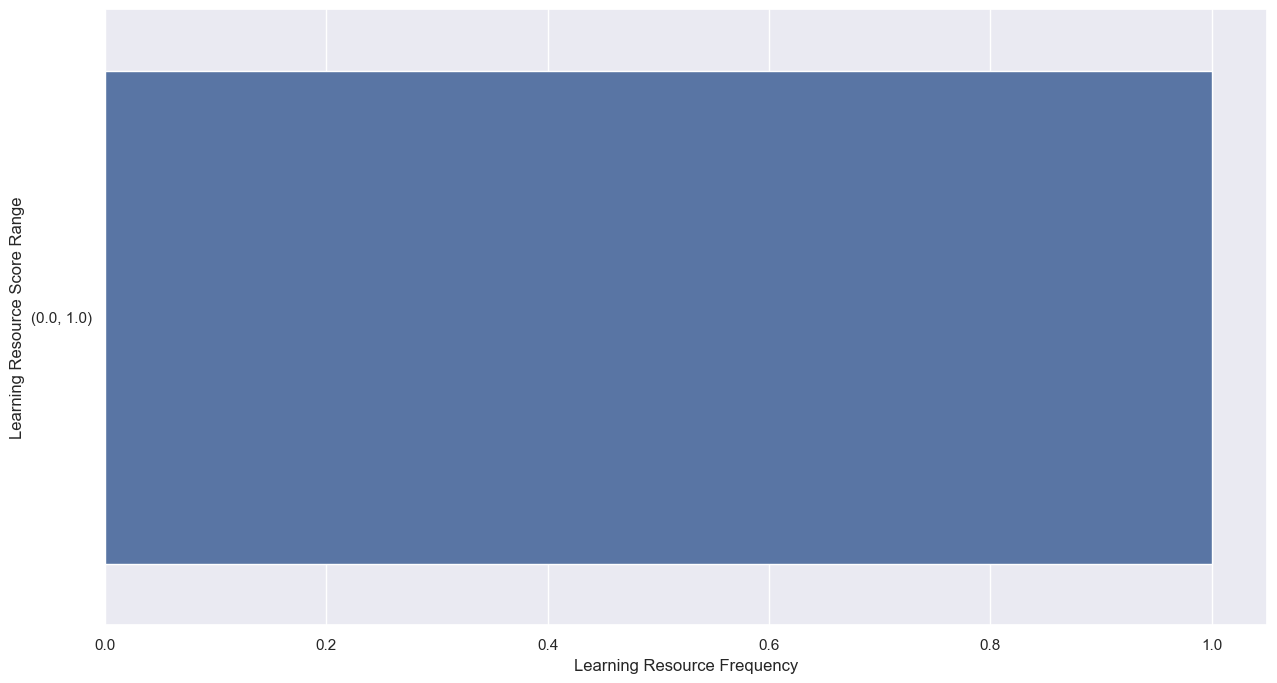

Course Evaluation Score Range:

Number of Courses: 1
Number of Unique Score Ranges: 1
Minima of Course Ranges are all equal: True
Maxima of Course Ranges are all equal: True
Minimum Course Score: 0.0
Maximum Course Score: 100.0


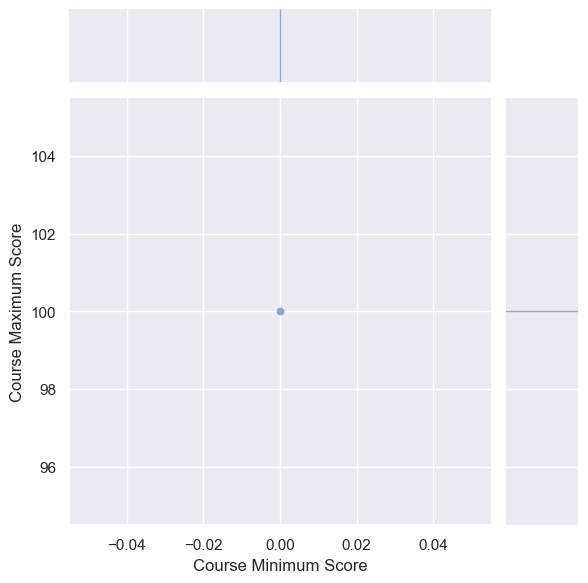

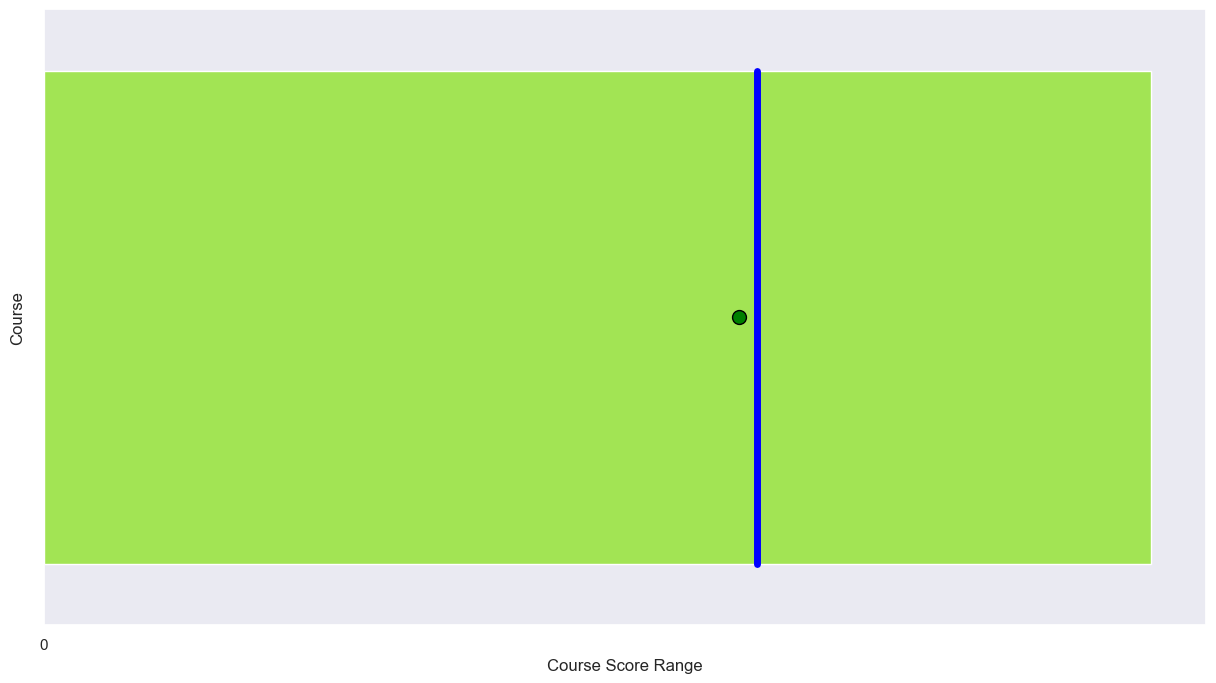

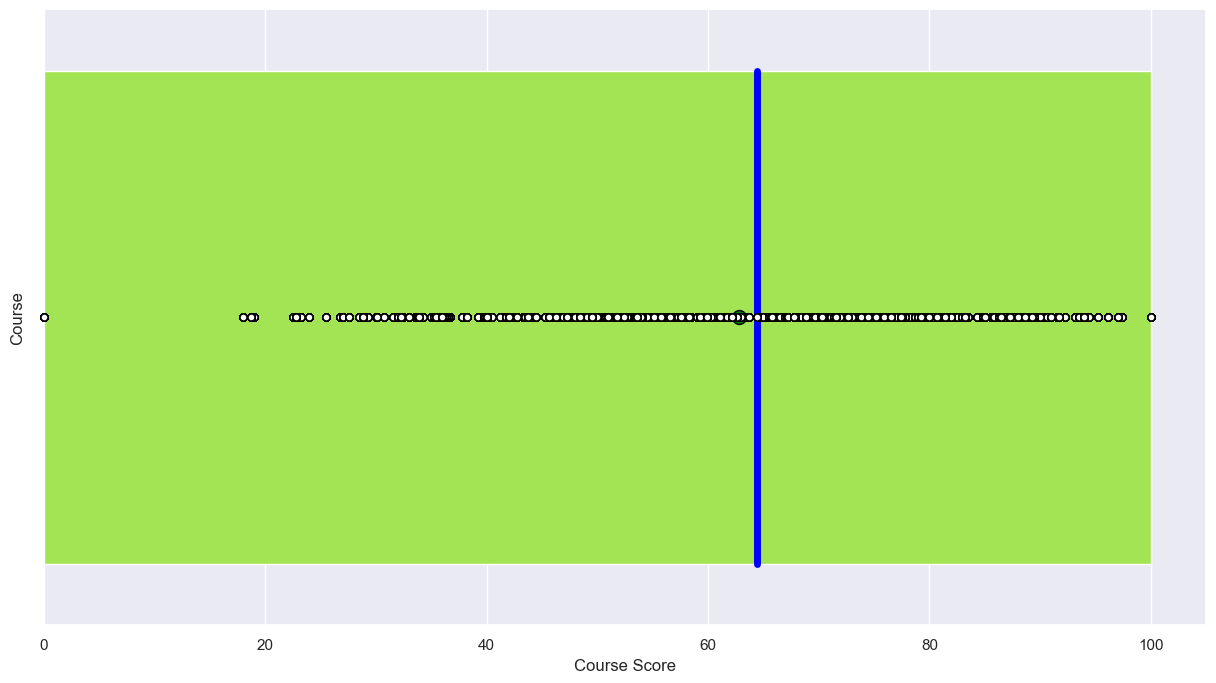

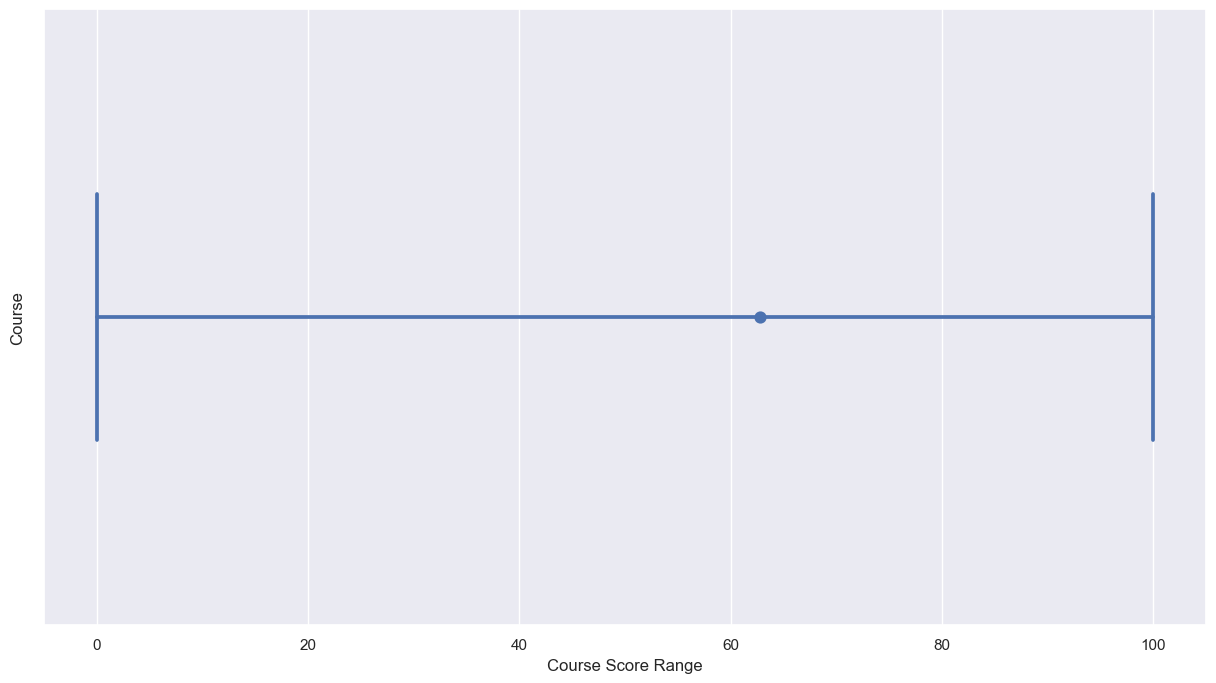

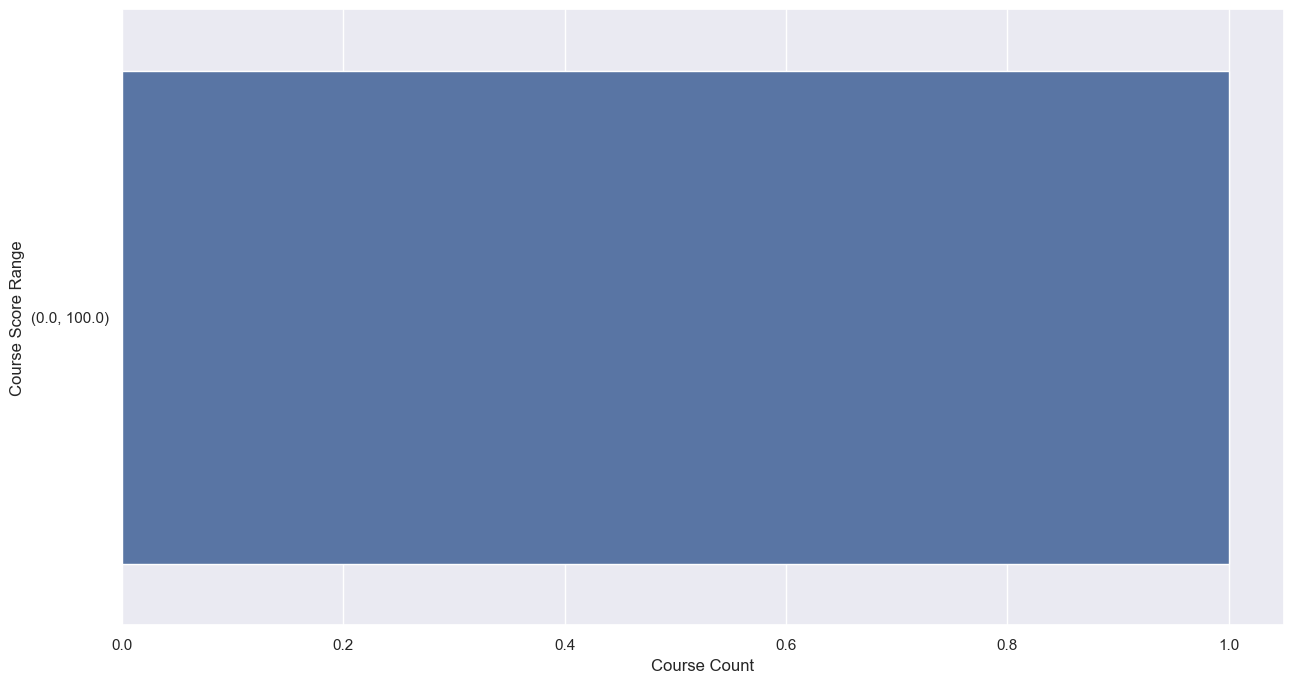

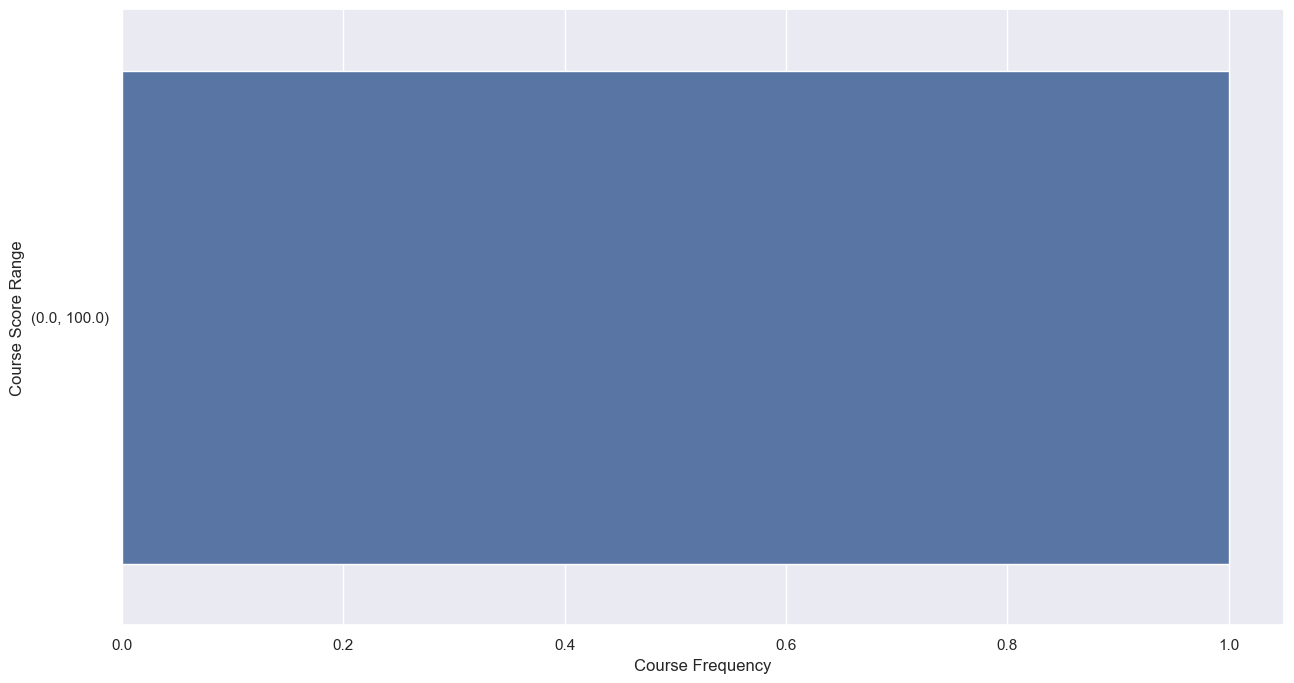

In [14]:
evaluation_score_range_dict = return_and_plot_evaluation_score_range(interactions,
                                                                     LEARNING_ACTIVITY_FIELD,
                                                                     EVALUATION_LEARNING_ACTIVITY_SCORE_FIELD,
                                                                     GROUP_FIELD,
                                                                     EVALUATION_GROUP_SCORE_FIELD,
                                                                     EVALUATION_COURSE_SCORE_FIELD)

### Transform Data

#### Add Evaluation Fields

In [15]:
interactions = add_evaluation_fields(interactions,
                                     GROUP_FIELD,
                                     USER_FIELD,
                                     LEARNING_ACTIVITY_FIELD,
                                     TIMESTAMP_FIELD,
                                     ORDER_FIELD,
                                     np.mean,
                                     EVALUATION_GROUP_SCORE_FIELD,
                                     EVALUATION_GROUP_IS_CORRECT_FIELD,
                                     EVALUATION_COURSE_SCORE_FIELD,
                                     EVALUATION_COURSE_IS_CORRECT_FIELD,
                                     False,
                                     False,
                                     EVALUATION_GROUP_SCORE_CORRECT_THRESHOLD,
                                     EVALUATION_COURSE_SCORE_CORRECT_THRESHOLD,
                                     operator.gt,
                                     operator.gt,
                                     calculate_eval_metrics,
                                     evaluation_score_field=EVALUATION_LEARNING_ACTIVITY_SCORE_FIELD,
                                     evaluation_score_correct_threshold=EVALUATION_LEARNING_ACTIVITY_SCORE_CORRECT_THRESHOLD,
                                     event_type_field=EVENT_TYPE_FIELD,
                                     event_type_run_program_value_str=EVENT_TYPE_RUN_PROGRAM_VALUE_STR,
                                     server_timestamp_field=TIMESTAMP_FIELD)

100%|██████████| 2454/2454 [00:00<00:00, 12472.19it/s]


= Repeated Interactions Removal =
Initial number of interactions: 360176
Final number of interactions: 27806
Removed number of interactions: 332370
Removed percentage of interactions: 92.2798853893652%


### Rename Fields

In [16]:
interactions, fields_mapping_df = rename_fields(interactions,
                                                GROUP_FIELD,
                                                USER_FIELD,
                                                LEARNING_ACTIVITY_FIELD,
                                                TIMESTAMP_FIELD)

### Add Sequence ID Field

In [17]:
interactions = add_sequence_id_field(interactions,
                                     GROUP_FIELD)

### Check Dataset

In [18]:
interactions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27806 entries, 0 to 27805
Data columns (total 86 columns):
 #   Column                                                                                   Non-Null Count  Dtype         
---  ------                                                                                   --------------  -----         
 0   Timestamp                                                                                27806 non-null  datetime64[ns]
 1   User                                                                                     27806 non-null  object        
 2   Topic                                                                                    27806 non-null  object        
 3   Learning Resource                                                                        27806 non-null  object        
 4   Sequence ID                                                                              27806 non-null  object        
 5   Learning Re

In [19]:
pct_na = get_nas_in_data(interactions)
pct_na

Timestamp                                                                                    0.0 %
User                                                                                         0.0 %
Topic                                                                                        0.0 %
Learning Resource                                                                            0.0 %
Sequence ID                                                                                  0.0 %
Learning Resource Interactions Total                                                         0.0 %
Learning Resource Attempts Total                                                             0.0 %
Learning Resource Hints Total                                                              100.0 %
Learning Resource Time in Seconds Total                                                      0.0 %
Learning Resource Single Score                                                             100.0 %
Learning R

### Create HtmlTables Dataset Info Object

In [20]:
html_table = HtmlTables(DATASET_NAME,
                        interactions, 
                        evaluation_score_range_dict, 
                        HTML_TABLES_DATA_LIST)

### Save the Dataset, Mapping Information and HtmlTables Object 

In [21]:
save_interaction_and_mapping_df(interactions,
                                fields_mapping_df,
                                value_mapping_df,
                                PATH_TO_CLEANED_DATASETS,
                                DATASET_NAME)

In [22]:
pickle_write(html_table,
             PATH_TO_HTML_TABLES_PICKLE_FOLDER,
             DATASET_NAME + HTML_TABLES_PICKLE_NAME)

## Dataset Characteristics

### Dataset Information

---
**Has GROUPING Field:** True

---
**Available Evaluation Metrics**  
Possible Values: 
>- True 
>- False
>- Derived (For 'Is Correct' fields)

Score Threshold to be correct:   
>    Learning Activity Is Correct Threshold:  
>    Group Is Correct Threshold:  
>    Course Is Correct Threshold:  

>**I. Learning Activity Level**:

- **Number of Interactions Total:**

- **Number of Attempts Total:**

- **Number of Hints Total:**

- **Score Highest:**

- **Score Highest without Hint:**

- **Score First Attempt:**

- **Score Last Attempt:**

- **Number of Interactions until Highest Score:**

- **Number of Attempts until Highest Score:**

- **Number of Hints until Highest Score:**

- **Is Correct:** Derived
        
- **Is Correct without Hint:**

- **Is Correct at First Attempt:**

- **Is Correct at First Attempt without Hint:**
        
- **Is Correct at Last Attempt :**

- **Is Correct at Last Attempt without Hint:**

- **Number of Interactions until Correct:**

- **Number of Attempts until Correct:**

- **Number of Hints until Correct:**


>**II. Group level**:

- **Group Score:**

- **Group Is Correct:**


>**III. Course level**:

- **Course Score:** True  
Final grades of course

- **Course Is Correct:** False

---
**Additional Information:**

- Learning Activity Is_Correct was derived from a Score of 1 on a learning activity(see Evaluation Score Fields Ranges)
- Field values of Time in Seconds Total, Time in Seconds until highest Score, Time in Seconds until Correct can be 0 if there is only one attempt(run_program interactions) at learning activity
- Field values of Time in Seconds Total, Time in Seconds until highest Score, Time in Seconds until Correct can be very large due to users continuously attempting to solve learning activity over large time periods(i.e., days)

### Available Fields

In [23]:
html_table.display_available_fields()

<table border="1" class="dataframe">
  <thead>
    <tr>
      <th style = "background-color: royalblue; color: white; text-align:center"> </th>
      <th style = "background-color: royalblue; color: white; text-align:center">Is Available</th>
    </tr>
    <tr>
      <th style = "background-color: royalblue; color: white; text-align:center">Field</th>
      <th style = "background-color: royalblue; color: white; text-align:center">csedm_2021</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Timestamp</td>
      <td style = "background-color: green; color: white; text-align:center">True</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">User</td>
      <td style = "background-color: green; color: white; text-align:center">True</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Topic</td>
      <td style = "background-color: green; color: white; text-align:center">True</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Learning Resource</td>
      <td style = "background-color: green; color: white; text-align:center">True</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Sequence ID</td>
      <td style = "background-color: green; color: white; text-align:center">True</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Learning Resource Interactions Total</td>
      <td style = "background-color: green; color: white; text-align:center">True</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Learning Resource Attempts Total</td>
      <td style = "background-color: green; color: white; text-align:center">True</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Learning Resource Hints Total</td>
      <td style = "background-color: red; color: white; text-align:center">False</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Learning Resource Time in Seconds Total</td>
      <td style = "background-color: green; color: white; text-align:center">True</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Learning Resource Single Score</td>
      <td style = "background-color: red; color: white; text-align:center">False</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Learning Resource Single Score (Hint Taken Equals Lowest Score)</td>
      <td style = "background-color: red; color: white; text-align:center">False</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Learning Resource Single Score (Not First Attempt Equals Lowest Score)</td>
      <td style = "background-color: red; color: white; text-align:center">False</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Learning Resource Highest Score</td>
      <td style = "background-color: green; color: white; text-align:center">True</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Learning Resource Highest Score Without Hint</td>
      <td style = "background-color: red; color: white; text-align:center">False</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Learning Resource First Attempt Score</td>
      <td style = "background-color: green; color: white; text-align:center">True</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Learning Resource Last Attempt Score</td>
      <td style = "background-color: green; color: white; text-align:center">True</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Learning Resource Interactions Until Highest Score</td>
      <td style = "background-color: green; color: white; text-align:center">True</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Learning Resource Attempts Until Highest Score</td>
      <td style = "background-color: green; color: white; text-align:center">True</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Learning Resource Hints Until Highest Score</td>
      <td style = "background-color: red; color: white; text-align:center">False</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Learning Resource Time in Seconds Until Highest Score</td>
      <td style = "background-color: green; color: white; text-align:center">True</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Learning Resource Is Correct</td>
      <td style = "background-color: green; color: white; text-align:center">True</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Learning Resource Is Correct Without Hints</td>
      <td style = "background-color: red; color: white; text-align:center">False</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Learning Resource First Attempt Is Correct</td>
      <td style = "background-color: green; color: white; text-align:center">True</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Learning Resource First Attempt Is Correct Without Hints</td>
      <td style = "background-color: red; color: white; text-align:center">False</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Learning Resource Last Attempt Is Correct</td>
      <td style = "background-color: green; color: white; text-align:center">True</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Learning Resource Last Attempt Is Correct Without Hints</td>
      <td style = "background-color: red; color: white; text-align:center">False</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Learning Resource Interactions Until Correct</td>
      <td style = "background-color: green; color: white; text-align:center">True</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Learning Resource Attempts Until Correct</td>
      <td style = "background-color: green; color: white; text-align:center">True</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Learning Resource Hints Until Correct</td>
      <td style = "background-color: red; color: white; text-align:center">False</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Learning Resource Time in Seconds Until Correct</td>
      <td style = "background-color: green; color: white; text-align:center">True</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Topic Score</td>
      <td style = "background-color: red; color: white; text-align:center">False</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Topic Is Correct</td>
      <td style = "background-color: red; color: white; text-align:center">False</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Topic Interactions Total All Learning Resources Mean</td>
      <td style = "background-color: green; color: white; text-align:center">True</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Topic Attempts Total All Learning Resources Mean</td>
      <td style = "background-color: green; color: white; text-align:center">True</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Topic Hints Total All Learning Resources Mean</td>
      <td style = "background-color: red; color: white; text-align:center">False</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Topic Time in Seconds Total All Learning Resources Mean</td>
      <td style = "background-color: green; color: white; text-align:center">True</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Topic Single Score All Learning Resources Mean</td>
      <td style = "background-color: red; color: white; text-align:center">False</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Topic Single Score (Hint Taken Equals Lowest Score) All Learning Resources Mean</td>
      <td style = "background-color: red; color: white; text-align:center">False</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Topic Single Score (Not First Attempt Equals Lowest Score) All Learning Resources Mean</td>
      <td style = "background-color: red; color: white; text-align:center">False</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Topic Highest Score All Learning Resources Mean</td>
      <td style = "background-color: green; color: white; text-align:center">True</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Topic Highest Score Without Hint All Learning Resources Mean</td>
      <td style = "background-color: red; color: white; text-align:center">False</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Topic First Attempt Score All Learning Resources Mean</td>
      <td style = "background-color: green; color: white; text-align:center">True</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Topic Last Attempt Score All Learning Resources Mean</td>
      <td style = "background-color: green; color: white; text-align:center">True</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Topic Interactions Until Highest Score All Learning Resources Mean</td>
      <td style = "background-color: green; color: white; text-align:center">True</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Topic Attempts Until Highest Score All Learning Resources Mean</td>
      <td style = "background-color: green; color: white; text-align:center">True</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Topic Hints Until Highest Score All Learning Resources Mean</td>
      <td style = "background-color: red; color: white; text-align:center">False</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Topic Time in Seconds Until Highest Score All Learning Resources Mean</td>
      <td style = "background-color: green; color: white; text-align:center">True</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Topic Is Correct All Learning Resources Mean</td>
      <td style = "background-color: green; color: white; text-align:center">True</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Topic Is Correct Without Hints All Learning Resources Mean</td>
      <td style = "background-color: red; color: white; text-align:center">False</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Topic First Attempt Is Correct All Learning Resources Mean</td>
      <td style = "background-color: green; color: white; text-align:center">True</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Topic First Attempt Is Correct Without Hints All Learning Resources Mean</td>
      <td style = "background-color: red; color: white; text-align:center">False</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Topic Last Attempt Is Correct All Learning Resources Mean</td>
      <td style = "background-color: green; color: white; text-align:center">True</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Topic Last Attempt Is Correct Without Hints All Learning Resources Mean</td>
      <td style = "background-color: red; color: white; text-align:center">False</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Topic Interactions Until Correct All Learning Resources Mean</td>
      <td style = "background-color: green; color: white; text-align:center">True</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Topic Attempts Until Correct All Learning Resources Mean</td>
      <td style = "background-color: green; color: white; text-align:center">True</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Topic Hints Until Correct All Learning Resources Mean</td>
      <td style = "background-color: red; color: white; text-align:center">False</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Topic Time in Seconds Until Correct All Learning Resources Mean</td>
      <td style = "background-color: green; color: white; text-align:center">True</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Course Score</td>
      <td style = "background-color: green; color: white; text-align:center">True</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Course Is Correct</td>
      <td style = "background-color: red; color: white; text-align:center">False</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Course Interactions Total All Learning Resources Mean</td>
      <td style = "background-color: green; color: white; text-align:center">True</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Course Attempts Total All Learning Resources Mean</td>
      <td style = "background-color: green; color: white; text-align:center">True</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Course Hints Total All Learning Resources Mean</td>
      <td style = "background-color: red; color: white; text-align:center">False</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Course Time in Seconds Total All Learning Resources Mean</td>
      <td style = "background-color: green; color: white; text-align:center">True</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Course Single Score All Learning Resources Mean</td>
      <td style = "background-color: red; color: white; text-align:center">False</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Course Single Score (Hint Taken Equals Lowest Score) All Learning Resources Mean</td>
      <td style = "background-color: red; color: white; text-align:center">False</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Course Single Score (Not First Attempt Equals Lowest Score) All Learning Resources Mean</td>
      <td style = "background-color: red; color: white; text-align:center">False</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Course Highest Score All Learning Resources Mean</td>
      <td style = "background-color: green; color: white; text-align:center">True</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Course Highest Score Without Hint All Learning Resources Mean</td>
      <td style = "background-color: red; color: white; text-align:center">False</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Course First Attempt Score All Learning Resources Mean</td>
      <td style = "background-color: green; color: white; text-align:center">True</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Course Last Attempt Score All Learning Resources Mean</td>
      <td style = "background-color: green; color: white; text-align:center">True</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Course Interactions Until Highest Score All Learning Resources Mean</td>
      <td style = "background-color: green; color: white; text-align:center">True</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Course Attempts Until Highest Score All Learning Resources Mean</td>
      <td style = "background-color: green; color: white; text-align:center">True</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Course Hints Until Highest Score All Learning Resources Mean</td>
      <td style = "background-color: red; color: white; text-align:center">False</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Course Time in Seconds Until Highest Score All Learning Resources Mean</td>
      <td style = "background-color: green; color: white; text-align:center">True</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Course Is Correct All Learning Resources Mean</td>
      <td style = "background-color: green; color: white; text-align:center">True</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Course Is Correct Without Hints All Learning Resources Mean</td>
      <td style = "background-color: red; color: white; text-align:center">False</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Course First Attempt Is Correct All Learning Resources Mean</td>
      <td style = "background-color: green; color: white; text-align:center">True</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Course First Attempt Is Correct Without Hints All Learning Resources Mean</td>
      <td style = "background-color: red; color: white; text-align:center">False</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Course Last Attempt Is Correct All Learning Resources Mean</td>
      <td style = "background-color: green; color: white; text-align:center">True</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Course Last Attempt Is Correct Without Hints All Learning Resources Mean</td>
      <td style = "background-color: red; color: white; text-align:center">False</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Course Interactions Until Correct All Learning Resources Mean</td>
      <td style = "background-color: green; color: white; text-align:center">True</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Course Attempts Until Correct All Learning Resources Mean</td>
      <td style = "background-color: green; color: white; text-align:center">True</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Course Hints Until Correct All Learning Resources Mean</td>
      <td style = "background-color: red; color: white; text-align:center">False</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Course Time in Seconds Until Correct All Learning Resources Mean</td>
      <td style = "background-color: green; color: white; text-align:center">True</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Course Score All Topics Mean</td>
      <td style = "background-color: red; color: white; text-align:center">False</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Course Is Correct All Topics Mean</td>
      <td style = "background-color: red; color: white; text-align:center">False</td>
    </tr>
  </tbody>
</table>

### Score - Is_Correct Relationship

In [24]:
html_table.display_score_is_correct_relationship()

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th style = "background-color: royalblue; color: white; text-align:center"></th>
      <th style = "background-color: royalblue; color: white; text-align:center"></th>
      <th style = "background-color: royalblue; color: white; text-align:center">Has Field</th>
      <th style = "background-color: royalblue; color: white; text-align:center">Has Score Field</th>
      <th style = "background-color: royalblue; color: white; text-align:center">Has Is_Correct Field</th>
      <th style = "background-color: royalblue; color: white; text-align:center">Chosen Score Is_Correct Threshold</th>
      <th style = "background-color: royalblue; color: white; text-align:center">Score Minimum In Documentation</th>
      <th style = "background-color: royalblue; color: white; text-align:center">Score Maximum In Documentation</th>
      <th style = "background-color: royalblue; color: white; text-align:center">Score Minimum in Data Identical Over Evaluation Elements</th>
      <th style = "background-color: royalblue; color: white; text-align:center">Score Maximum in Data Identical Over Evaluation Elements</th>
      <th style = "background-color: royalblue; color: white; text-align:center">Score Minimum in Data</th>
      <th style = "background-color: royalblue; color: white; text-align:center">Score Maximum in Data</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th rowspan="3" valign="top" style = "background-color: rgb(80, 80, 80); color: white">csedm_2021</th>
      <th style = "background-color: rgb(80, 80, 80); color: white; text-align:center">Learning Resource</th>
      <td style = "background-color: green; color: white; text-align:center">True</td>
      <td style = "background-color: green; color: white; text-align:center">True</td>
      <td style = "background-color: red; color: white; text-align:center">False</td>
      <td style = "background-color: rgb(0, 0, 204); color: white; text-align:center">1.0</td>
      <td style = "text-align:center">-</td>
      <td style = "text-align:center">-</td>
      <td style = "background-color: green; color: white; text-align:center">True</td>
      <td style = "background-color: green; color: white; text-align:center">True</td>
      <td style = "background-color: rgb(0, 0, 204); color: white; text-align:center">0.0</td>
      <td style = "background-color: rgb(0, 0, 204); color: white; text-align:center">1.0</td>
    </tr>
    <tr>
      <th style = "background-color: rgb(80, 80, 80); color: white; text-align:center">Topic</th>
      <td style = "background-color: green; color: white; text-align:center">True</td>
      <td style = "background-color: red; color: white; text-align:center">False</td>
      <td style = "background-color: red; color: white; text-align:center">False</td>
      <td style = "text-align:center">-</td>
      <td style = "text-align:center">-</td>
      <td style = "text-align:center">-</td>
      <td style = "text-align:center">-</td>
      <td style = "text-align:center">-</td>
      <td style = "text-align:center">-</td>
      <td style = "text-align:center">-</td>
    </tr>
    <tr>
      <th style = "background-color: rgb(80, 80, 80); color: white; text-align:center">Course</th>
      <td style = "background-color: green; color: white; text-align:center">True</td>
      <td style = "background-color: green; color: white; text-align:center">True</td>
      <td style = "background-color: red; color: white; text-align:center">False</td>
      <td style = "text-align:center">-</td>
      <td style = "text-align:center">-</td>
      <td style = "text-align:center">-</td>
      <td style = "background-color: green; color: white; text-align:center">True</td>
      <td style = "background-color: green; color: white; text-align:center">True</td>
      <td style = "background-color: rgb(0, 0, 204); color: white; text-align:center">0.0</td>
      <td style = "background-color: rgb(0, 0, 204); color: white; text-align:center">100.0</td>
    </tr>
  </tbody>
</table>

### Summary Statistics

In [25]:
html_table.display_summary_statistics()

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th style = "background-color: royalblue; color: white; text-align:center"></th>
      <th style = "background-color: royalblue; color: white; text-align:center"># of Interactions</th>
      <th style = "background-color: royalblue; color: white; text-align:center"># of Unique Users</th>
      <th style = "background-color: royalblue; color: white; text-align:center"># of Unique Topics</th>
      <th style = "background-color: royalblue; color: white; text-align:center"># of Unique Learning Resources</th>
      <th style = "background-color: royalblue; color: white; text-align:center"># of Sequences</th>
      <th style = "background-color: royalblue; color: white; text-align:center"># of Unique Sequences</th>
      <th style = "background-color: royalblue; color: white; text-align:center">Sparsity User-Learning Resource Matrix %</th>
      <th style = "background-color: royalblue; color: white; text-align:center">Sparsity User-Topic Matrix %</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th style = "background-color: rgb(80, 80, 80); color: white; text-align:center">csedm_2021</th>
      <td style = "background-color: rgb(0, 0, 204); color: white; text-align:center">27806</td>
      <td style = "background-color: rgb(0, 0, 204); color: white; text-align:center">506</td>
      <td style = "background-color: rgb(0, 0, 204); color: white; text-align:center">5</td>
      <td style = "background-color: rgb(0, 0, 204); color: white; text-align:center">50</td>
      <td style = "background-color: rgb(0, 0, 204); color: white; text-align:center">2454</td>
      <td style = "background-color: rgb(0, 0, 204); color: white; text-align:center">1178</td>
      <td style = "background-color: rgb(0, 0, 204); color: white; text-align:center">5.01</td>
      <td style = "background-color: rgb(0, 0, 204); color: white; text-align:center">3.0</td>
    </tr>
  </tbody>
</table>

### Group-User-Learning_Activity Relationship

****************************************************************************************************
****************************************************************************************************
 
----------------------------------------------------------------------------------------------------
Interactions per User:
----------------------------------------------------------------------------------------------------
mean: number of interactions per User: 54.952569169960476
median: number of interactions per User: 54.0
max: number of interactions per User: 145
min: number of interactions per User: 11
std: number of interactions per User: 12.217246506401358
iqr: number of interactions per User: 9.0


Plots:


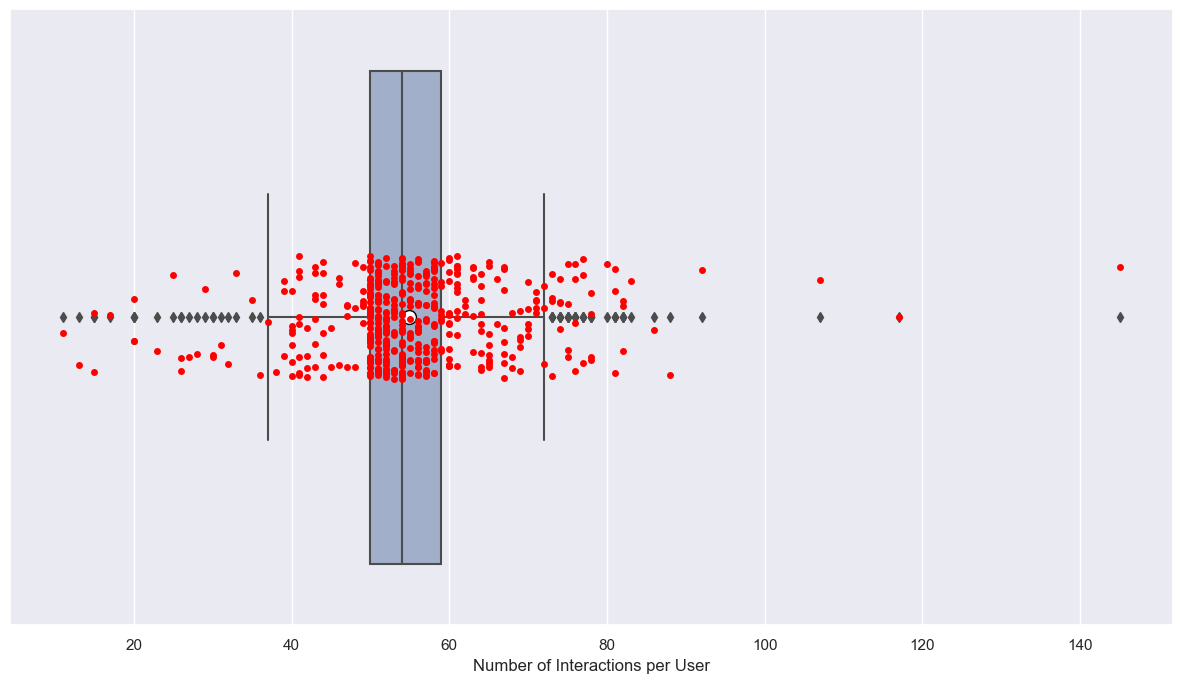

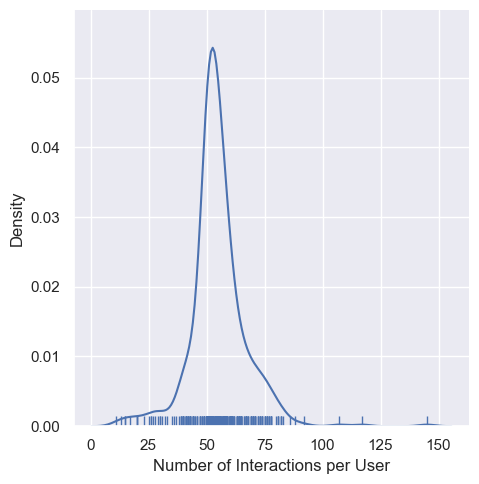

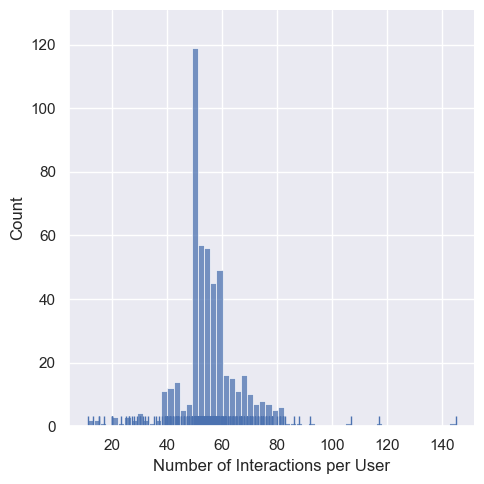

****************************************************************************************************
****************************************************************************************************
----------------------------------------------------------------------------------------------------
Number of Unique Topics per User:
----------------------------------------------------------------------------------------------------
mean: Number of Unique Topics per User: 4.849802371541502
median: Number of Unique Topics per User: 5.0
max: Number of Unique Topics per User: 5
min: Number of Unique Topics per User: 1
std: Number of Unique Topics per User: 0.5200627917860525
iqr: Number of Unique Topics per User: 0.0


Plots:


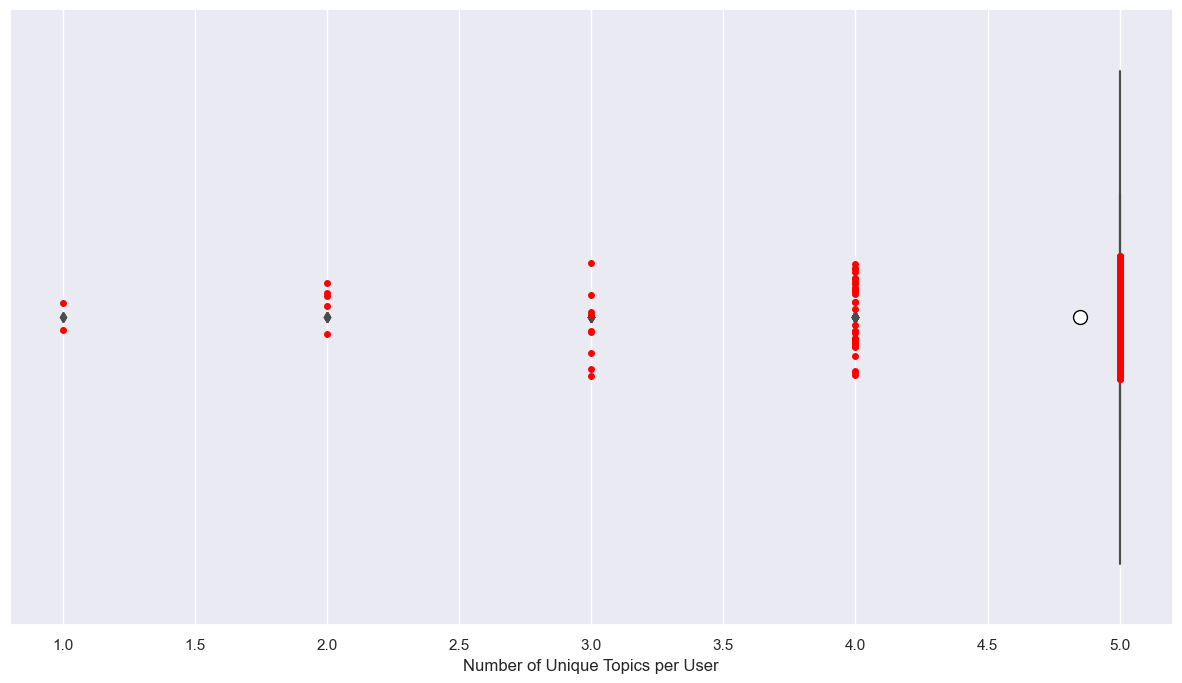

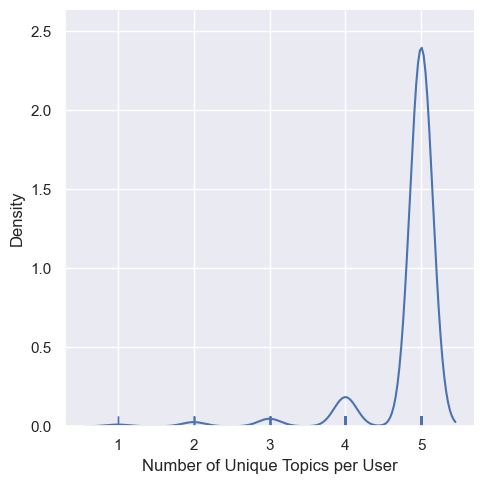

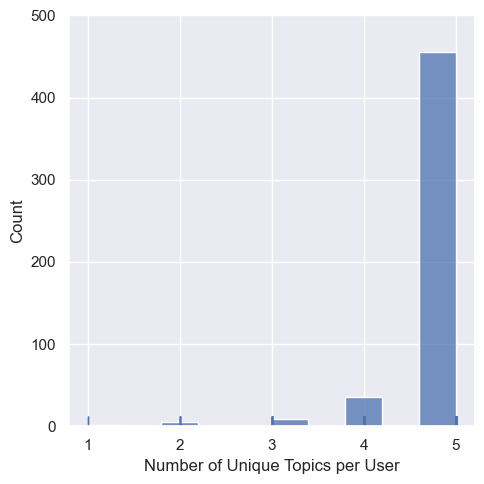

****************************************************************************************************
****************************************************************************************************
 
----------------------------------------------------------------------------------------------------
Number of Unique Learning Resources per User:
----------------------------------------------------------------------------------------------------
mean: Number of Unique Learning Resources per User: 47.49407114624506
median: Number of Unique Learning Resources per User: 50.0
max: Number of Unique Learning Resources per User: 50
min: Number of Unique Learning Resources per User: 9
std: Number of Unique Learning Resources per User: 6.203557301655888
iqr: Number of Unique Learning Resources per User: 1.0


Plots:


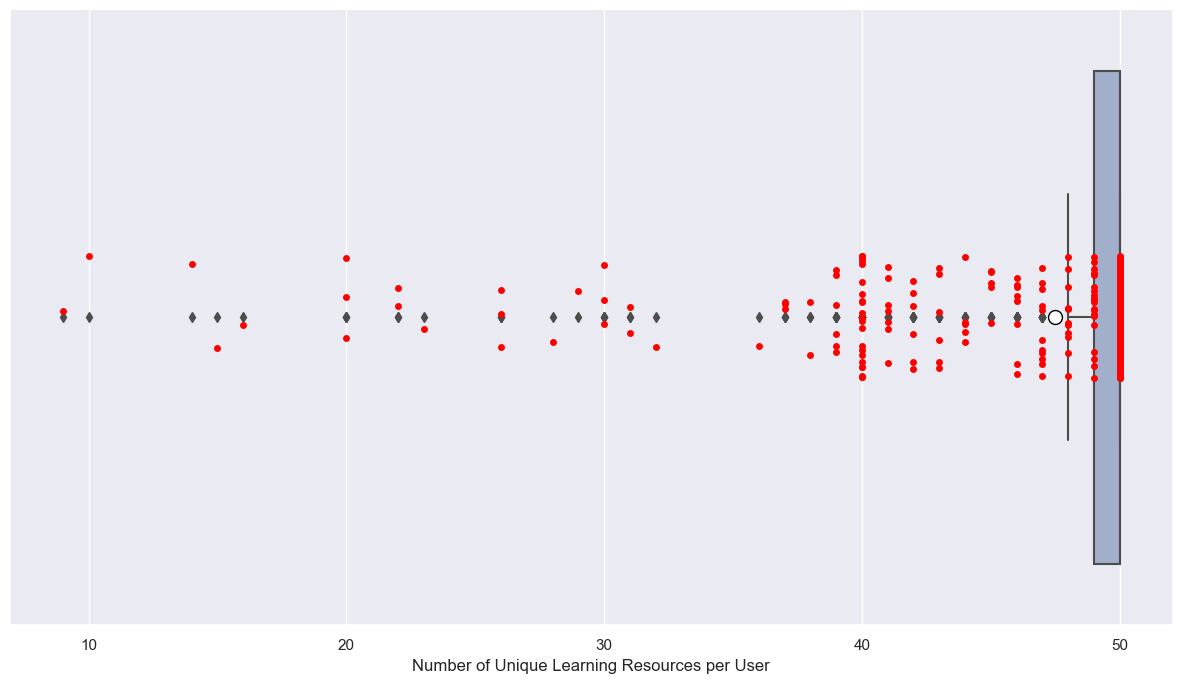

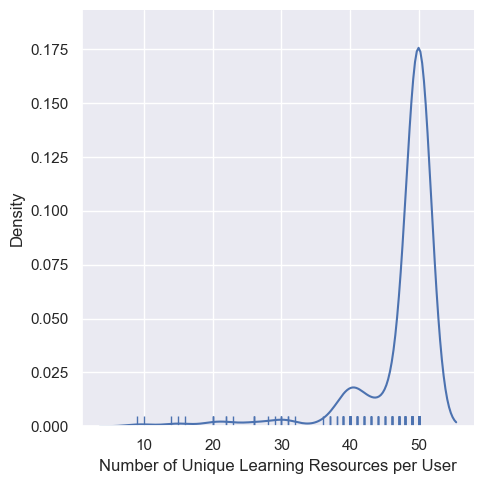

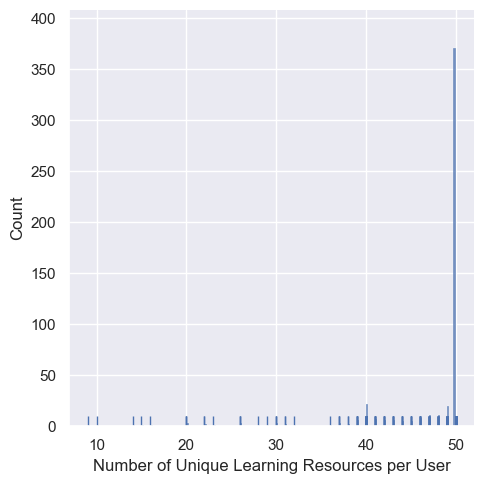

****************************************************************************************************
****************************************************************************************************
 
----------------------------------------------------------------------------------------------------
Number of Unique Users per Topic:
----------------------------------------------------------------------------------------------------
mean: Number of Unique Users per Topic: 490.8
median: Number of Unique Users per Topic: 494.0
max: Number of Unique Users per Topic: 500
min: Number of Unique Users per Topic: 478
std: Number of Unique Users per Topic: 8.318653737234168
iqr: Number of Unique Users per Topic: 6.0


Plots:


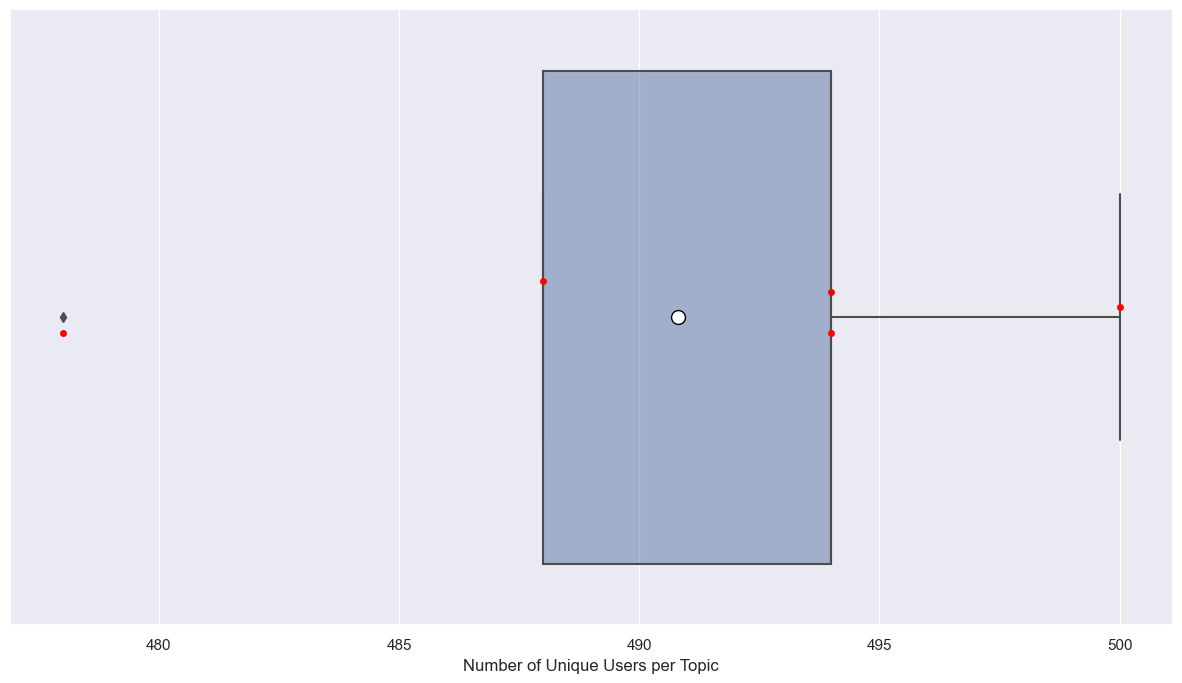

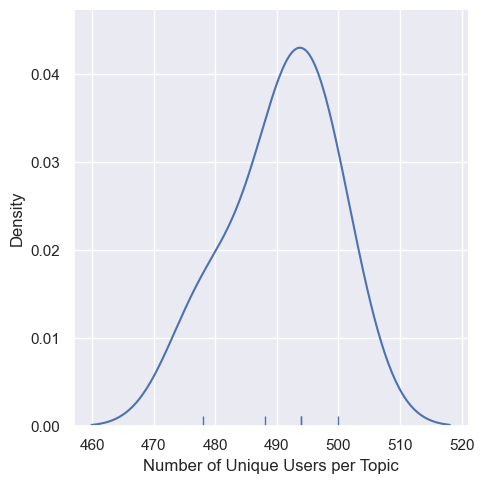

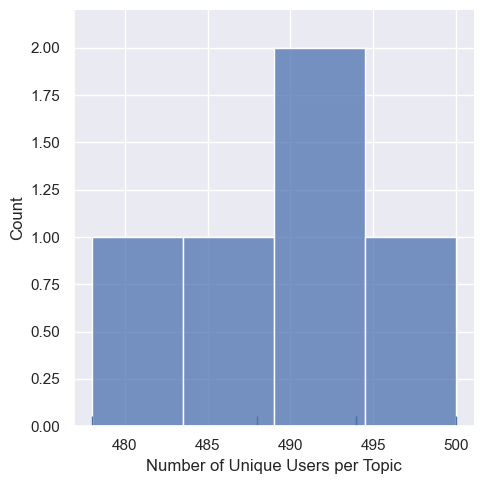

****************************************************************************************************
****************************************************************************************************
 
----------------------------------------------------------------------------------------------------
Number of Unique Learning Resources per Topic:
----------------------------------------------------------------------------------------------------
mean: Number of Unique Learning Resources per Topic: 10.0
median: Number of Unique Learning Resources per Topic: 10.0
max: Number of Unique Learning Resources per Topic: 10
min: Number of Unique Learning Resources per Topic: 10
std: Number of Unique Learning Resources per Topic: 0.0
iqr: Number of Unique Learning Resources per Topic: 0.0


Plots:


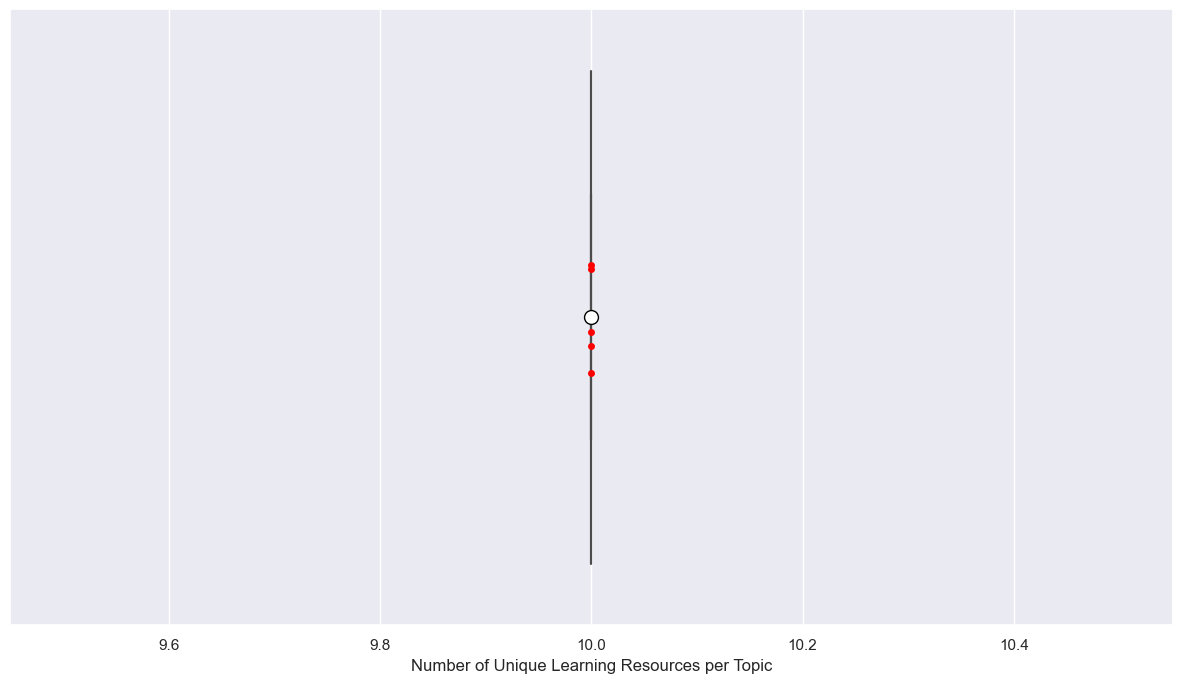

/Users/stefanschmerda/stefan/code/repos/know_center/ddia_dataset_analysis/dataset_analysis/notebooks/../utilities/functions.py:1221: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  g = sns.displot(data=data,


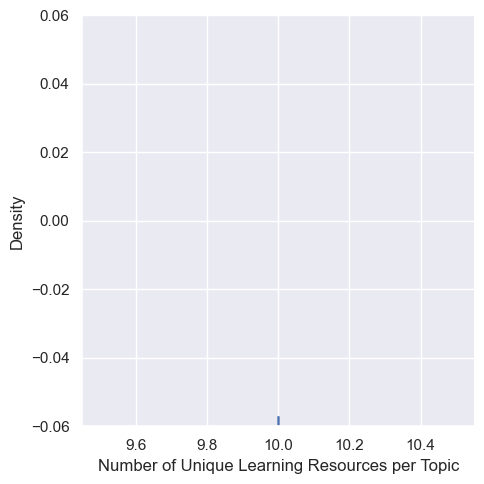

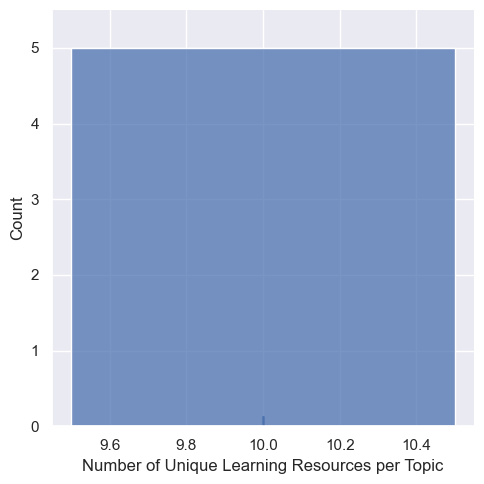

****************************************************************************************************
****************************************************************************************************
 
----------------------------------------------------------------------------------------------------
Number of Unique Users per Learning Resource:
----------------------------------------------------------------------------------------------------
mean: Number of Unique Users per Learning Resource: 480.64
median: Number of Unique Users per Learning Resource: 482.5
max: Number of Unique Users per Learning Resource: 500
min: Number of Unique Users per Learning Resource: 451
std: Number of Unique Users per Learning Resource: 11.81448436523264
iqr: Number of Unique Users per Learning Resource: 15.0


Plots:


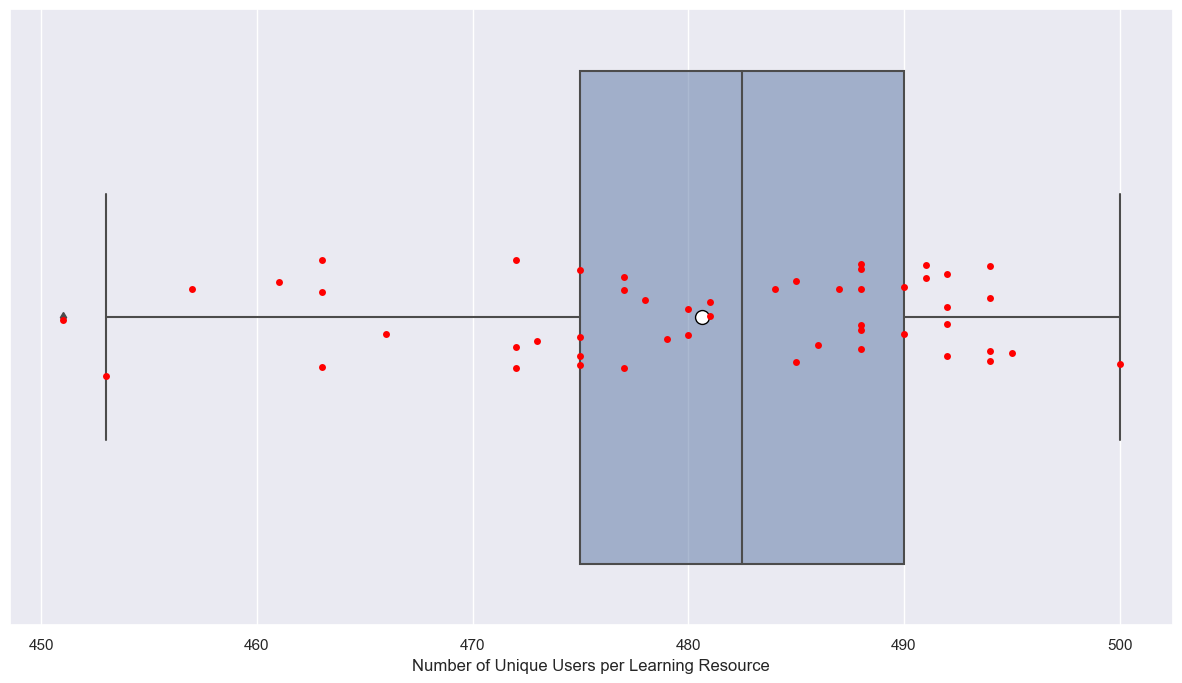

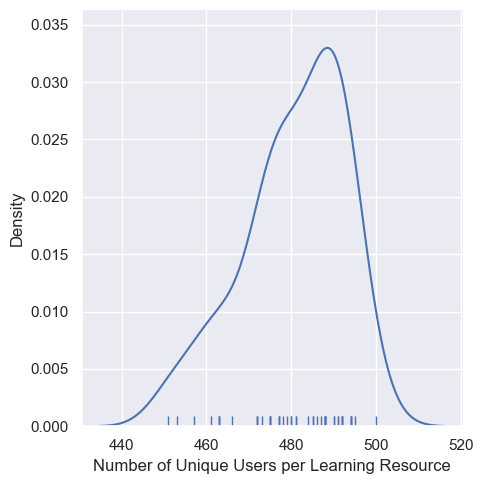

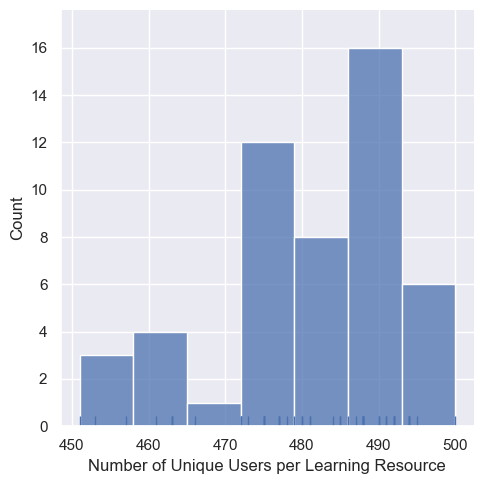

****************************************************************************************************
****************************************************************************************************
 
----------------------------------------------------------------------------------------------------
Number of Unique Topics per Learning Resource:
----------------------------------------------------------------------------------------------------
mean: Number of Unique Topics per Learning Resource: 1.0
median: Number of Unique Topics per Learning Resource: 1.0
max: Number of Unique Topics per Learning Resource: 1
min: Number of Unique Topics per Learning Resource: 1
std: Number of Unique Topics per Learning Resource: 0.0
iqr: Number of Unique Topics per Learning Resource: 0.0


Plots:


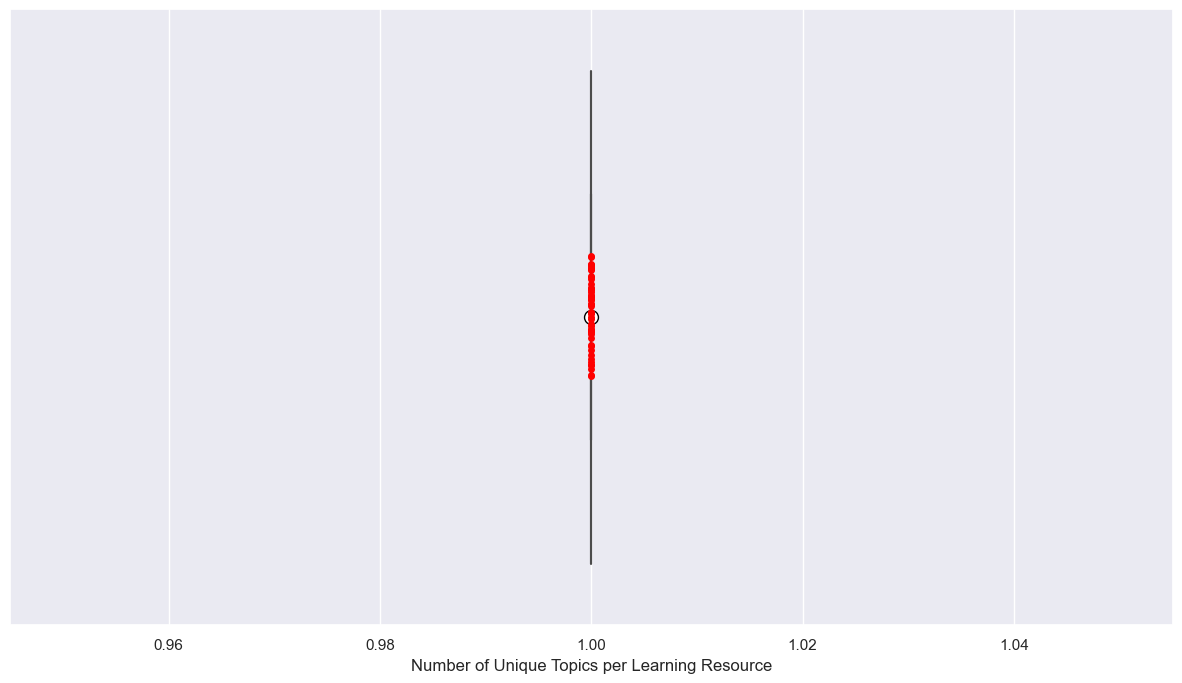

/Users/stefanschmerda/stefan/code/repos/know_center/ddia_dataset_analysis/dataset_analysis/notebooks/../utilities/functions.py:1221: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  g = sns.displot(data=data,


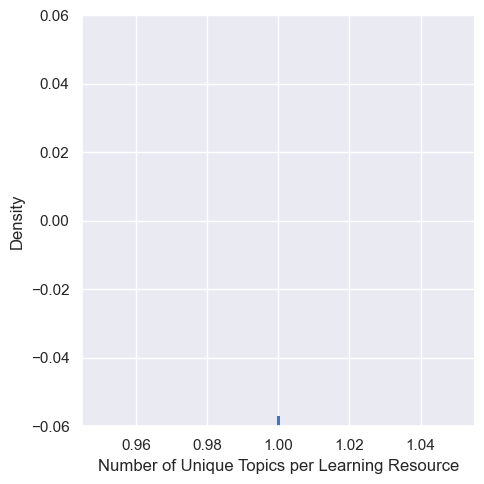

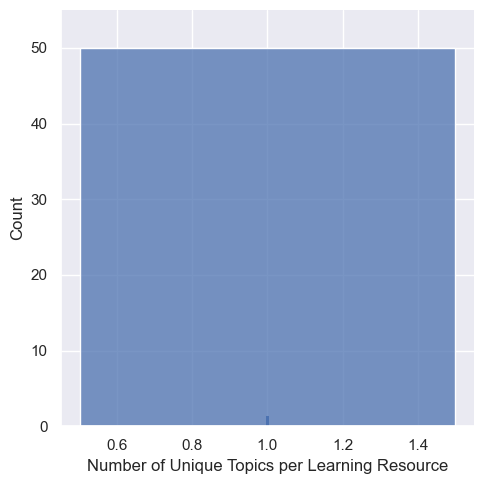

****************************************************************************************************
****************************************************************************************************
 
----------------------------------------------------------------------------------------------------
Mean/Median Number of Interactions per Topic for a User:
----------------------------------------------------------------------------------------------------
mean of Mean Number of Interactions per Topic for a User: 11.285342555994731
median of Mean Number of Interactions per Topic for a User: 10.8
max of Mean Number of Interactions per Topic for a User: 29.0
min of Mean Number of Interactions per Topic for a User: 5.666666666666667
std of Mean Number of Interactions per Topic for a User: 2.039154364065365
iqr of Mean Number of Interactions per Topic for a User: 1.8000000000000007

____________________________________________________________________________________________________

mean

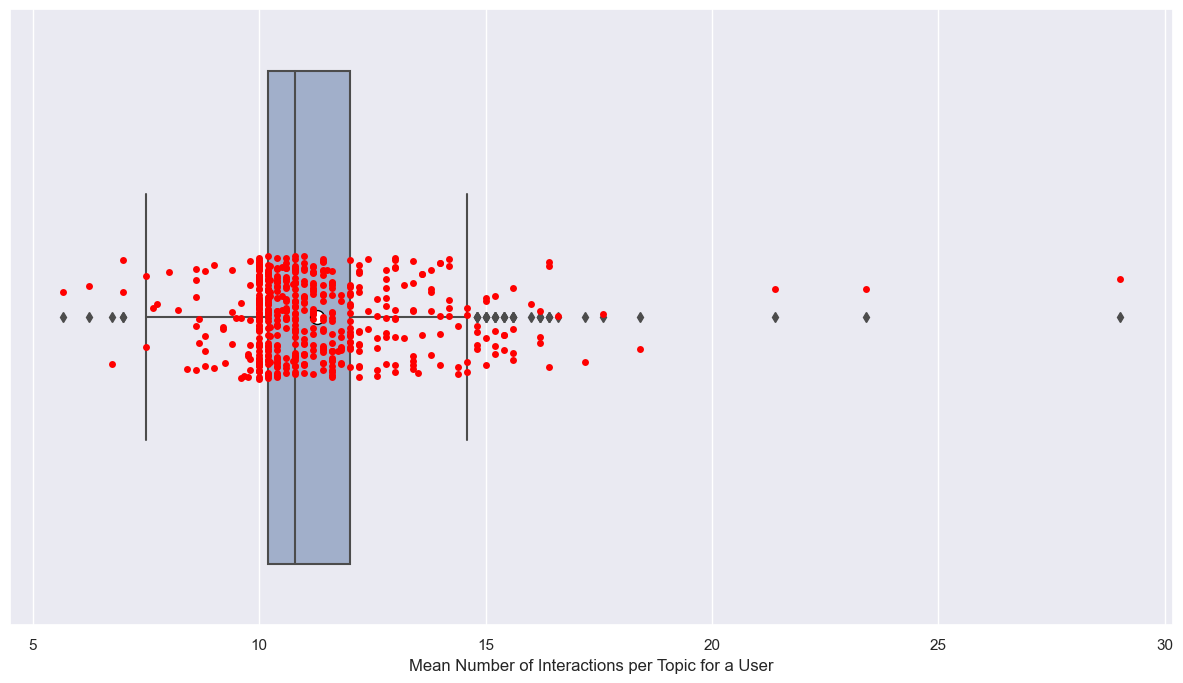

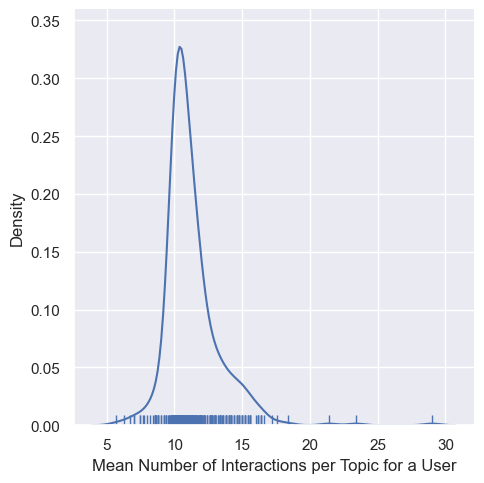

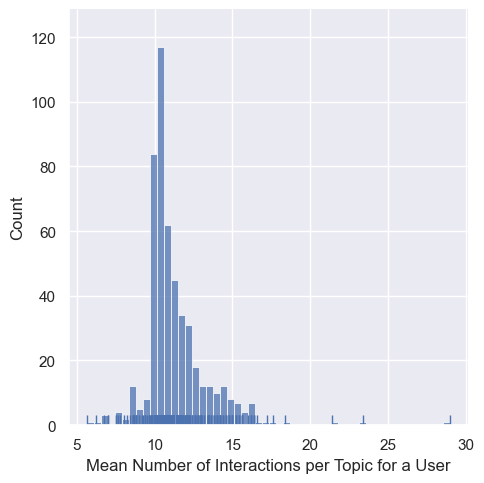



Median:


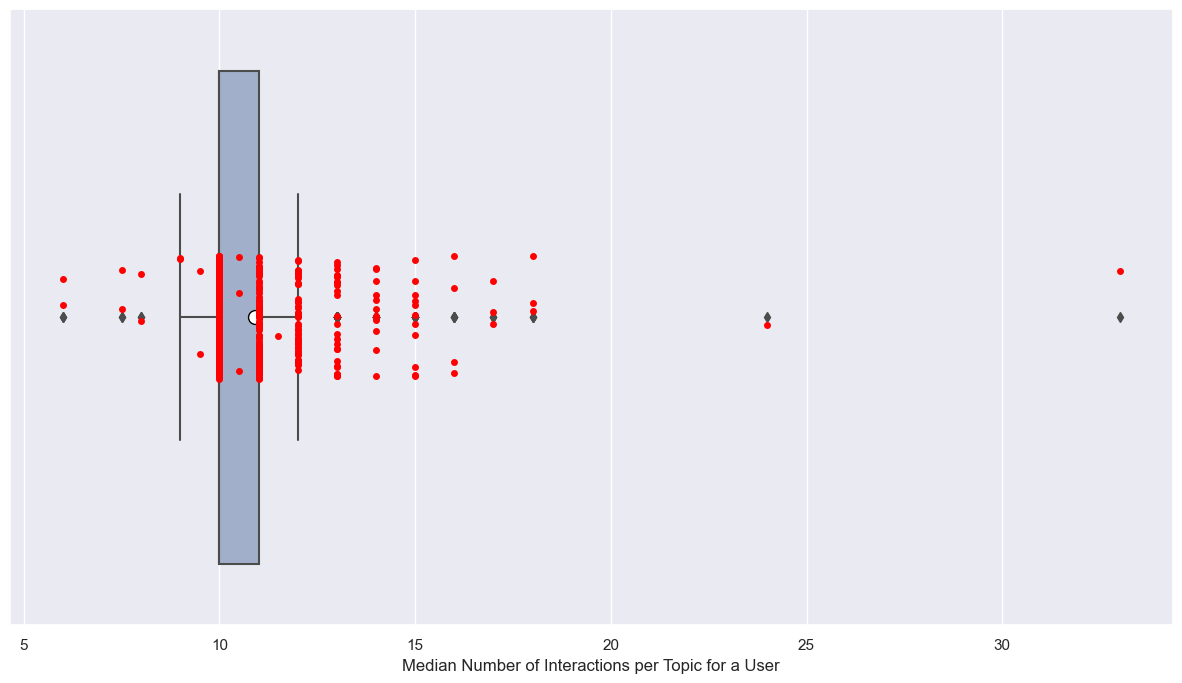

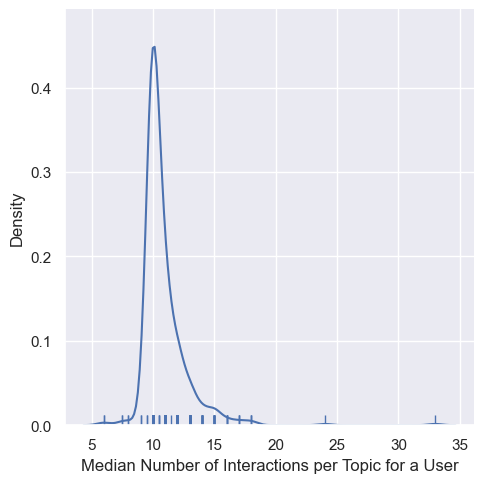

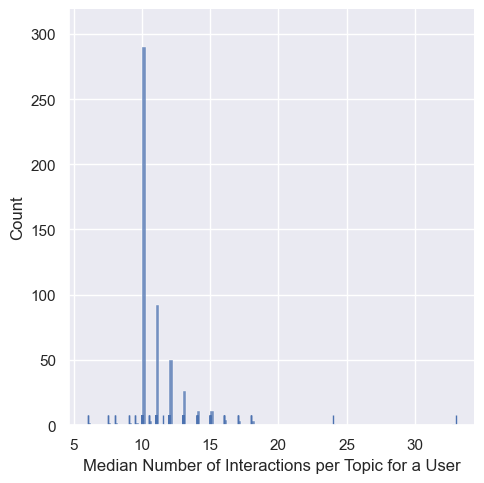

****************************************************************************************************
****************************************************************************************************
 
----------------------------------------------------------------------------------------------------
Mean/Median Number of Interactions per User for a Topic:
----------------------------------------------------------------------------------------------------
mean of Mean Number of Interactions per User for a Topic: 11.327385990497673
median of Mean Number of Interactions per User for a Topic: 11.272540983606557
max of Mean Number of Interactions per User for a Topic: 12.022267206477732
min of Mean Number of Interactions per User for a Topic: 10.642259414225942
std of Mean Number of Interactions per User for a Topic: 0.5919714818674018
iqr of Mean Number of Interactions per User for a Topic: 0.9438623481781381

____________________________________________________________________________

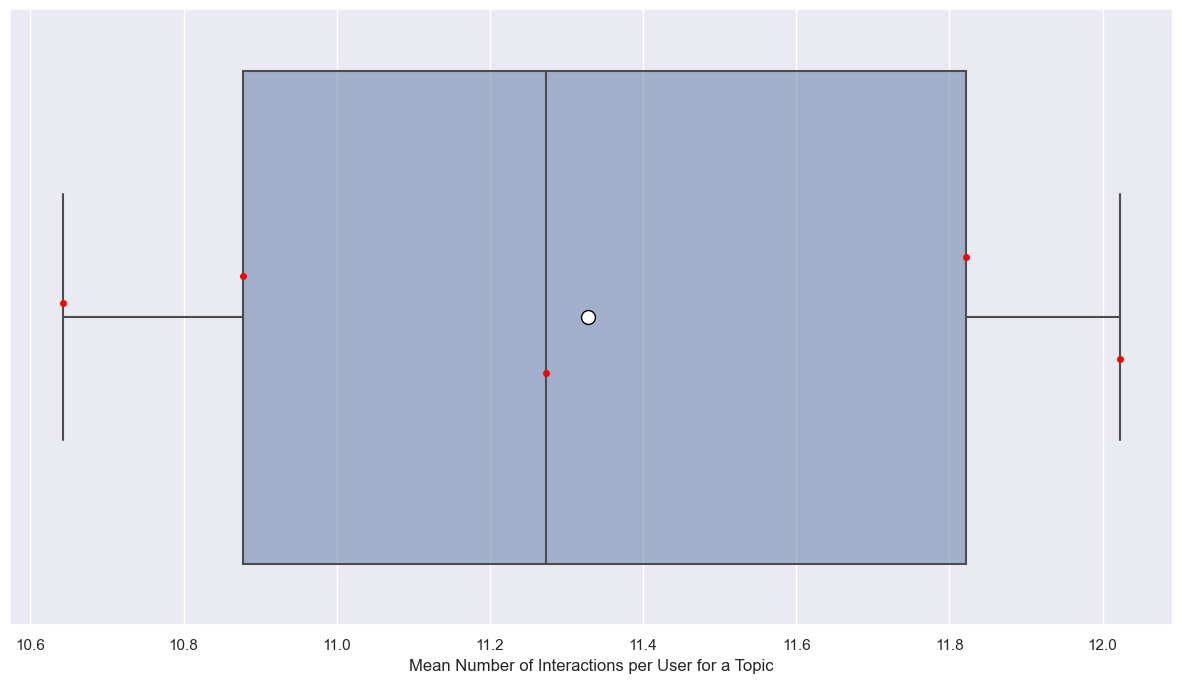

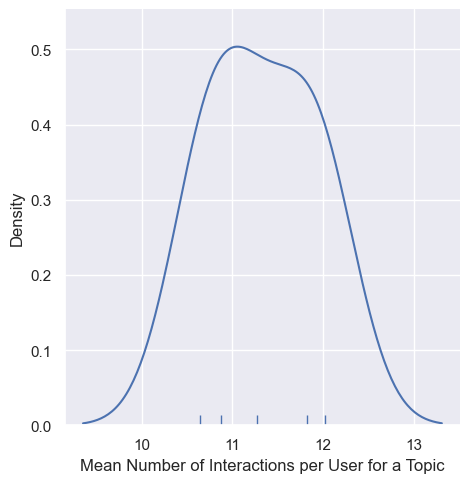

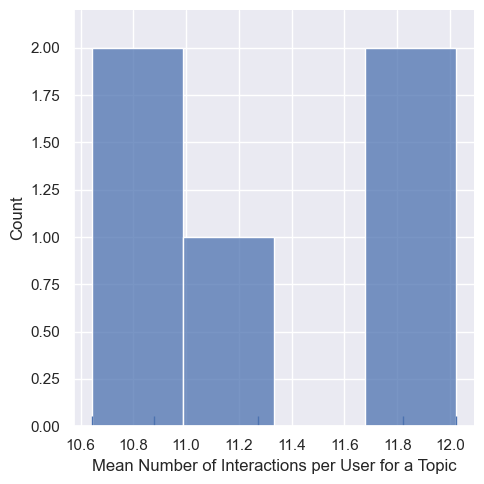



Median:


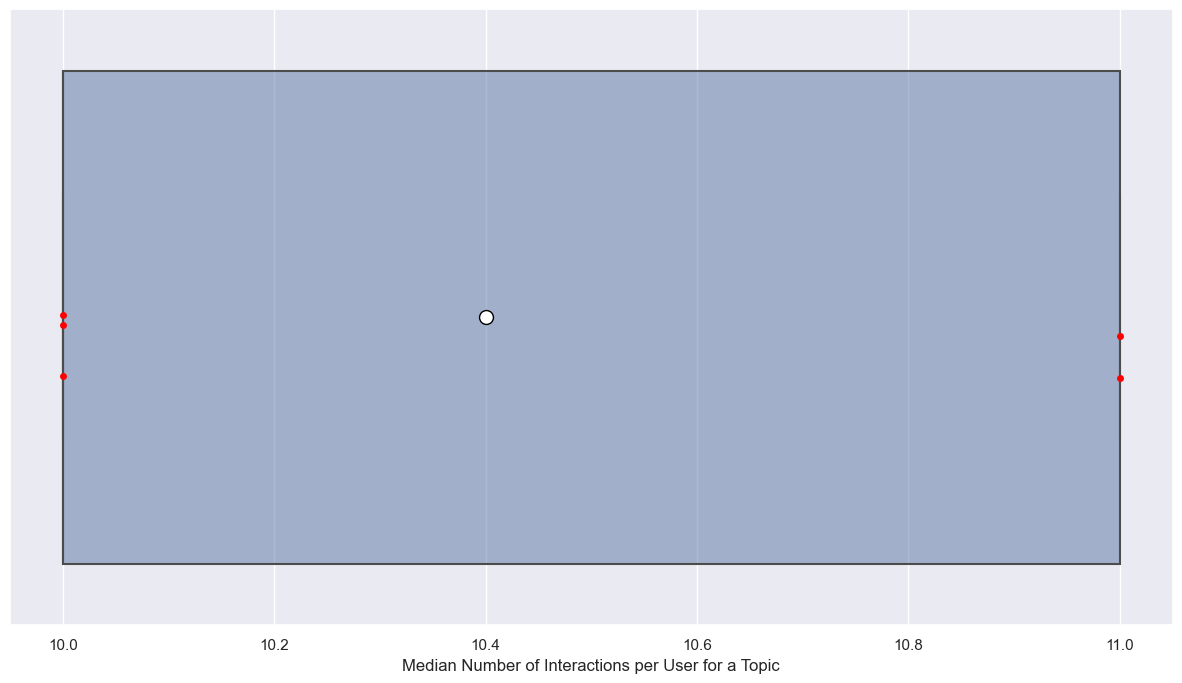

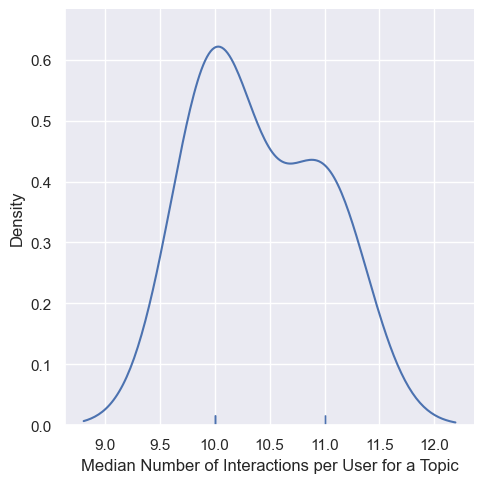

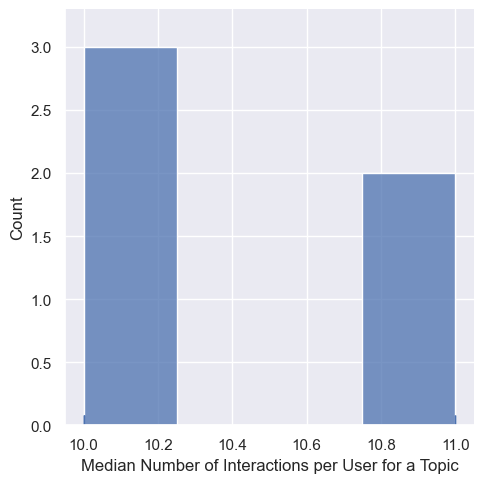

****************************************************************************************************
****************************************************************************************************
 
----------------------------------------------------------------------------------------------------
Mean/Median Number of Unique Learning Resources per Topic for a User:
----------------------------------------------------------------------------------------------------
mean of Mean Number of Unique Learning Resources per Topic for a User: 9.773320158102766
median of Mean Number of Unique Learning Resources per Topic for a User: 10.0
max of Mean Number of Unique Learning Resources per Topic for a User: 10.0
min of Mean Number of Unique Learning Resources per Topic for a User: 5.333333333333333

____________________________________________________________________________________________________

mean of Median Number of Unique Learning Resources per Topic for a User: 9.945652173913043


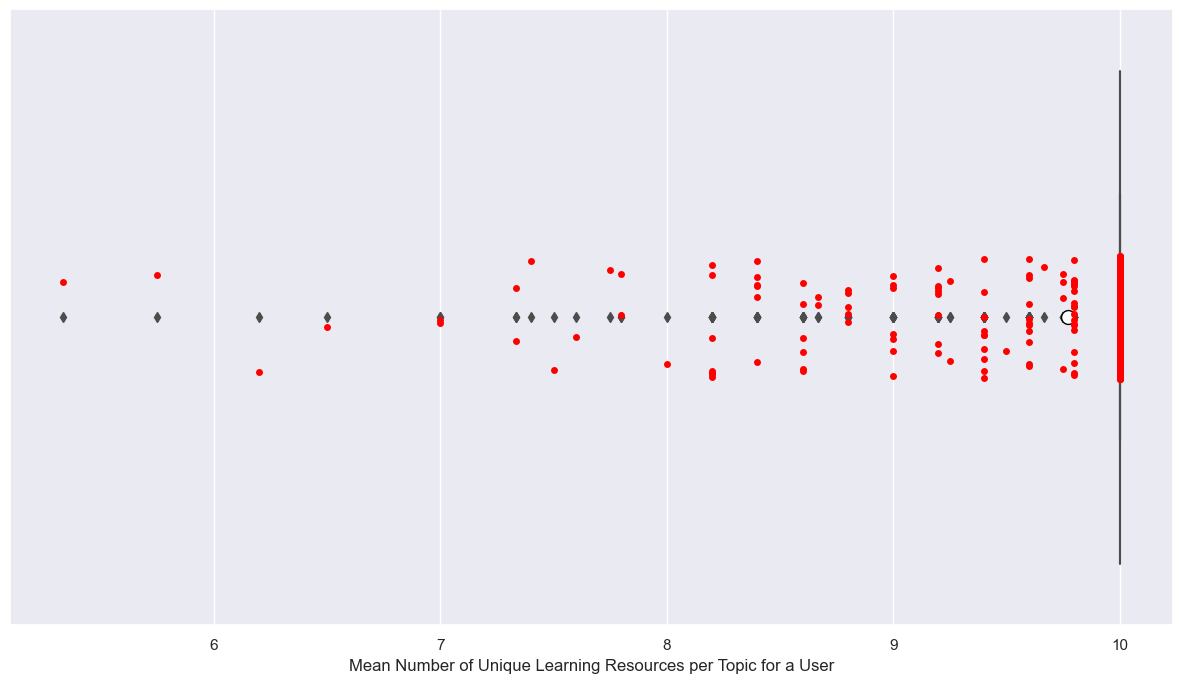

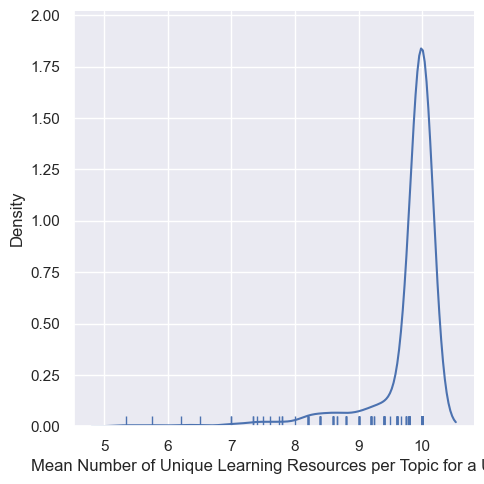

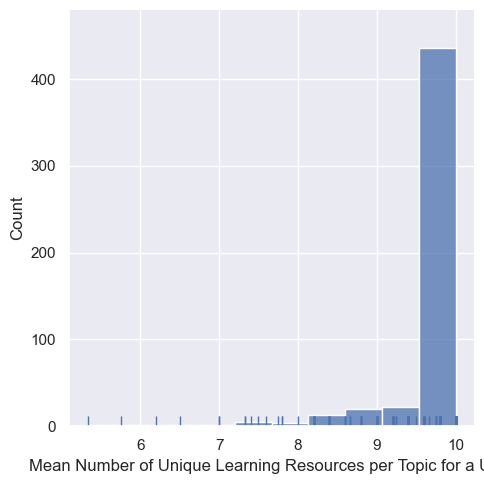



Median:


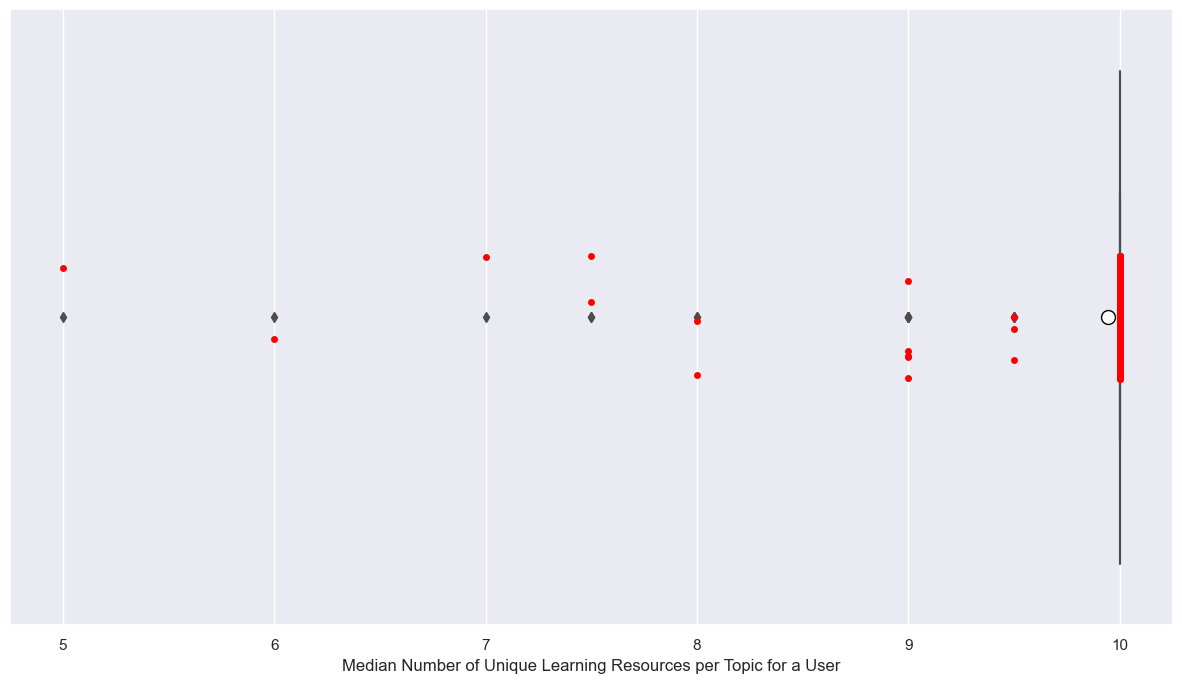

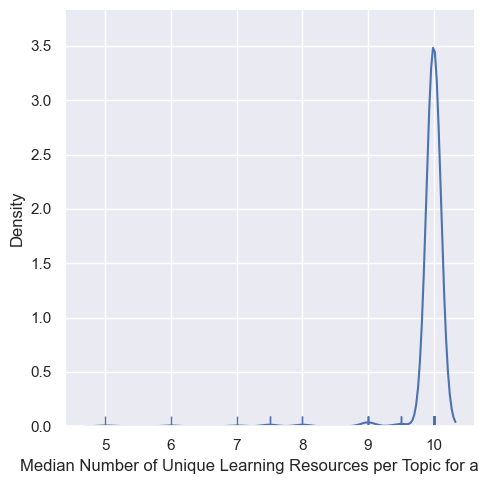

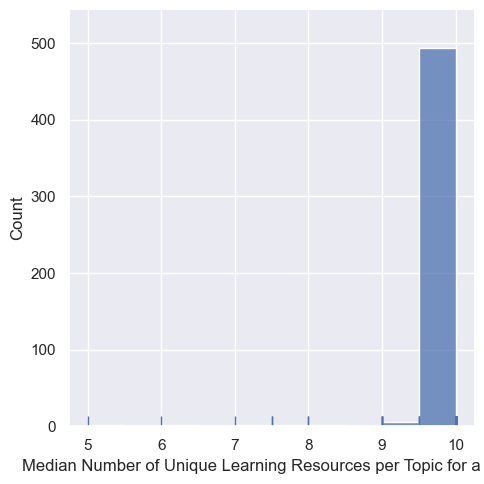

****************************************************************************************************
****************************************************************************************************
 
----------------------------------------------------------------------------------------------------
Mean/Median Number of Unique Learning Resources per User for a Topic:
----------------------------------------------------------------------------------------------------
mean of Mean Number of Unique Learning Resources per User for a Topic: 9.792459723749955
median of Mean Number of Unique Learning Resources per User for a Topic: 9.757085020242915
max of Mean Number of Unique Learning Resources per User for a Topic: 9.89344262295082
min of Mean Number of Unique Learning Resources per User for a Topic: 9.702928870292887

____________________________________________________________________________________________________

mean of Median Number of Unique Learning Resources per User for a 

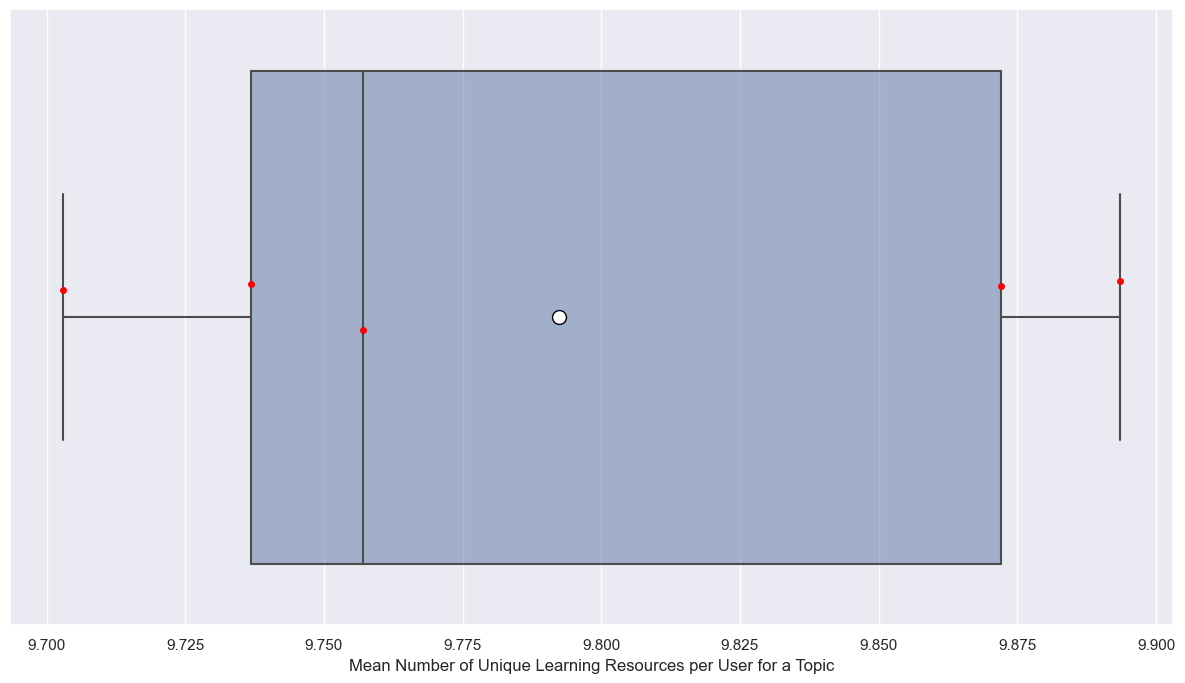

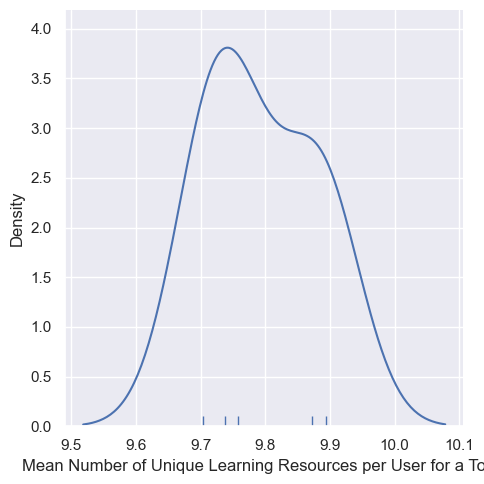

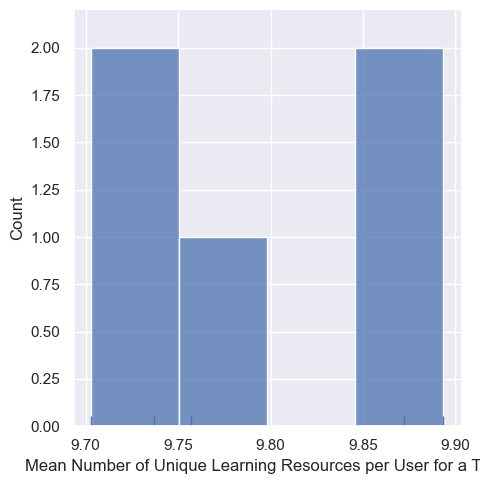



Median:


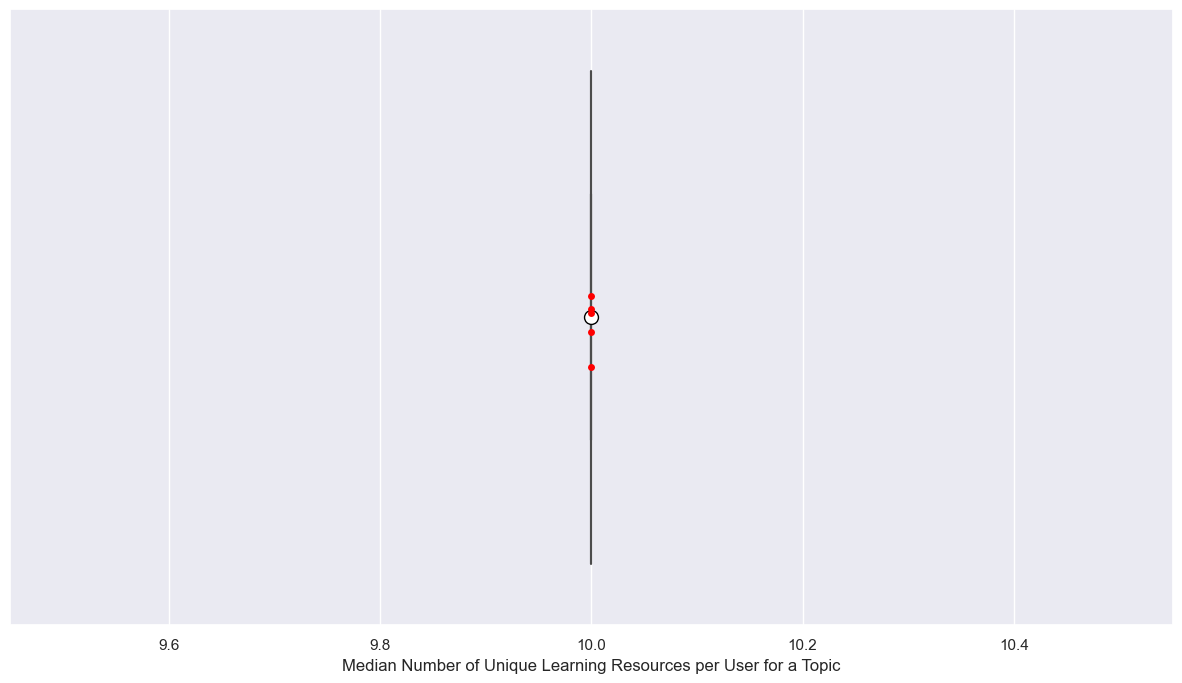

/Users/stefanschmerda/stefan/code/repos/know_center/ddia_dataset_analysis/dataset_analysis/notebooks/../utilities/functions.py:1221: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  g = sns.displot(data=data,


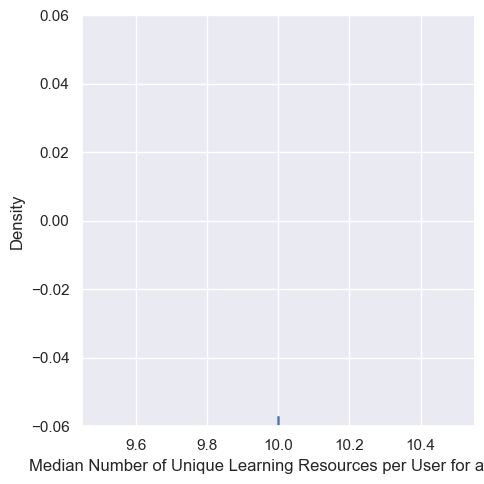

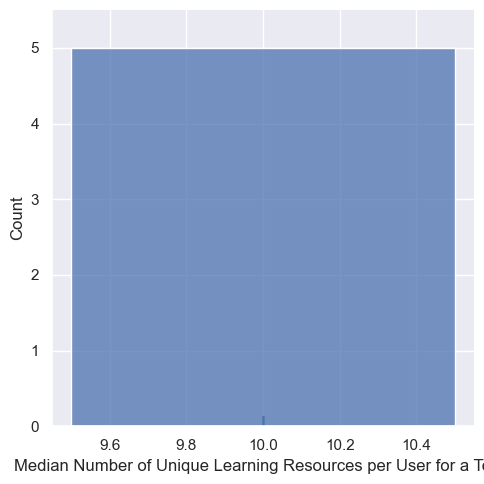

****************************************************************************************************
****************************************************************************************************
 


In [26]:
print_and_plot_group_user_learning_activity_relationship(interactions,
                                                         GROUP_FIELD,
                                                         False)

## Unique Sequence Statistics

In [27]:
learning_activity_sequence_stats_per_group = return_learning_activity_sequence_stats_over_user_per_group(interactions,
                                                                                                         DATASET_NAME,
                                                                                                         GROUP_FIELD_NAME_STR, 
                                                                                                         USER_FIELD_NAME_STR, 
                                                                                                         LEARNING_ACTIVITY_FIELD_NAME_STR,
                                                                                                         TIMESTAMP_FIELD_NAME_STR)

In [28]:
pickle_write(learning_activity_sequence_stats_per_group,
             PATH_TO_SEQUENCE_STATISTICS_PICKLE_FOLDER,
             DATASET_NAME + SEQUENCE_STATISTICS_TABLES_PICKLE_NAME)

### Unique Sequence Statistics

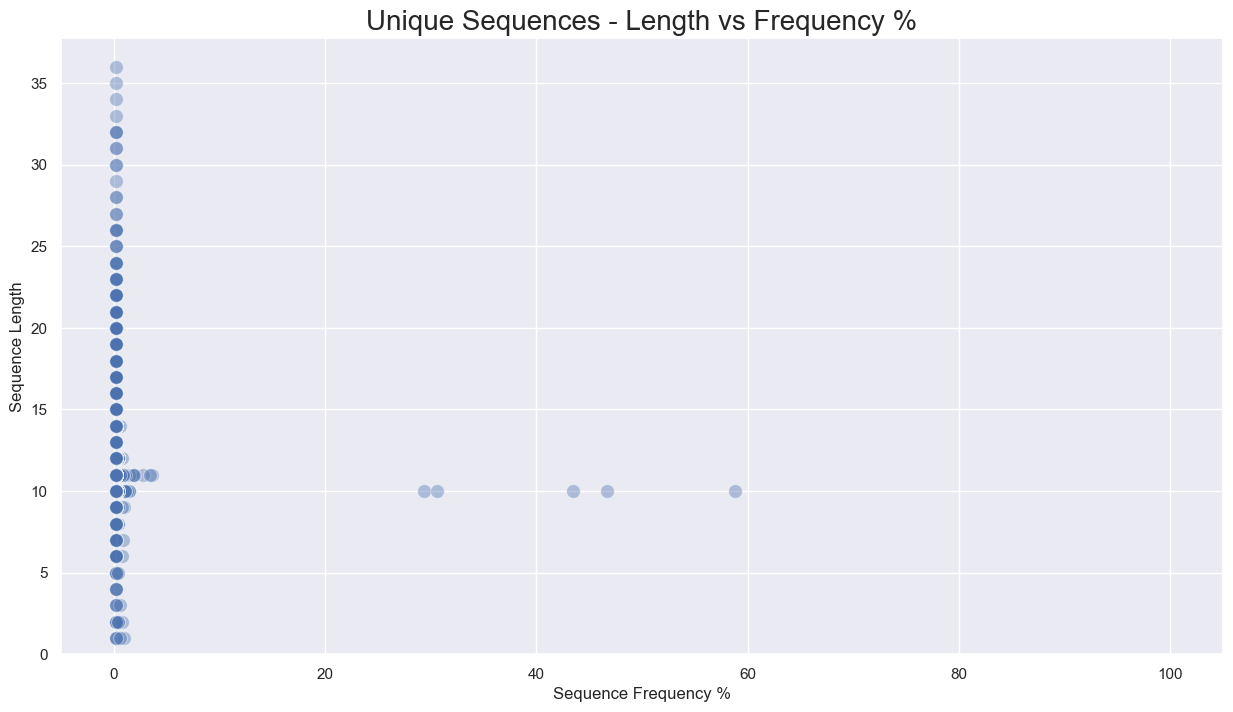

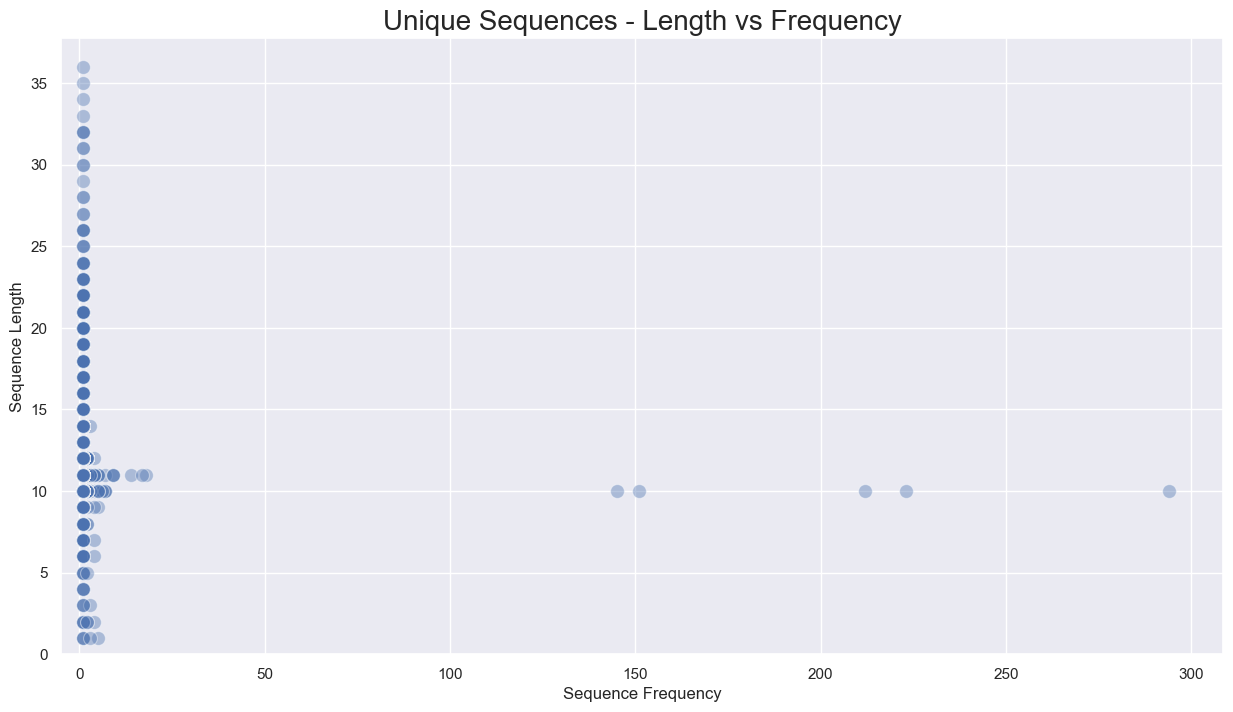

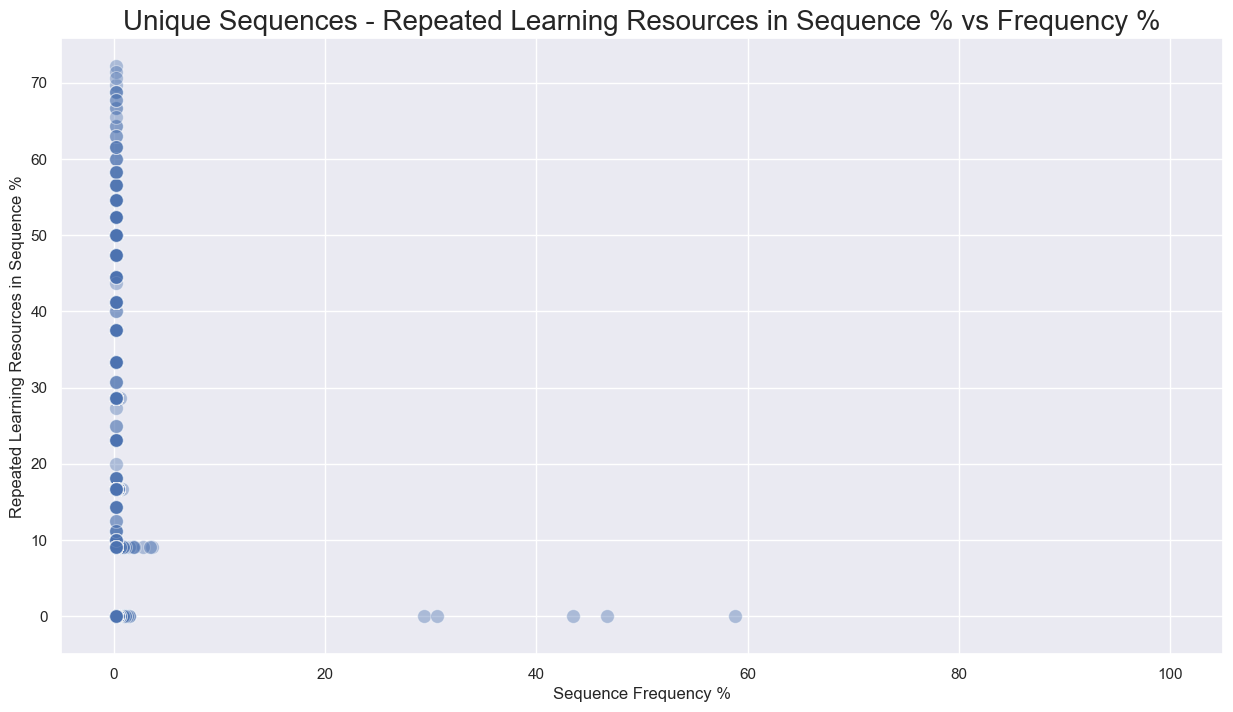

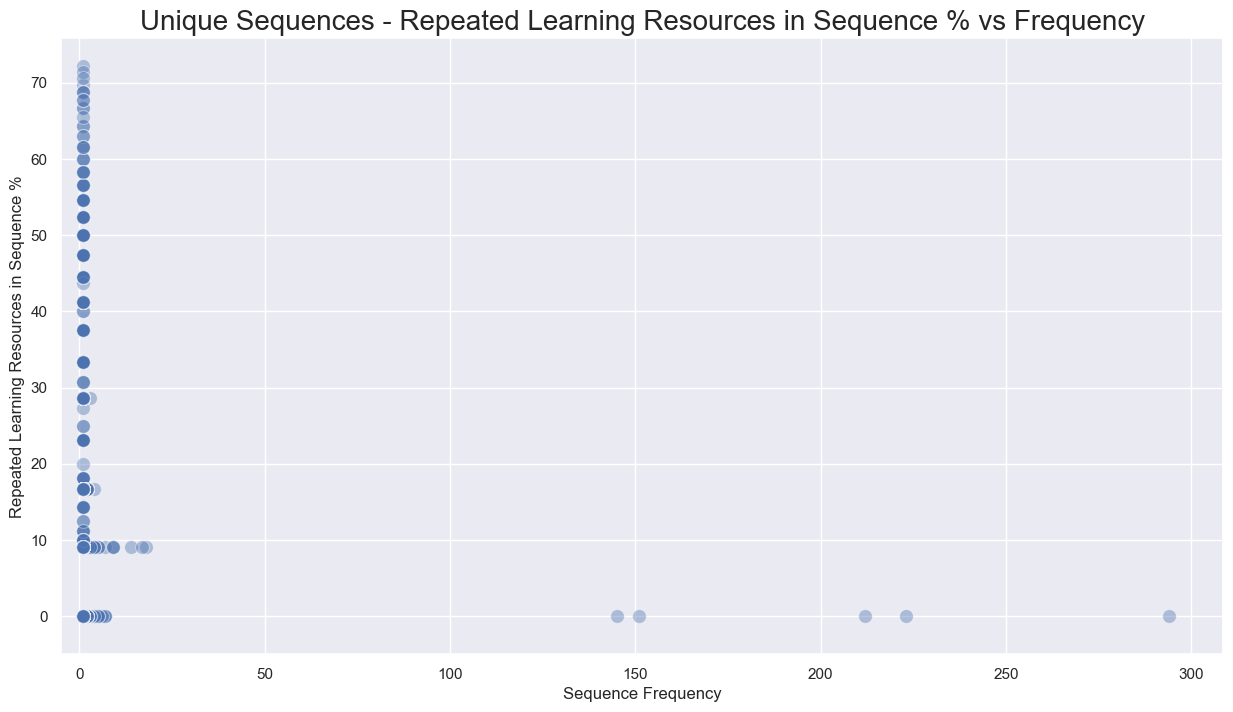

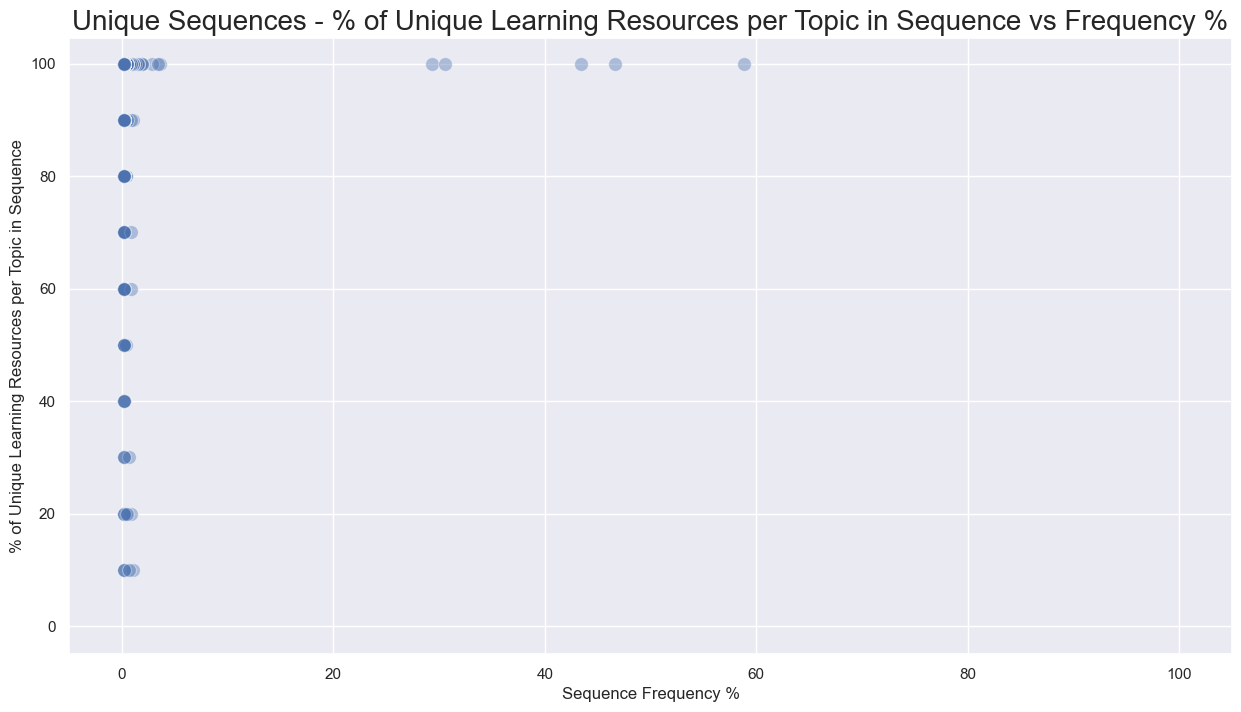

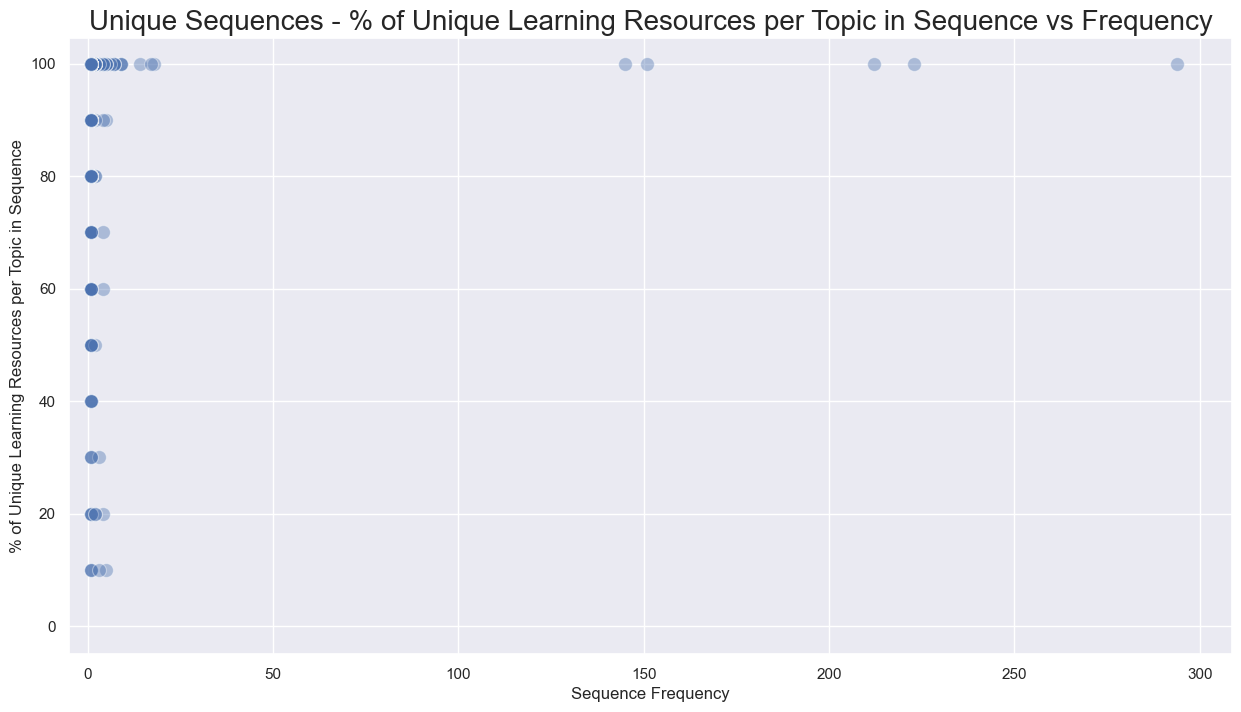

In [29]:
plot_sequence_stats(learning_activity_sequence_stats_per_group)

### Unique Sequence Statistics per Group

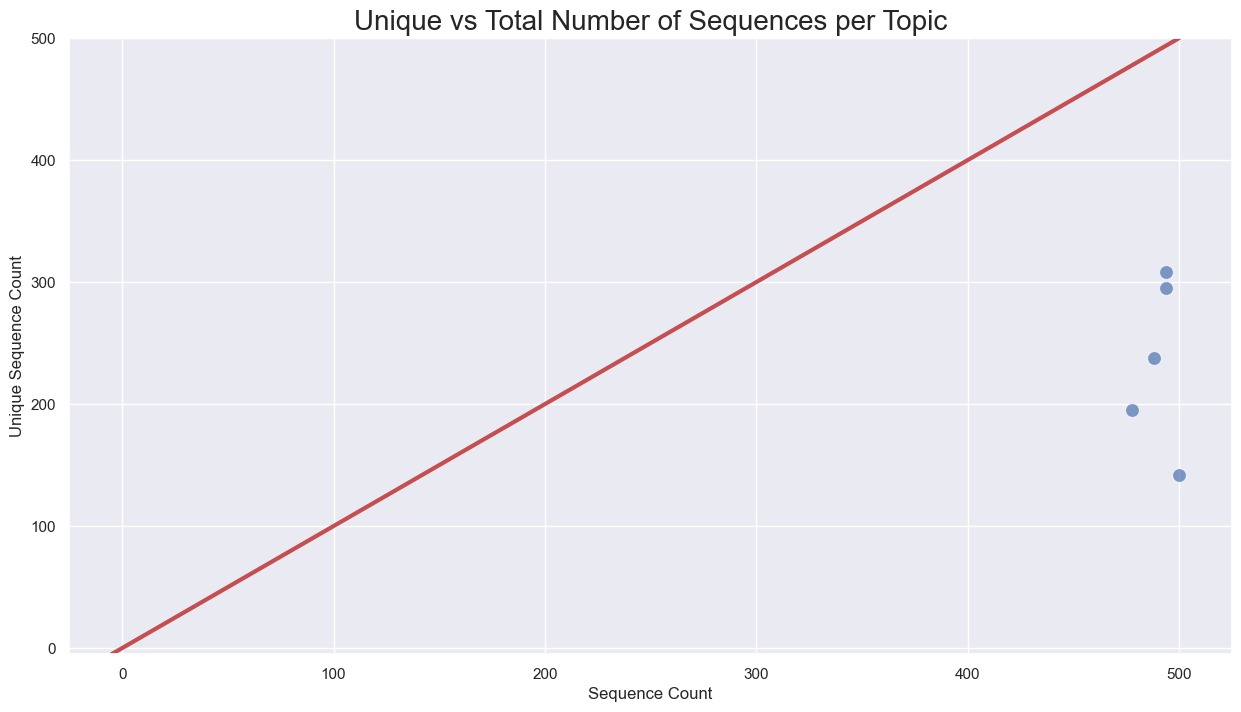

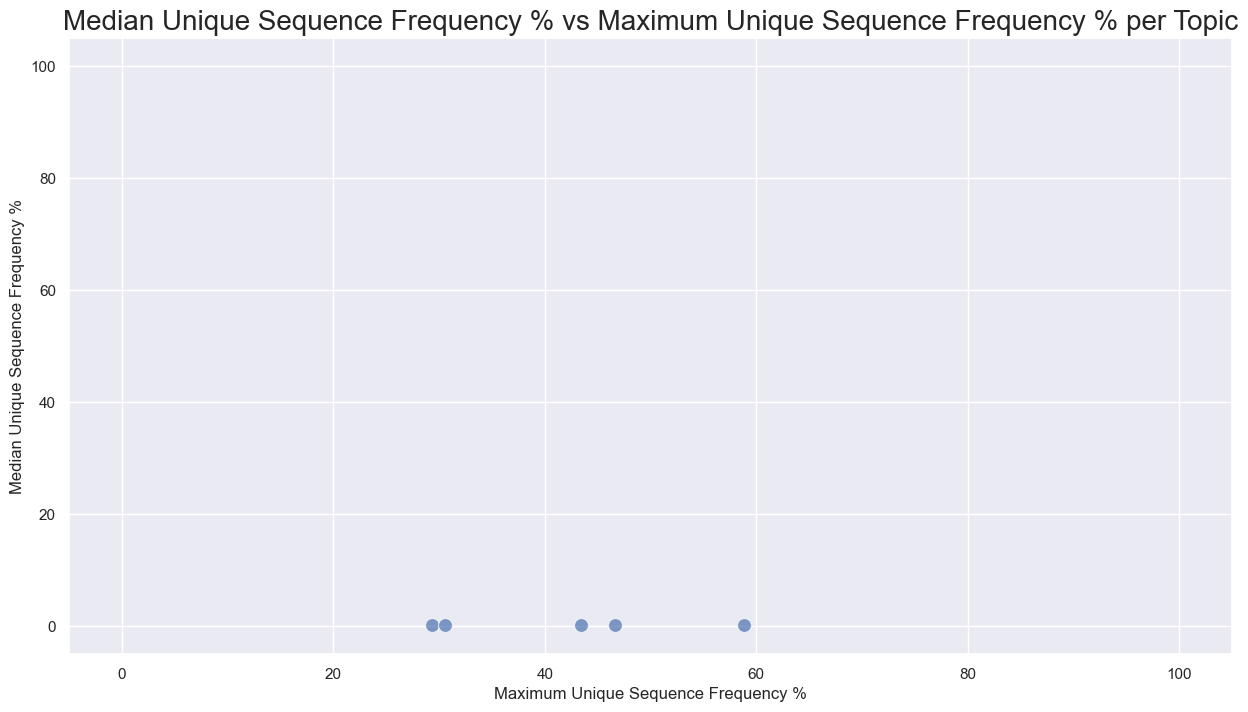

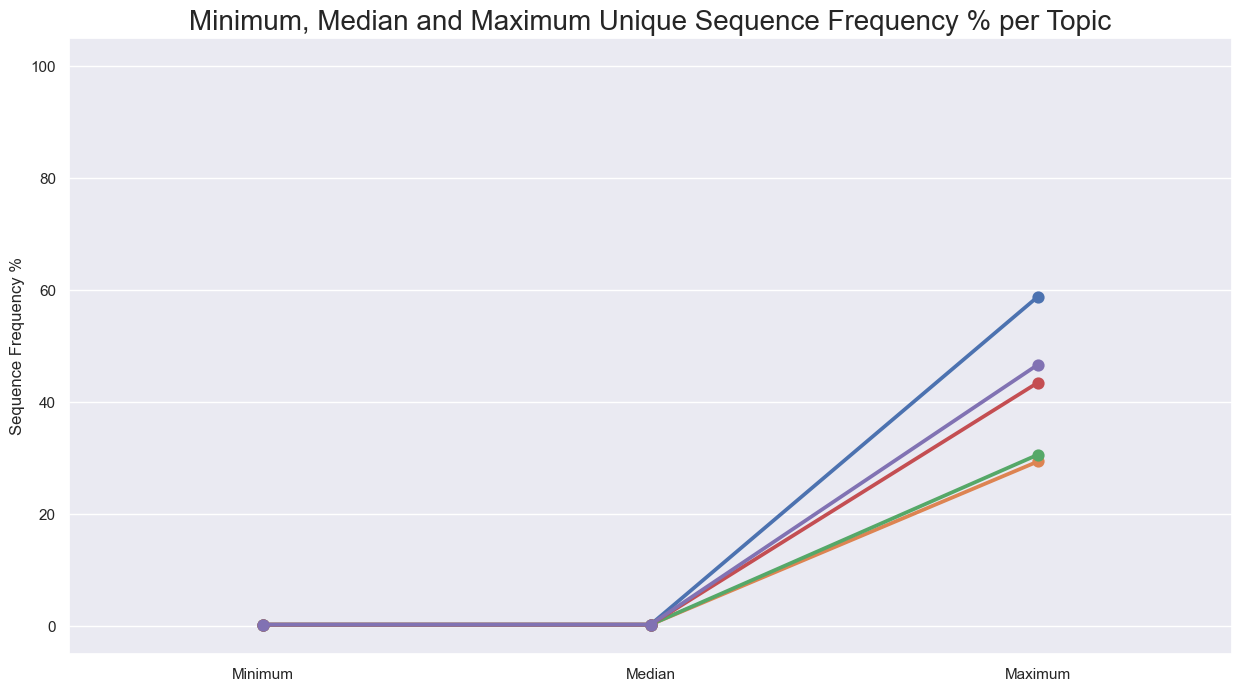

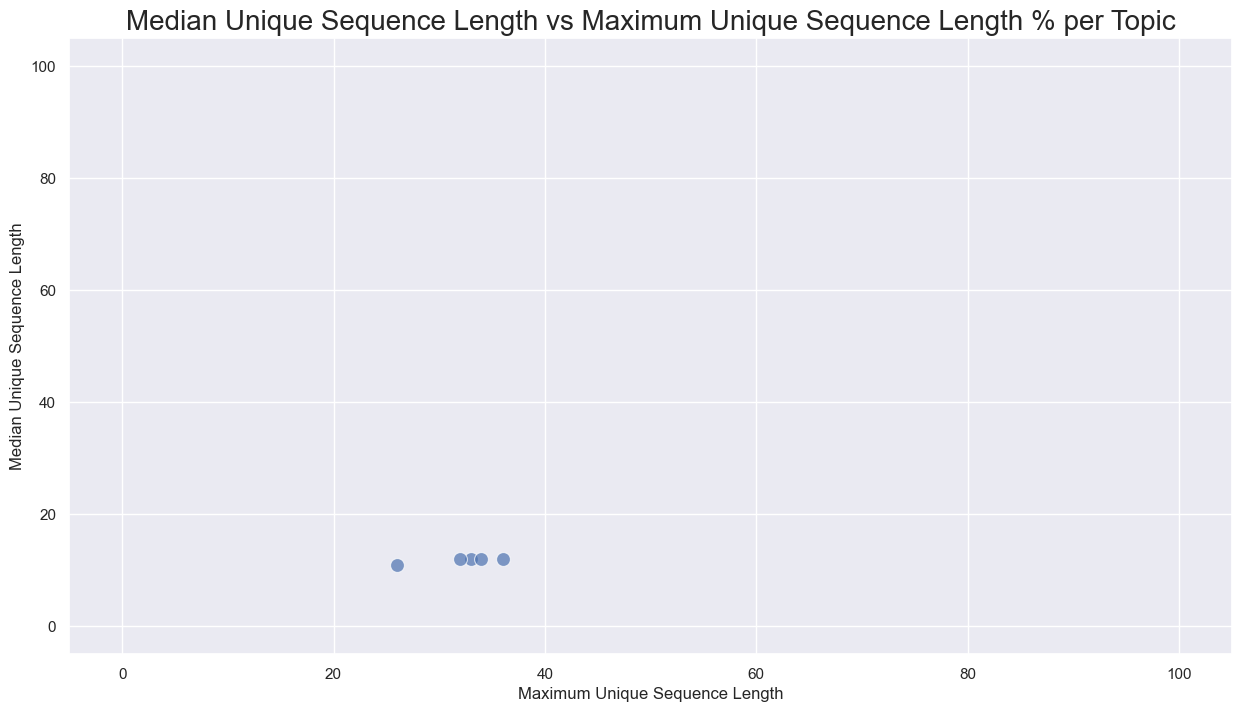

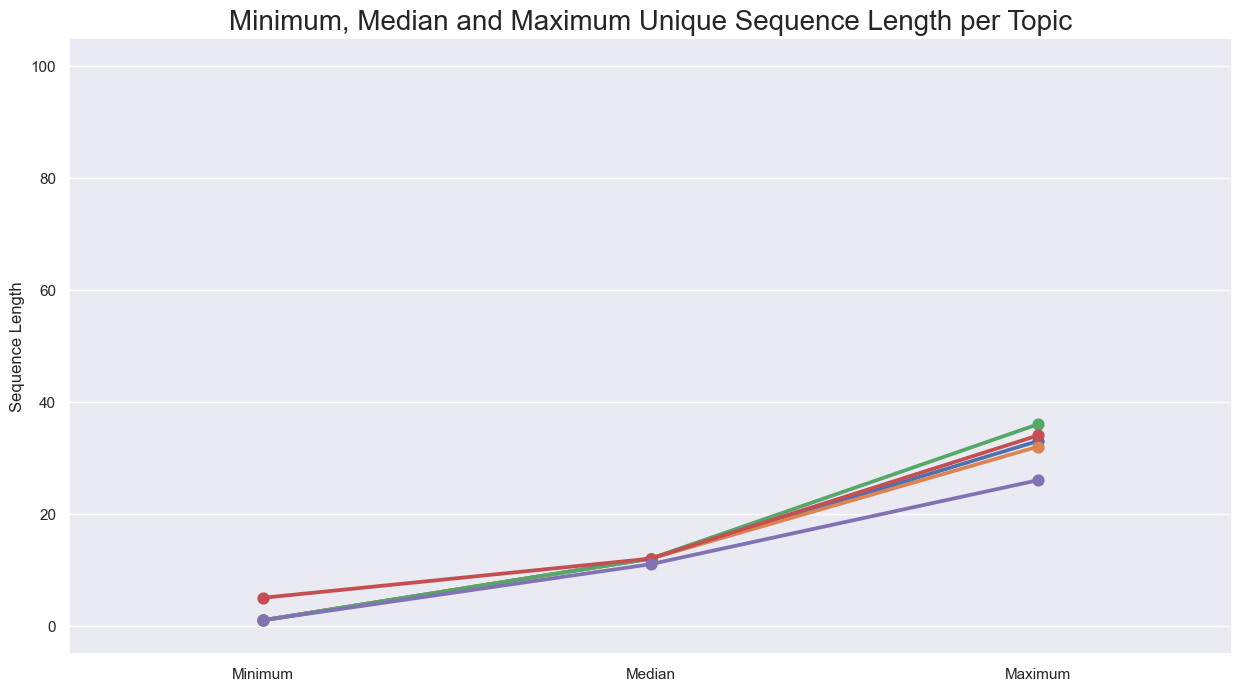

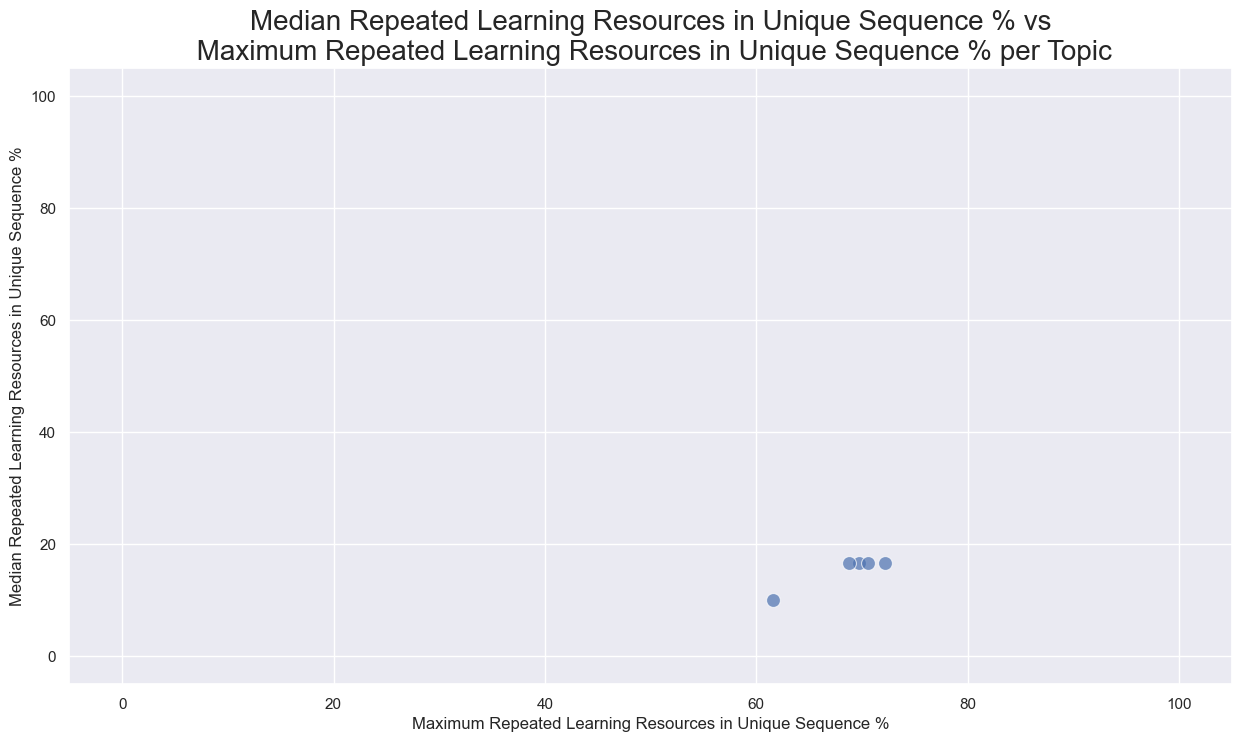

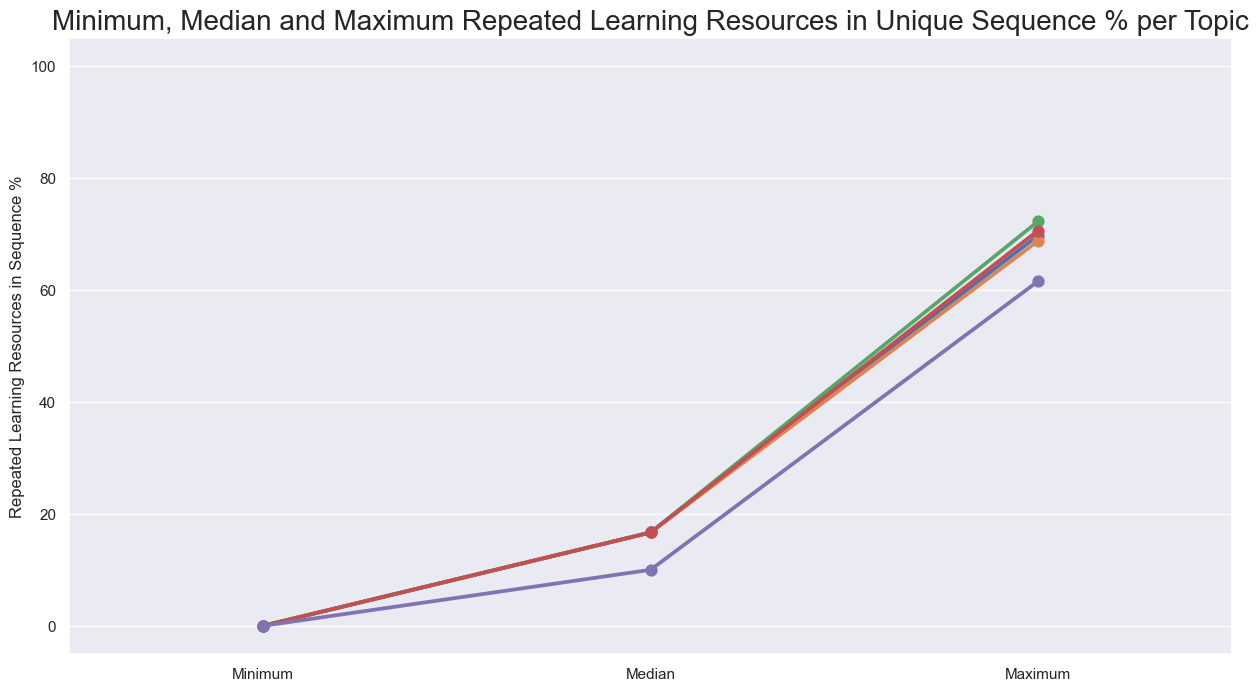

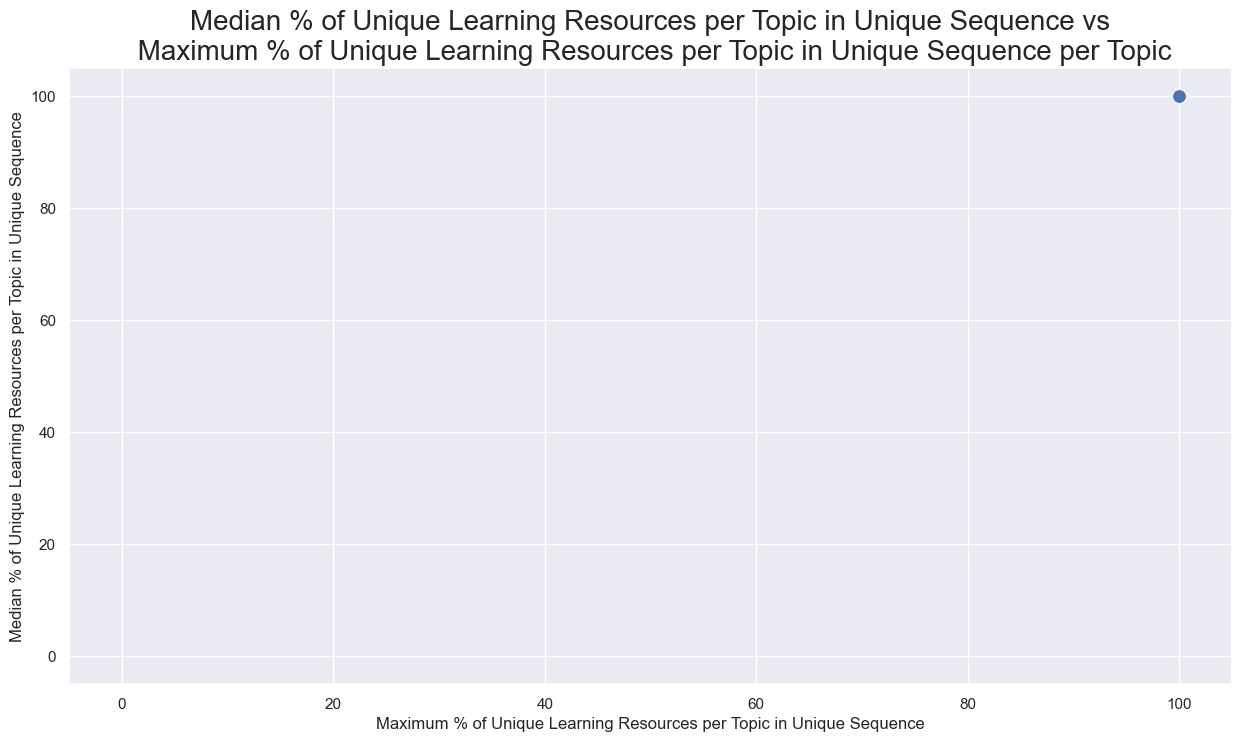

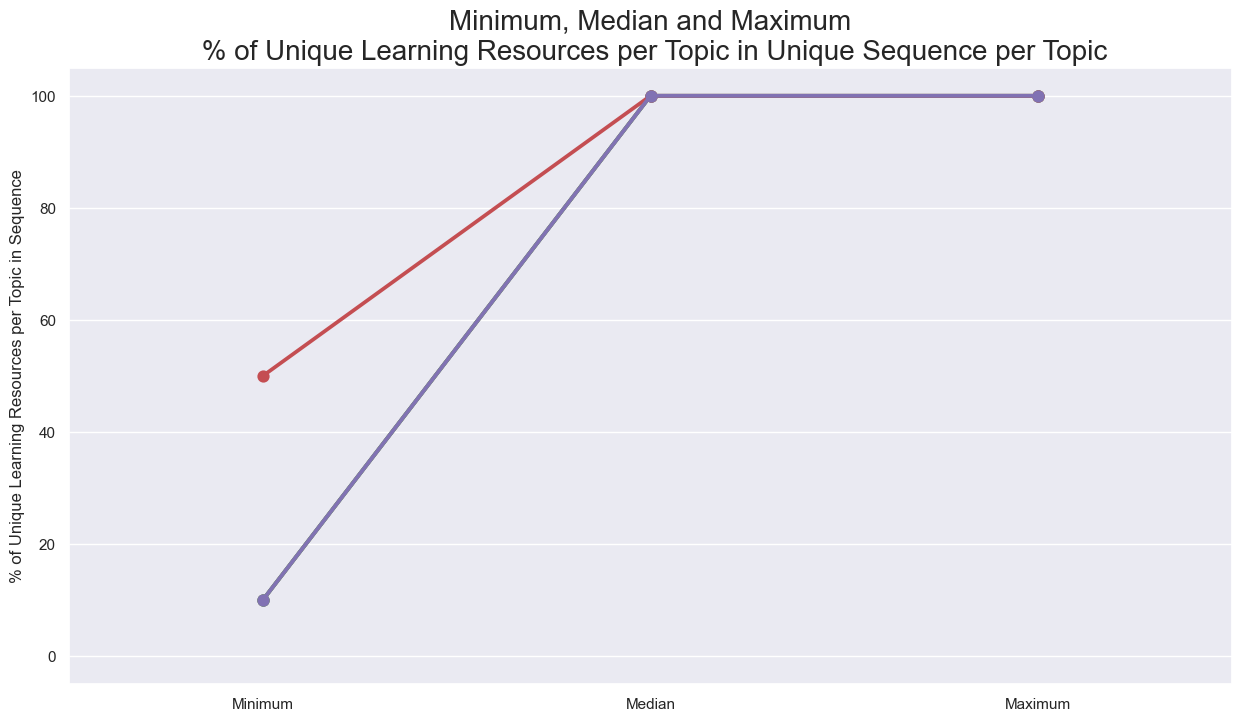

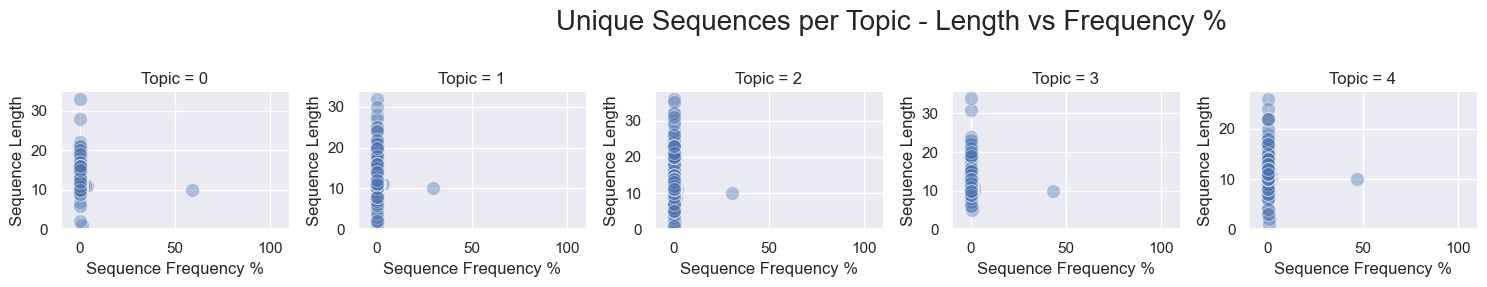

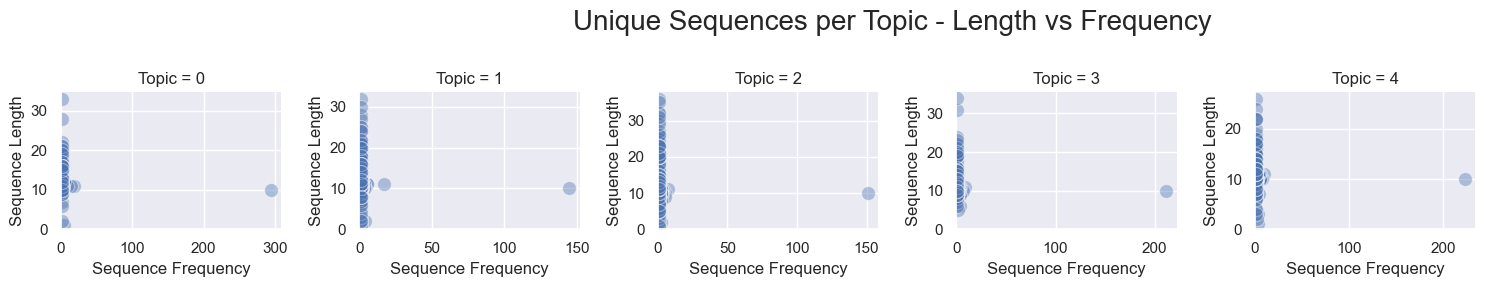

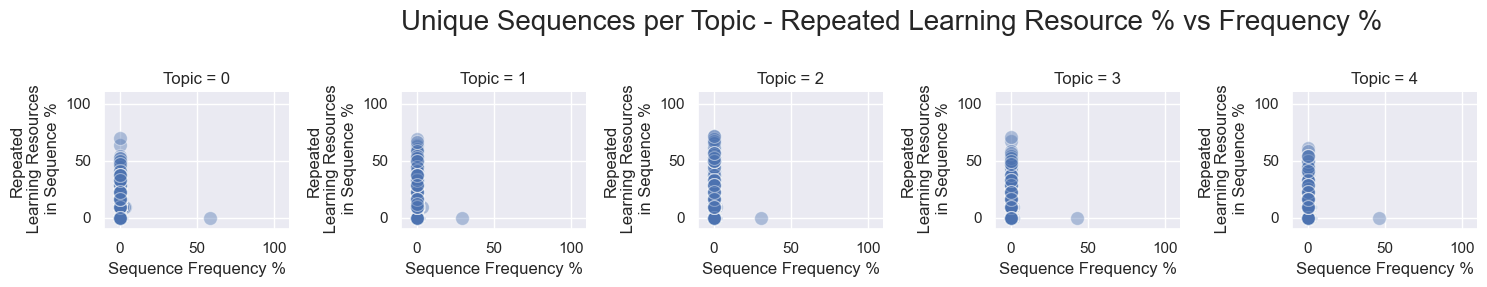

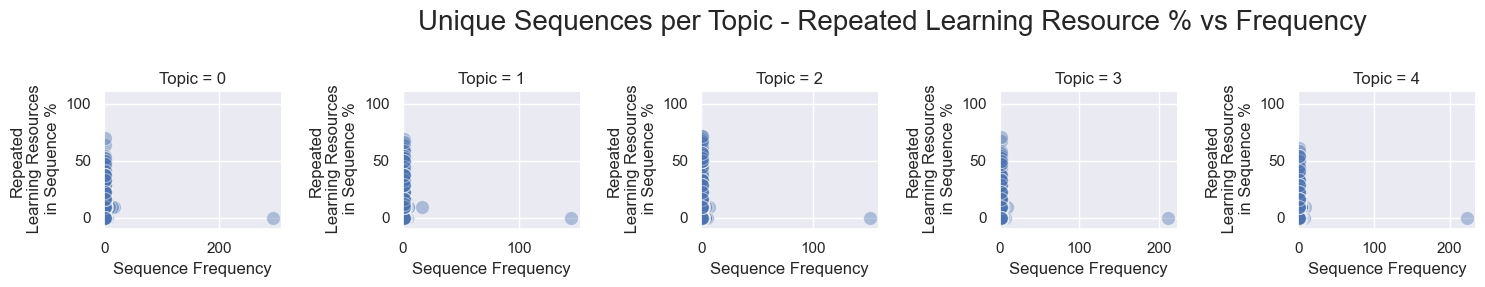

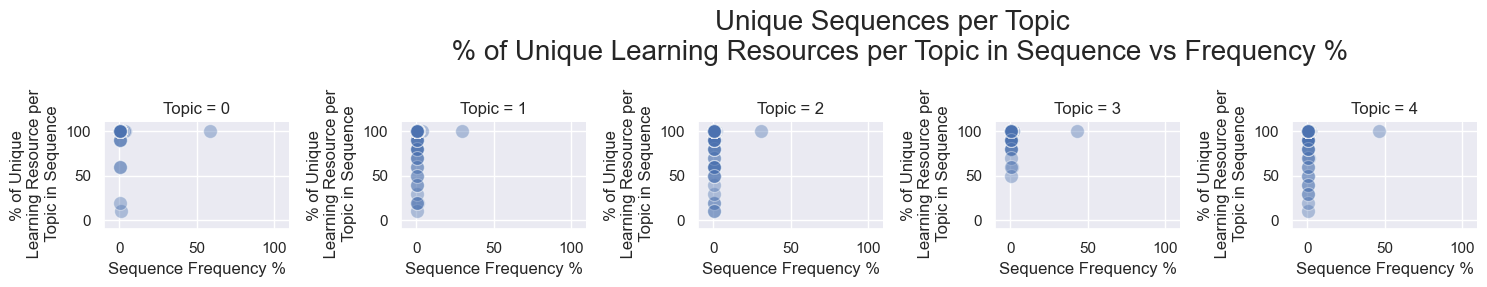

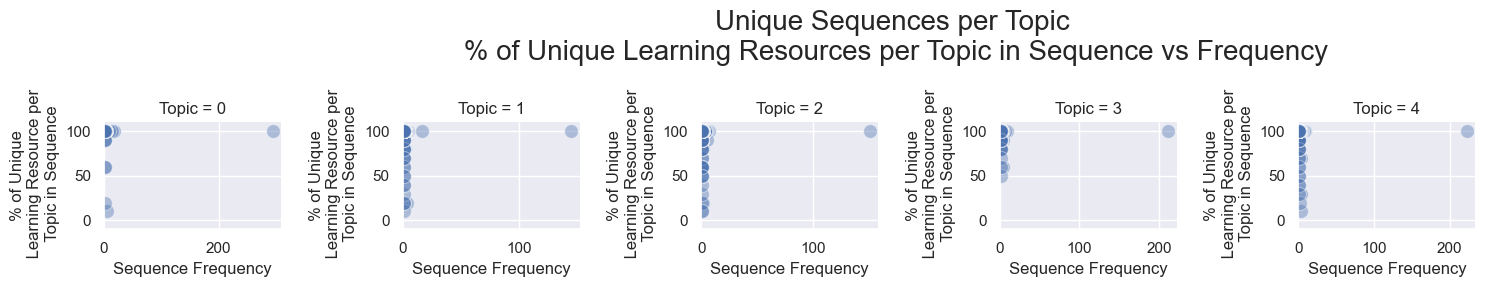

In [30]:
plot_sequence_stats_per_group(learning_activity_sequence_stats_per_group,
                              GROUP_FIELD_NAME_STR)

## Sequence Distance

In [31]:
seq_distances = calculate_sequence_distances(interactions, 
                                             USER_FIELD_NAME_STR, 
                                             GROUP_FIELD_NAME_STR, 
                                             LEARNING_ACTIVITY_FIELD_NAME_STR, 
                                             SEQUENCE_ID_FIELD_NAME_STR)

--------------------
Topic-Field Available:
Calulate Sequence Distances for each Topic
--------------------
--------------------------------------------------
Total number of Topic: 5
--------------------------------------------------
--------------------------------------------------
Final number of Topics: 5
Final number of Users: 506
Final number of interactions: 27806
--------------------------------------------------


100%|██████████| 5/5 [00:01<00:00,  4.49it/s]

--------------------------------------------------
Duration in seconds: 1.1336469650268555
--------------------------------------------------


In [32]:
pickle_write(seq_distances,
             PATH_TO_SEQUENCE_DISTANCES_PICKLE_FOLDER,
             DATASET_NAME + SEQUENCE_DISTANCE_DICT_PER_GROUP_PICKLE_NAME)

100%|██████████| 5/5 [00:00<00:00, 125.08it/s]


****************************************************************************************************
****************************************************************************************************
 
----------------------------------------------------------------------------------------------------
Sequence Distance per Topic:
Base: All User-Sequence Combinations
----------------------------------------------------------------------------------------------------


Plots:


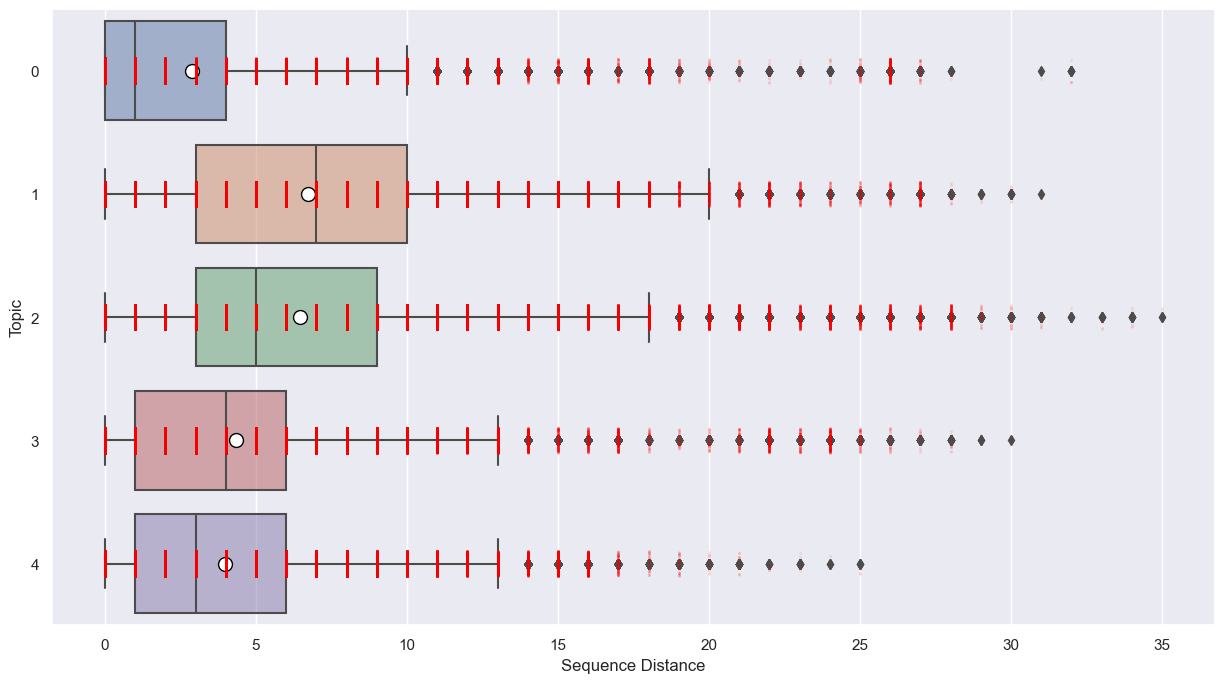

****************************************************************************************************
****************************************************************************************************
 
----------------------------------------------------------------------------------------------------
Normalized Sequence Distance per Topic:
Base: All User-Sequence Combinations
----------------------------------------------------------------------------------------------------


Plots:


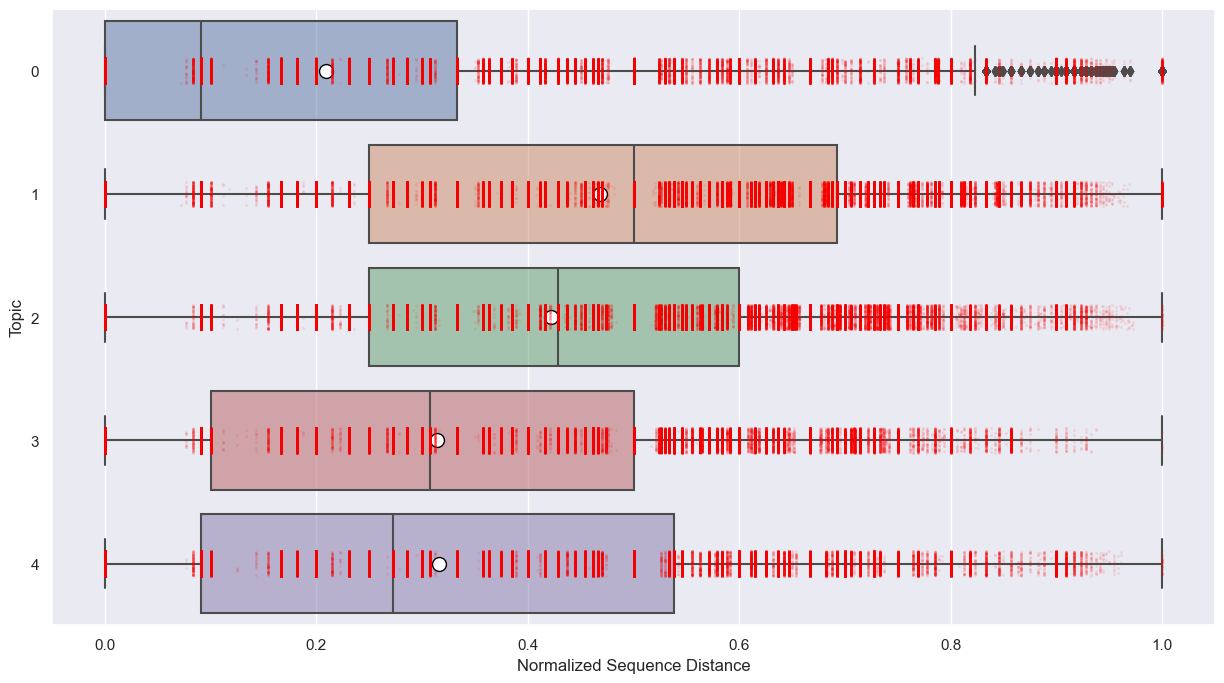

****************************************************************************************************
****************************************************************************************************
 
----------------------------------------------------------------------------------------------------
Mean Sequence Distance per Topic:
----------------------------------------------------------------------------------------------------


Plots:


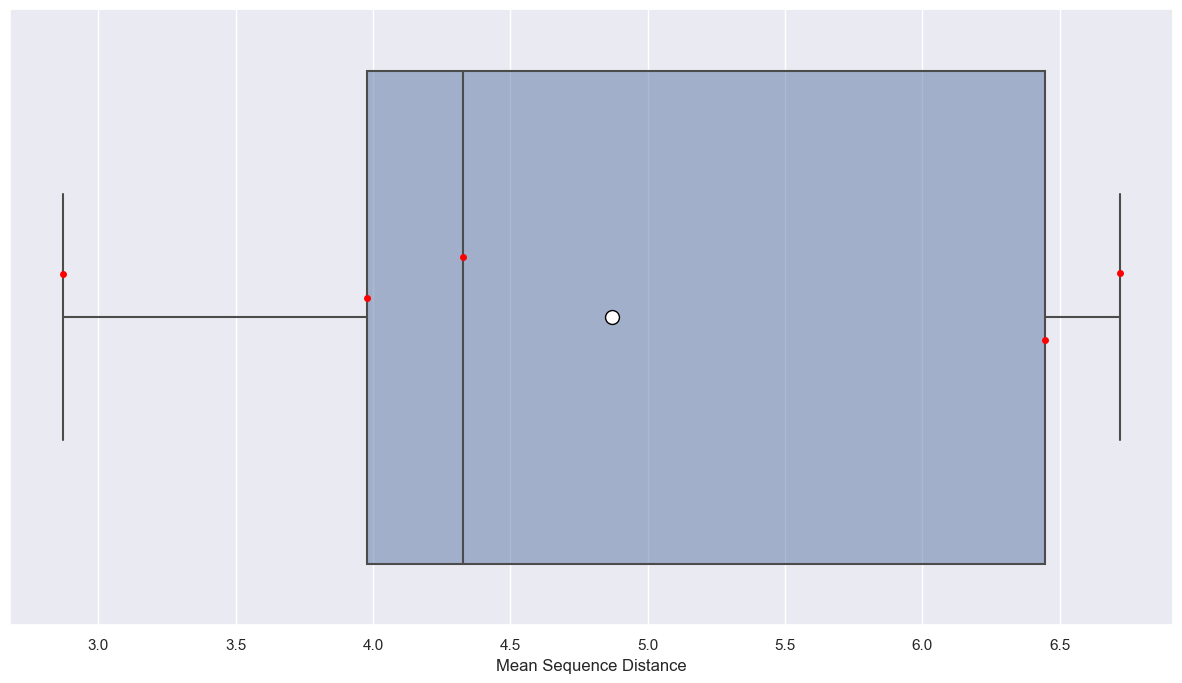

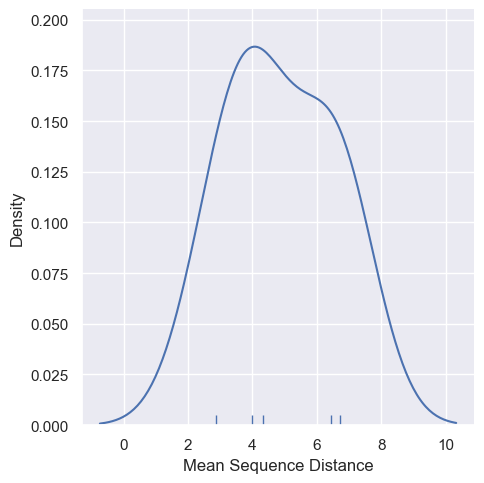

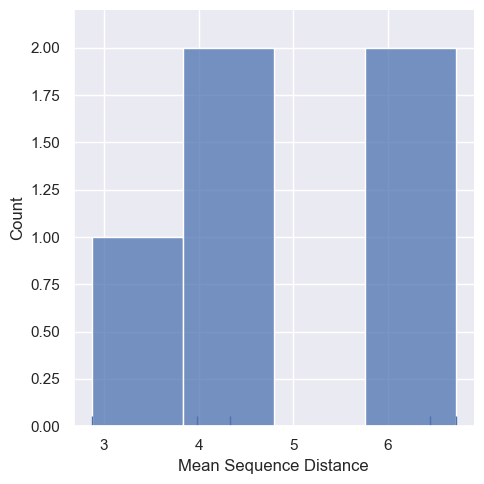

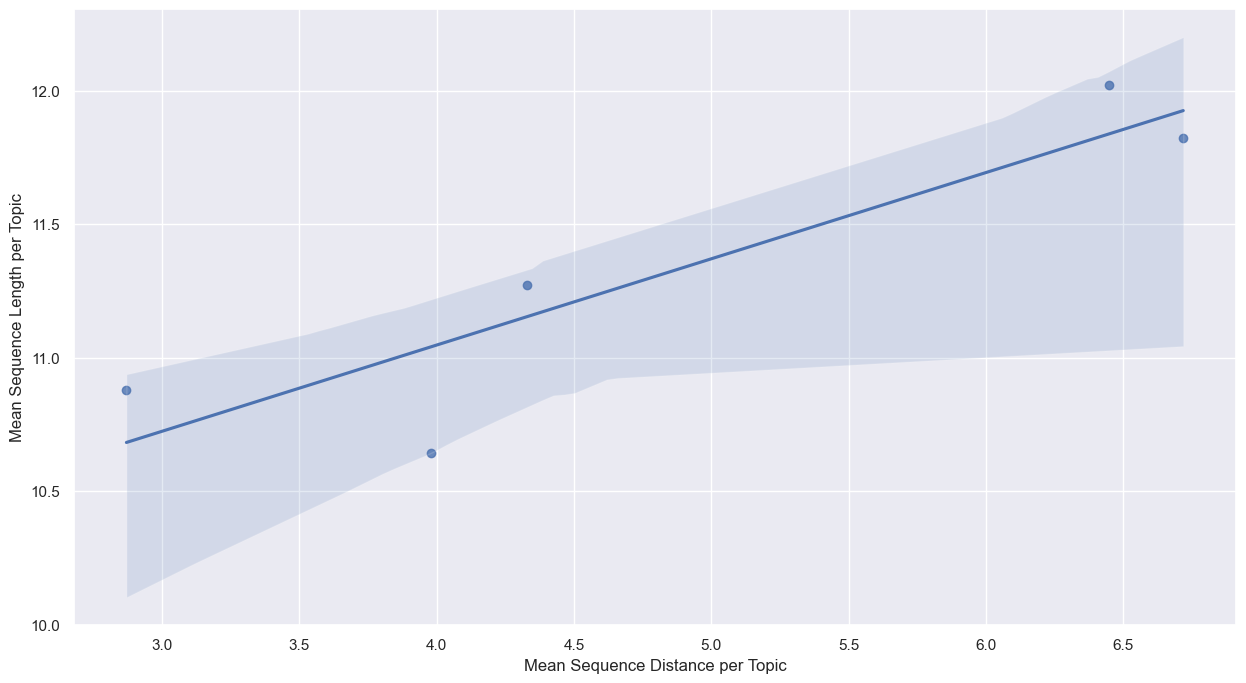

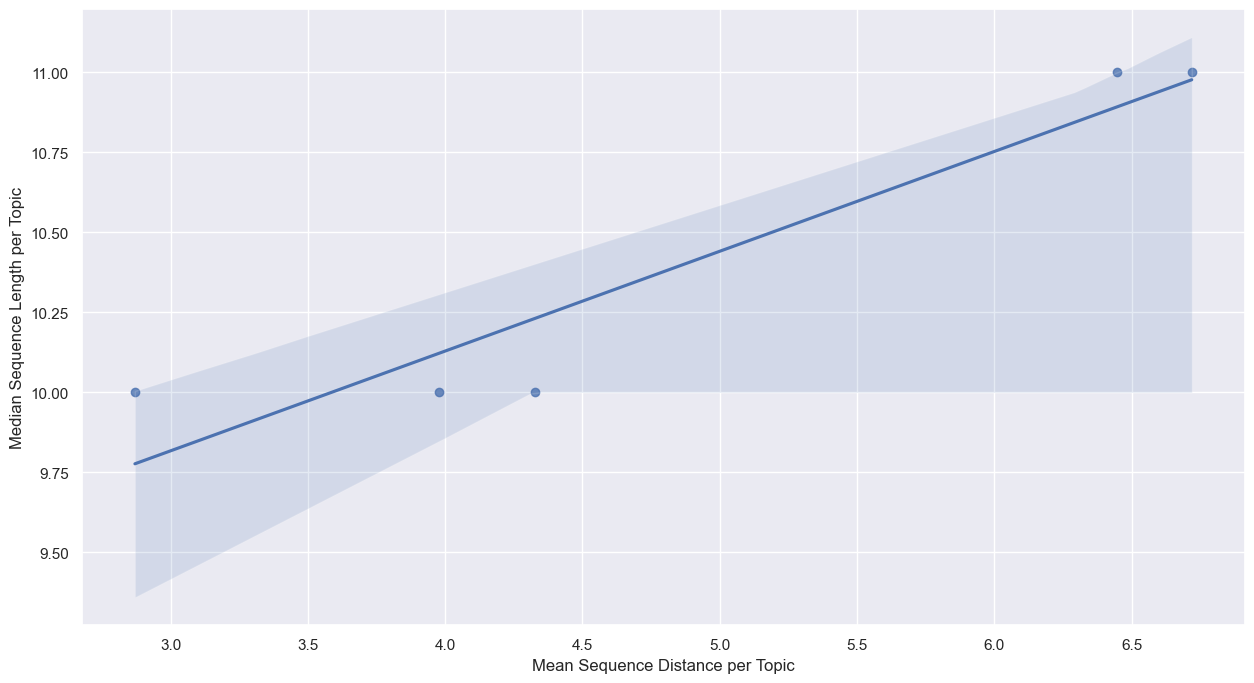

****************************************************************************************************
****************************************************************************************************
 
----------------------------------------------------------------------------------------------------
Median Sequence Distance per Topic:
----------------------------------------------------------------------------------------------------


Plots:


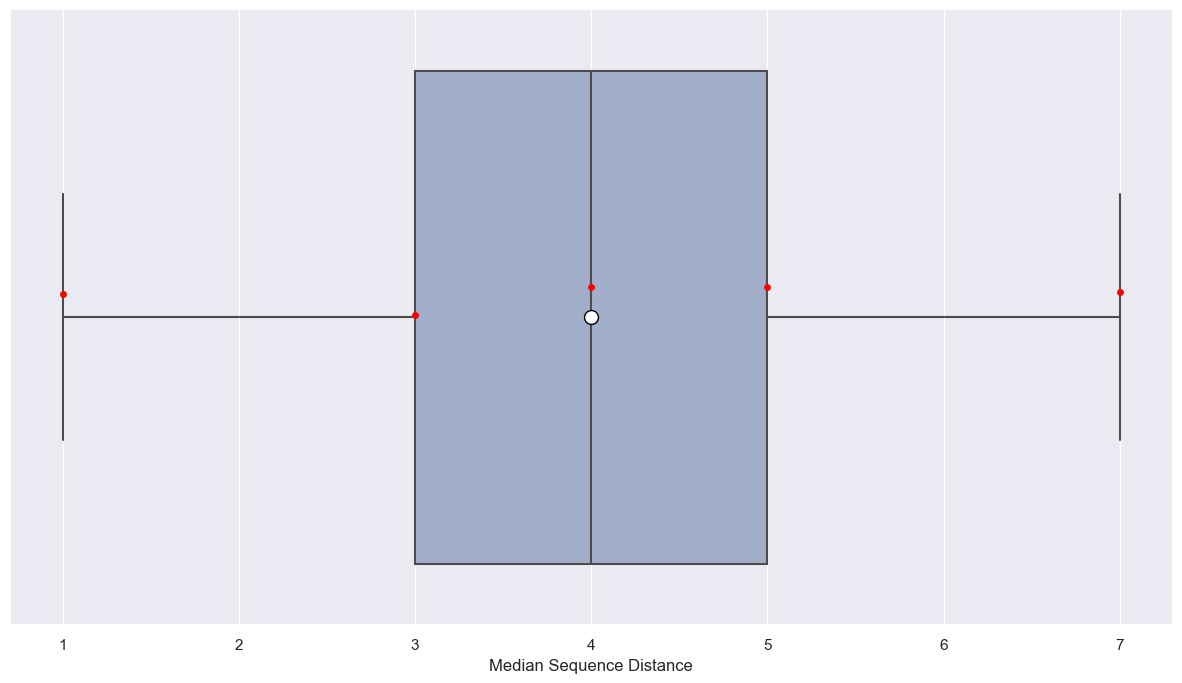

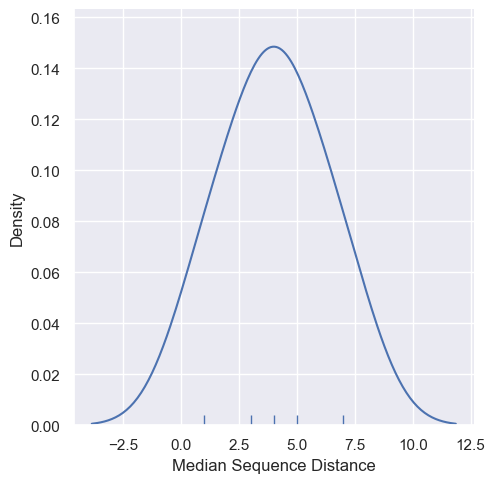

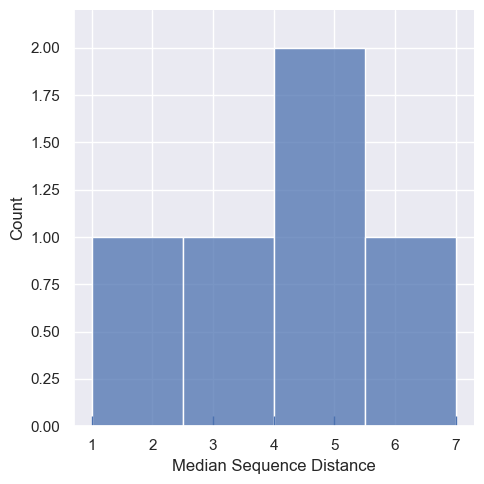

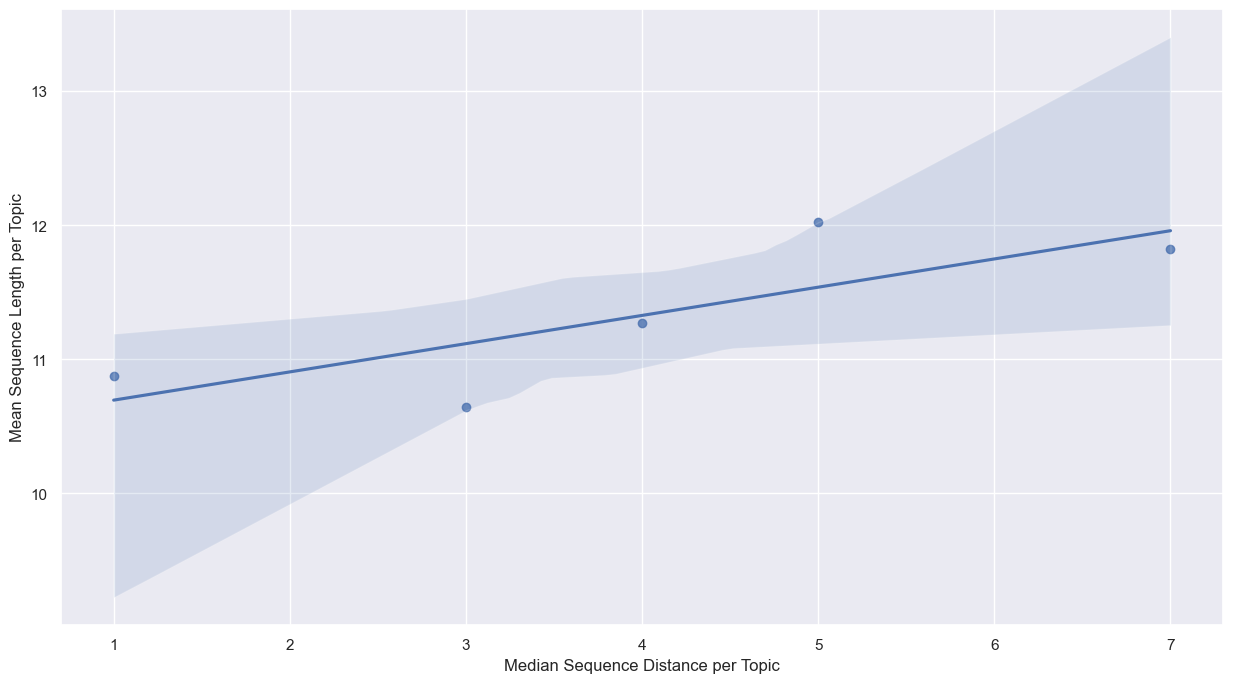

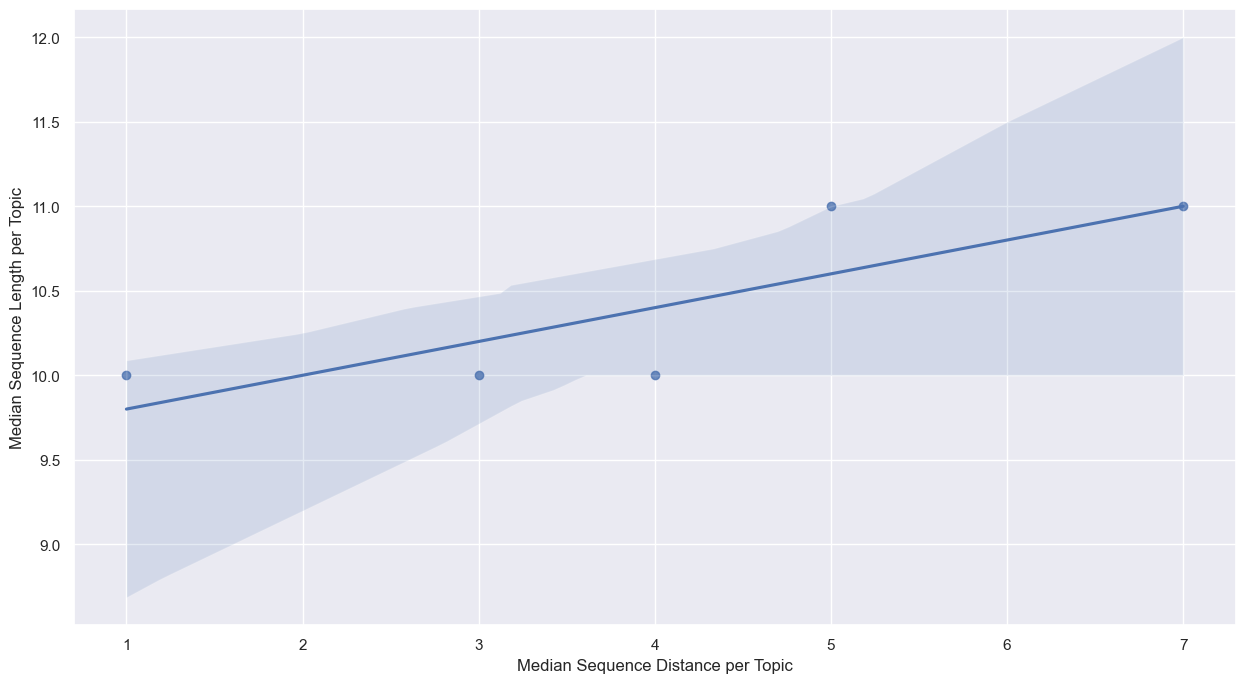

****************************************************************************************************
****************************************************************************************************
 
----------------------------------------------------------------------------------------------------
Mean Normalized Sequence Distance per Topic:
----------------------------------------------------------------------------------------------------


Plots:


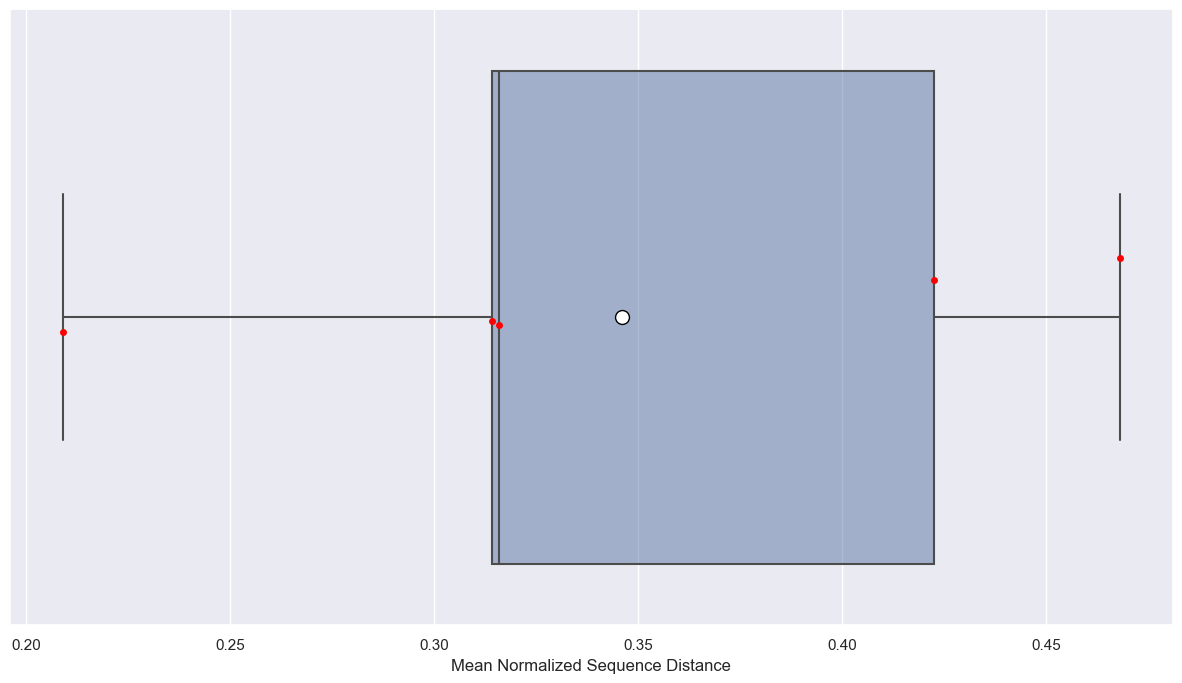

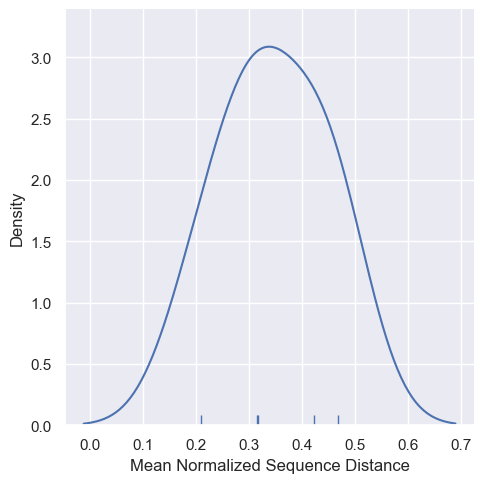

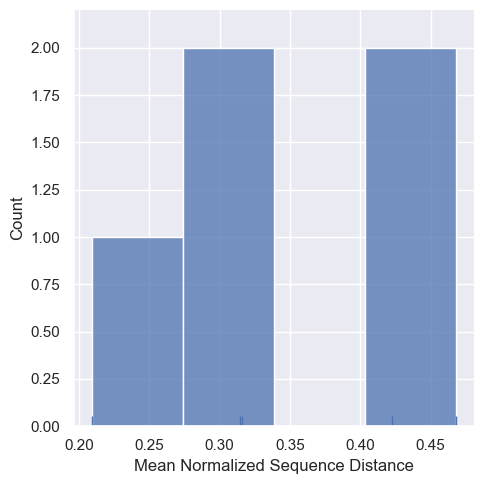

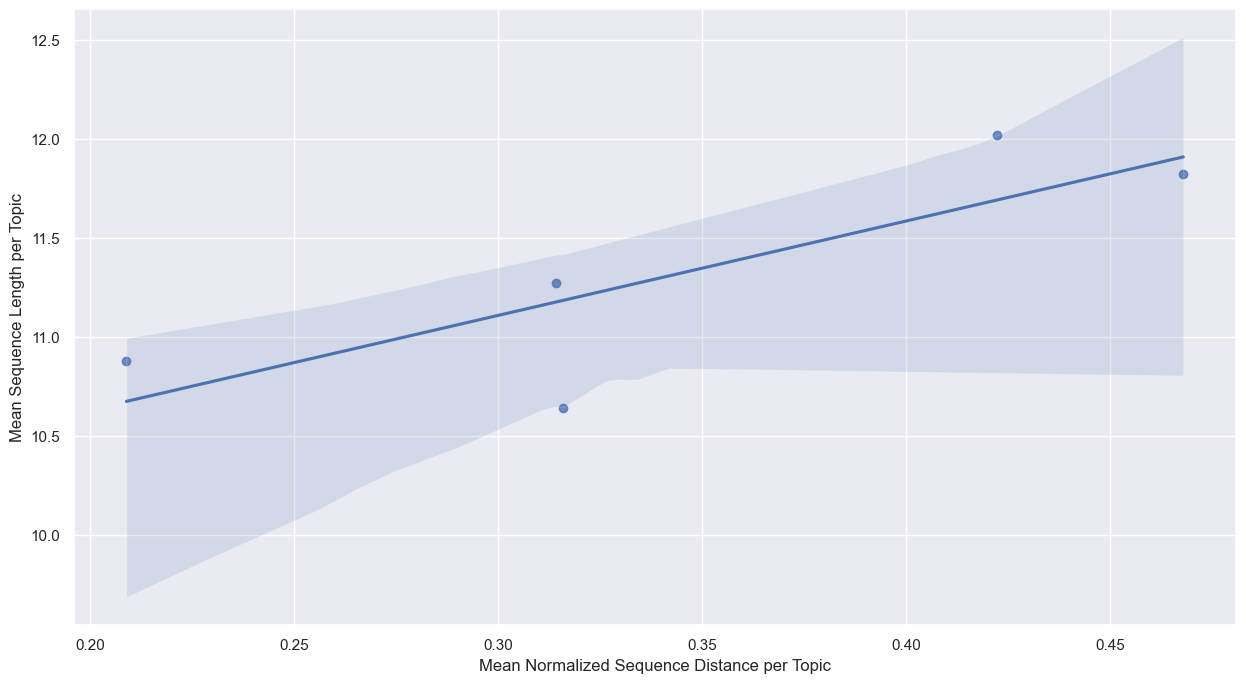

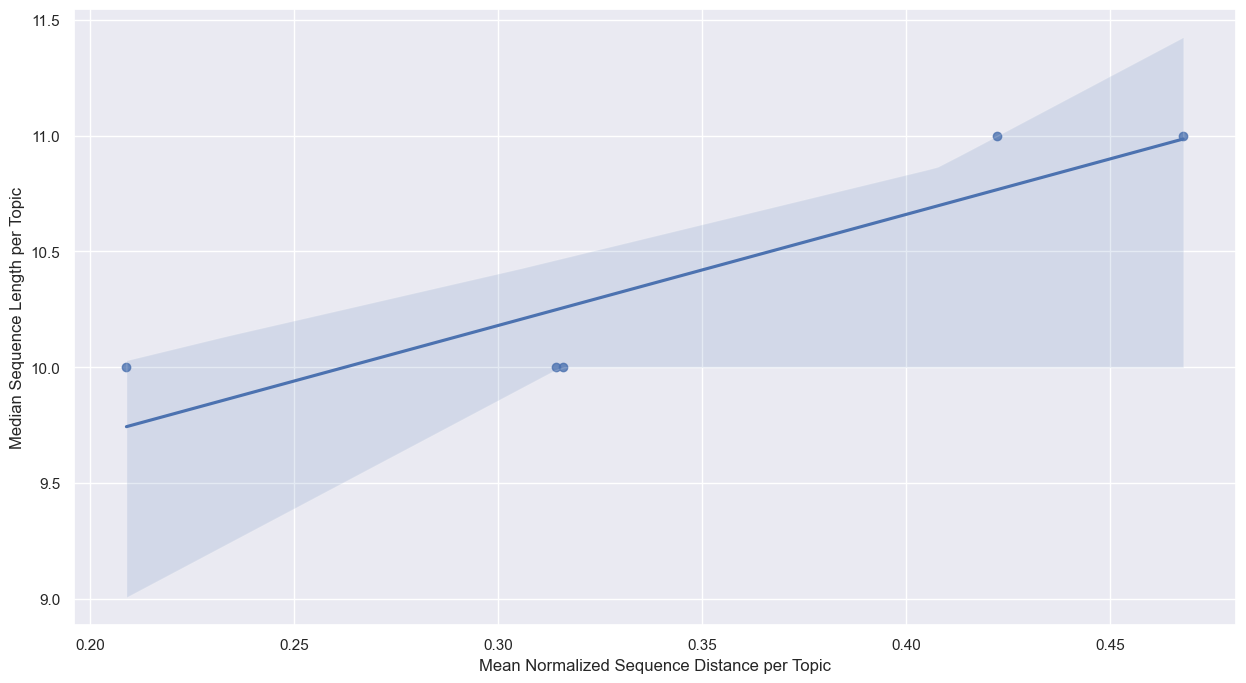

****************************************************************************************************
****************************************************************************************************
 
----------------------------------------------------------------------------------------------------
Median Normalized Sequence Distance per Topic:
----------------------------------------------------------------------------------------------------


Plots:


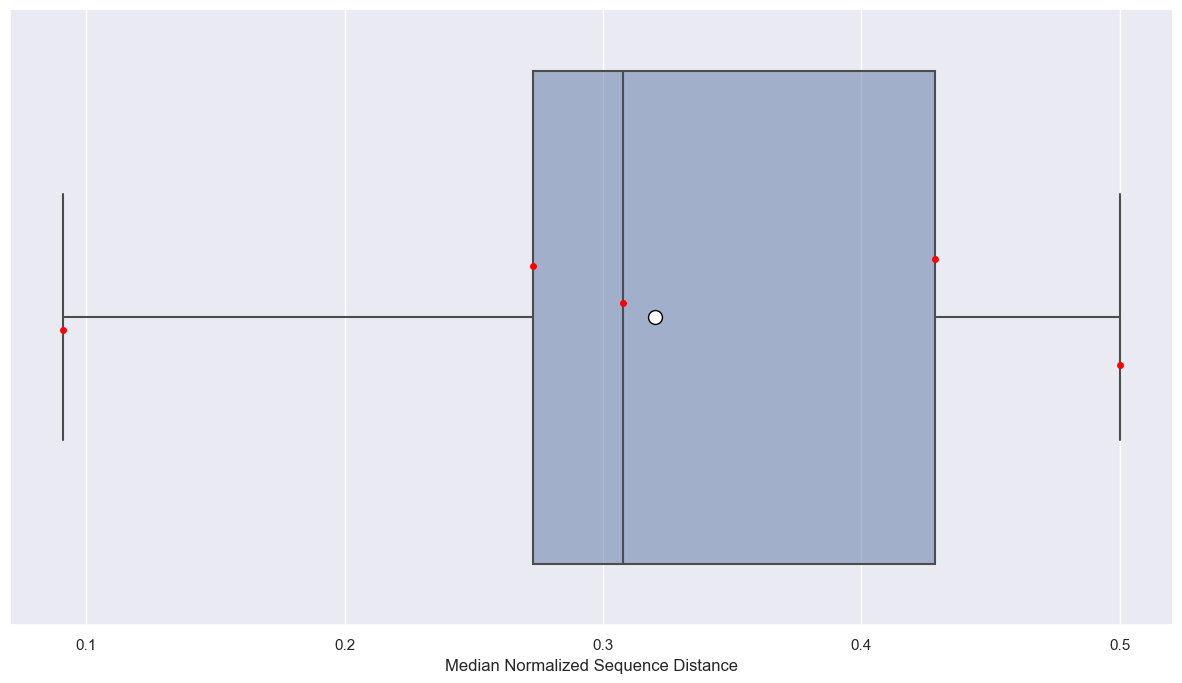

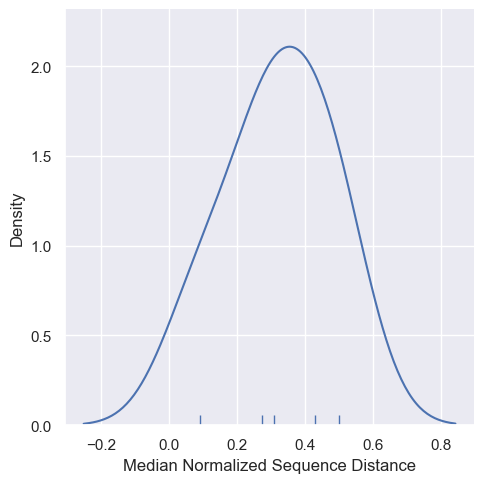

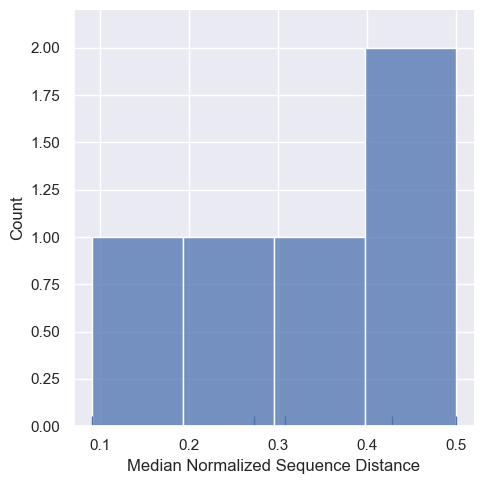

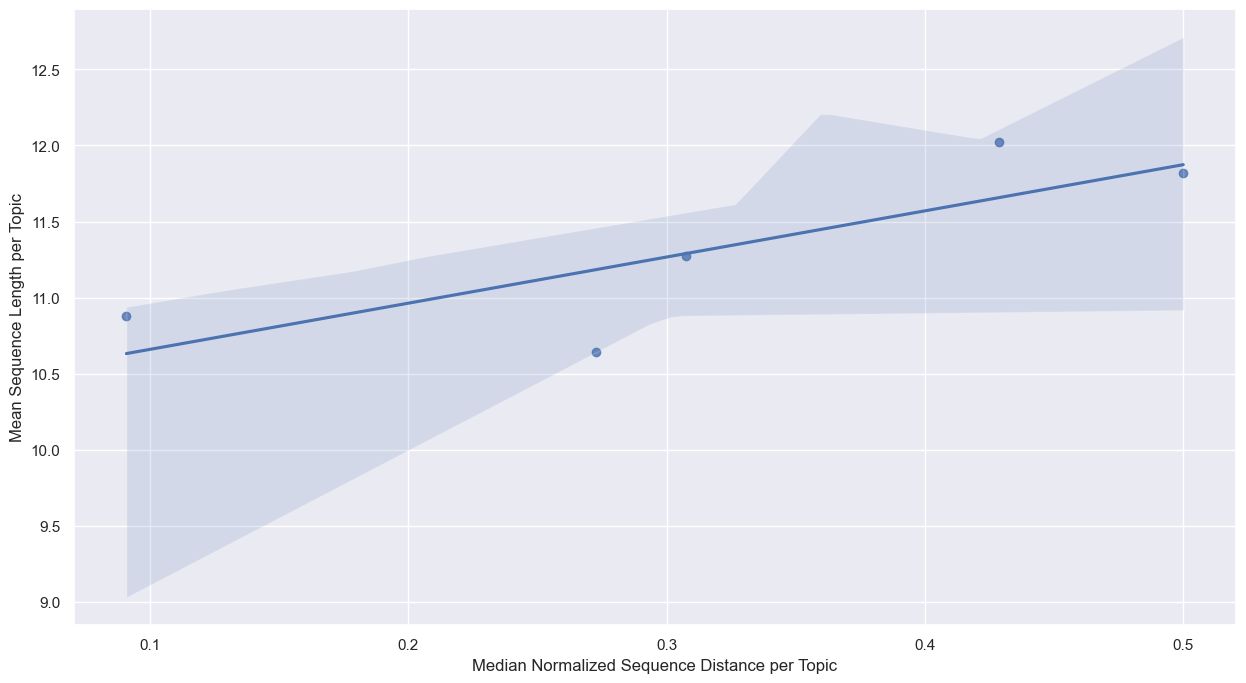

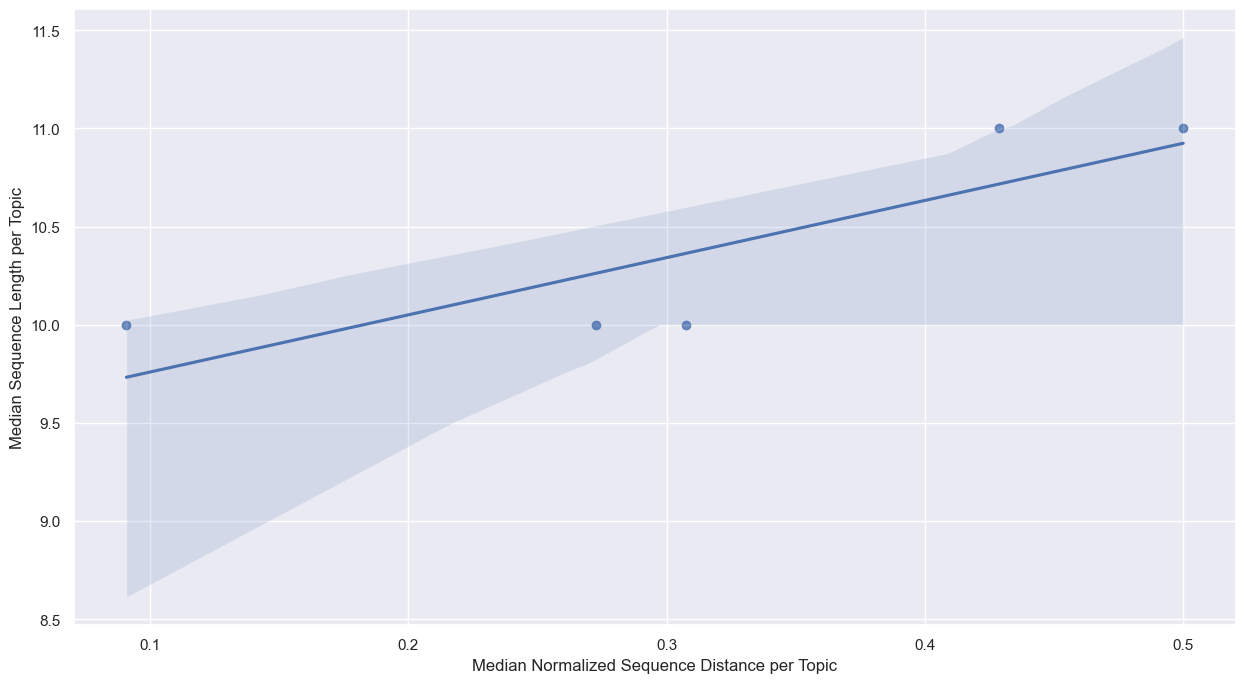

****************************************************************************************************
****************************************************************************************************
 


In [33]:
plot_sequence_distances(seq_distances)

****************************************************************************************************
****************************************************************************************************
 
----------------------------------------------------------------------------------------------------
Sequence Distance Matrix per Topic:
----------------------------------------------------------------------------------------------------


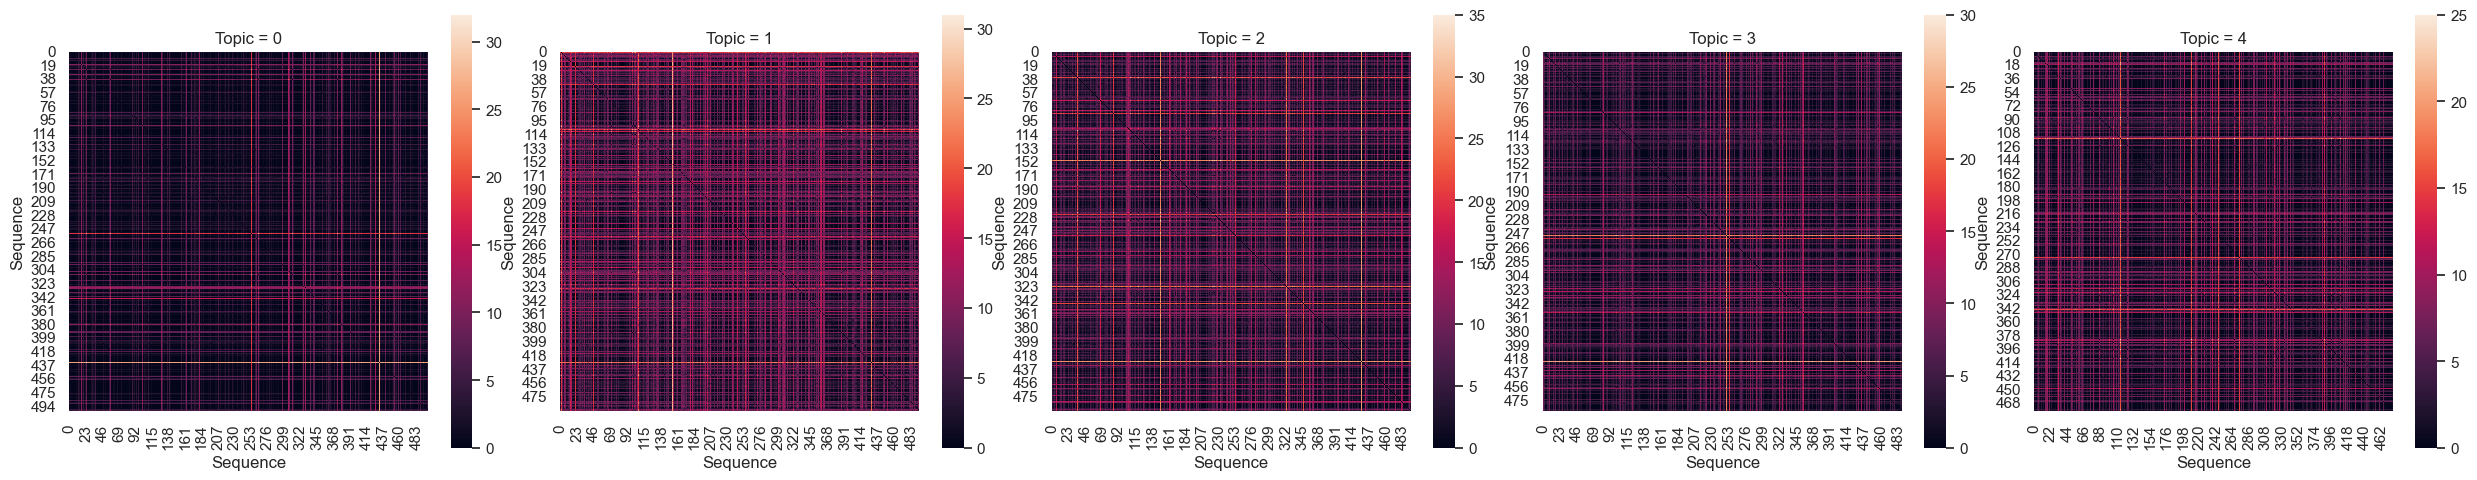

In [34]:
plot_sequence_distance_matrix_all_group(seq_distances,
                                        False,
                                        5)

****************************************************************************************************
****************************************************************************************************
 
----------------------------------------------------------------------------------------------------
Normalized Sequence Distance Matrix per Topic:
----------------------------------------------------------------------------------------------------


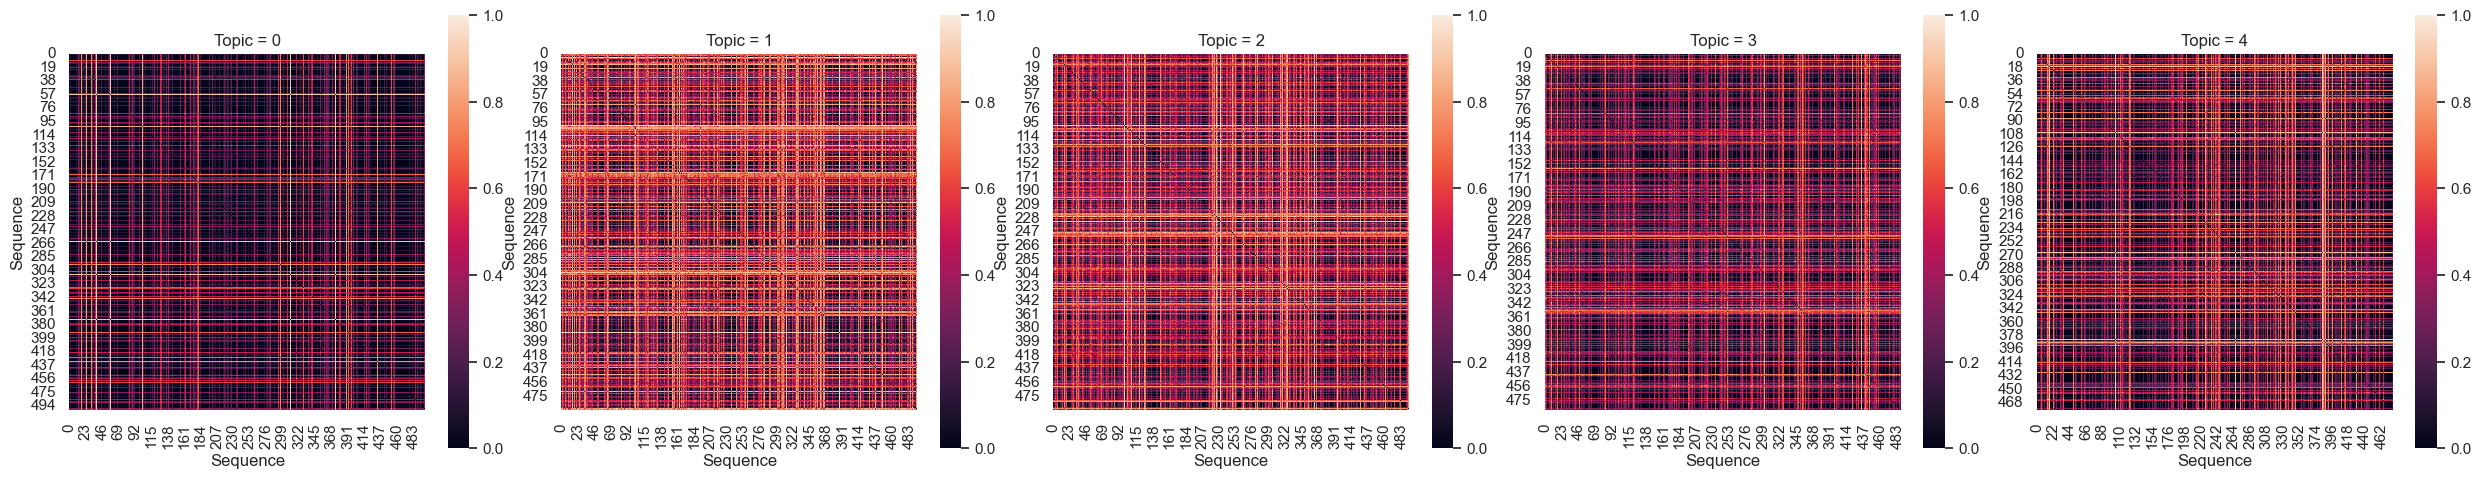

In [35]:
plot_sequence_distance_matrix_all_group(seq_distances,
                                        True,
                                        5)

## Clustering of Sequence Distances and Testing for Evaluation Metric Central Tendency Differences between Clusters 

****************************************************************************************************
****************************************************************************************************
 
----------------------------------------------------------------------------------------------------
Cluster Analysis - Topic Selection Criteria
----------------------------------------------------------------------------------------------------
 
Unique vs Total Number of Sequences per Topic:


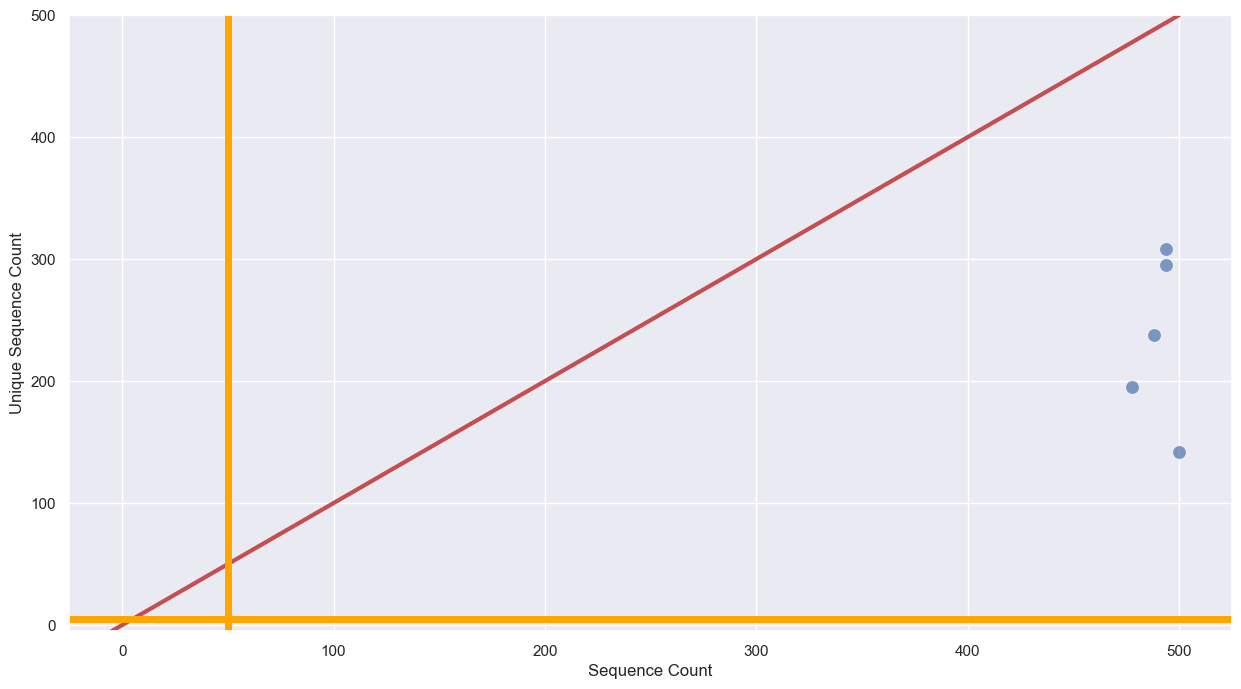

Normalized Sequence Distance per Topic:
Base: All User-Sequence Combinations


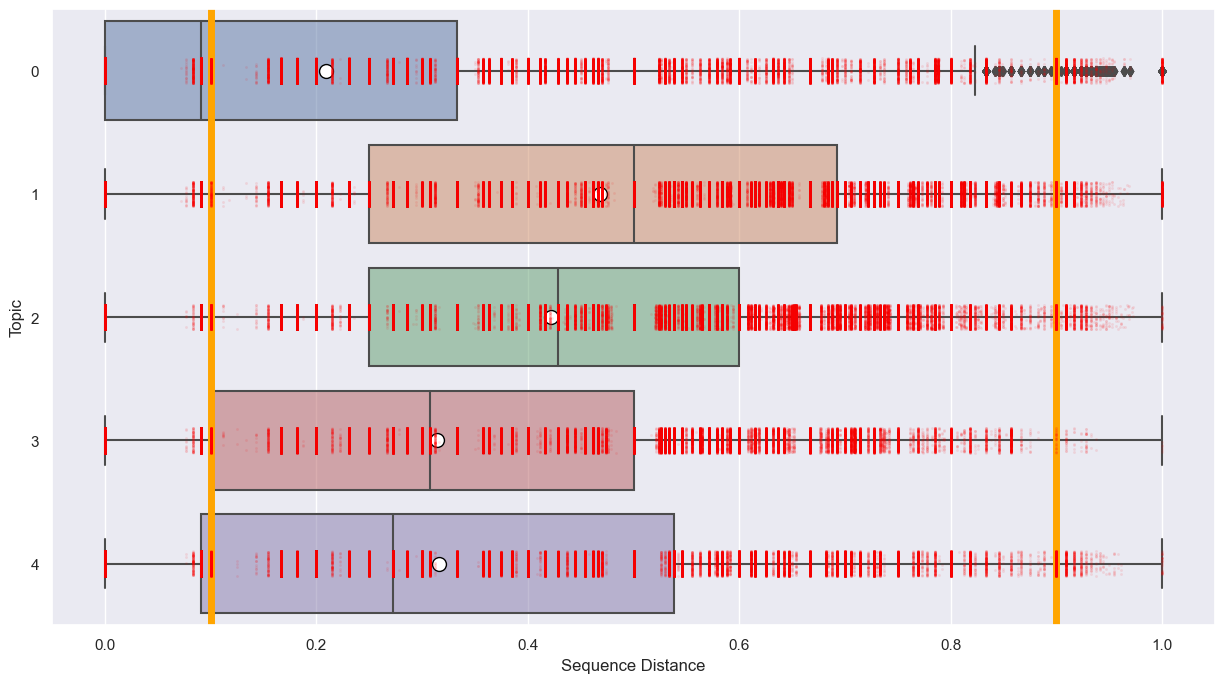

 
****************************************************************************************************
****************************************************************************************************


In [36]:
ClusterAnalysisPlotGroupSelectionCriteria(DATASET_NAME,
                                          learning_activity_sequence_stats_per_group,
                                          seq_distances,
                                          True,
                                          50,
                                          5,
                                          (0.1, 0.9)).display_group_selection_criteria()

In [37]:
cluster_eval = ClusterEvaluation(DATASET_NAME, 
                                 interactions, 
                                 USER_FIELD_NAME_STR, 
                                 GROUP_FIELD_NAME_STR, 
                                 EVALUATION_GROUP_SCORE_HIGHEST_ALL_LEARNING_ACTIVITIES_MEAN_FIELD_NAME_STR,
                                 seq_distances,
                                 True,
                                 50,
                                 5,
                                 (0.1, 0.9),
                                 hdbscan.HDBSCAN,
                                 0.025,
                                 0.05,
                                 0.05,
                                 metric='precomputed',
                                 cluster_selection_method='eom')

In [38]:
cluster_eval.cluster_sequences_and_test_eval_metric_diff()
cluster_eval.aggregate_sequence_clustering_and_eval_metric_diff_test_over_groups()

100%|██████████| 5/5 [00:00<00:00, 39.21it/s]


In [39]:
pickle_write(cluster_eval,
             PATH_TO_SEQUENCE_CLUSTER_EVALUATION_METRIC_ANALYSIS_PICKLE_FOLDER,
             DATASET_NAME + SEQUENCE_CLUSTER_EVALUATION_METRIC_ANALYSIS_PER_GROUP_OBJECT_PICKLE_NAME)

In [40]:
cluster_stats_per_group = cluster_eval.cluster_stats_per_group
cluster_eval_metric_central_tendency_differences_per_group = cluster_eval.cluster_eval_metric_central_tendency_differences_per_group
aggregate_sequence_clustering_and_eval_metric_diff_test = cluster_eval.aggregate_sequence_clustering_and_eval_metric_diff_test
group_cluster_analysis_inclusion_status = cluster_eval.group_cluster_analysis_inclusion_status
min_cluster_size_correction_df = cluster_eval.min_cluster_size_correction_df

In [41]:
cluster_stats_per_group.head(1)

Dataset Name Topic  Number of Sequences  Number of Unique Sequences  \
0   csedm_2021     0                  500                         142   

   Percentage Clustered Cluster  Number of Sequences per Cluster  \
0                  74.4      -1                              128   

   Number of Unique Sequences per Cluster  \
0                                     116   

                                                User  \
0  [107, 108, 11, 111, 114, 116, 119, 120, 127, 1...   

                                         Sequence ID  \
0  [2, 3, 4, 5, 6, 8, 10, 11, 13, 14, 15, 16, 17,...   

                                     Sequence Length  \
0  [10, 11, 12, 12, 14, 14, 11, 2, 13, 13, 10, 10...   

                                      Sequence Array  Mean Evaluation Metric  \
0  [(4, 5, 8, 6, 0, 1, 9, 2, 7, 3), (4, 5, 8, 7, ...                0.835129   

   Median Evaluation Metrice  Min Evaluation Metric Value  \
0                   0.889153                          0.0   

   Max Evaluation Metric Value  STD Evaluation Metric Value  \
0                          1.0                     0.210356   

   IQR Evaluation Metric Value  
0                     0.197641

In [42]:
cluster_eval_metric_central_tendency_differences_per_group.head(1)

Dataset Name Topic  Number of Sequences  Number of Unique Sequences  \
0   csedm_2021     0                  500                         142   

   Mean Normalized Sequence Distance  Median Normalized Sequence Distance  \
0                           0.208946                             0.090909   

   Min Normalized Sequence Distance  Max Normalized Sequence Distance  \
0                               0.0                               1.0   

   STD Normalized Sequence Distance  IQR Normalized Sequence Distance  \
0                          0.239604                          0.333333   

  Clustering Algorithm  HDBSCAN Min Cluster Size  Number of Clusters  \
0              HDBSCAN                        12                   4   

   Percentage Clustered  Mean Cluster Size  Median Cluster Size  \
0                  74.4               93.0                 28.0   

   Min Cluster Size  Max Cluster Size  STD Cluster Size  IQR Cluster Size  \
0                22               294        116.150764              77.0   

             Cluster Comparision Evaluation Metric  \
0  Topic Highest Score All Learning Resources Mean   

   Normality Test Shapiro P-Value  Normality Test Jarque-Bera P-Value  \
0                    1.714146e-28                                 0.0   

   Normality Test D'Agostion-Pearson P-Value  \
0                               6.679556e-48   

   Homoscedasticity Test Levene P-Value  \
0                          6.781587e-40   

   Homoscedasticity Test Bartlett P-Value  \
0                           2.209536e-164   

  Central Tendency Differences Test Type  \
0                    kruskal_wallis_test   

   Central Tendency Differences Test P-Value  
0                               7.519329e-55

In [43]:
aggregate_sequence_clustering_and_eval_metric_diff_test.head(1)

Unfiltered Number of Topics  Number of Topics  \
Dataset Name                                                  
csedm_2021                              5                 5   

              Percentage of Unfiltered Topics  \
Dataset Name                                    
csedm_2021                                1.0   

              Number of Topics with Multiple Clusters  \
Dataset Name                                            
csedm_2021                                          5   

              Mean Number of Sequences per Topic  \
Dataset Name                                       
csedm_2021                                 490.8   

              Median Number of Sequences per Topic  \
Dataset Name                                         
csedm_2021                                   494.0   

              Min Number of Sequences per Topic  \
Dataset Name                                      
csedm_2021                                  478   

              Max Number of Sequences per Topic  \
Dataset Name                                      
csedm_2021                                  500   

              STD Number of Sequences per Topic  \
Dataset Name                                      
csedm_2021                             8.318654   

              IQR Number of Sequences per Topic  \
Dataset Name                                      
csedm_2021                                  6.0   

              Mean Number of Unique Sequences per Topic  \
Dataset Name                                              
csedm_2021                                        235.6   

              Median Number of Unique Sequences per Topic  \
Dataset Name                                                
csedm_2021                                          238.0   

              Min Number of Unique Sequences per Topic  \
Dataset Name                                             
csedm_2021                                         142   

              Max Number of Unique Sequences per Topic  \
Dataset Name                                             
csedm_2021                                         308   

              STD Number of Unique Sequences per Topic  \
Dataset Name                                             
csedm_2021                                   69.255325   

              IQR Number of Unique Sequences per Topic  \
Dataset Name                                             
csedm_2021                                       100.0   

              Mean Number of Clusters per Topic  \
Dataset Name                                      
csedm_2021                                  4.8   

              Median Number of Clusters per Topic  \
Dataset Name                                        
csedm_2021                                    5.0   

              Min Number of Clusters per Topic  \
Dataset Name                                     
csedm_2021                                   4   

              Max Number of Clusters per Topic  \
Dataset Name                                     
csedm_2021                                   6   

              STD Number of Clusters per Topic  \
Dataset Name                                     
csedm_2021                             0.83666   

              IQR Number of Clusters per Topic  \
Dataset Name                                     
csedm_2021                                 1.0   

              Mean Number of Sequences per Topic with Multiple Clusters  \
Dataset Name                                                              
csedm_2021                                                490.8           

              Median Number of Sequences per Topic with Multiple Clusters  \
Dataset Name                                                                
csedm_2021                                                494.0             

              Min Number of Sequences per Topic with Multiple Clusters  \
Dataset Name                                            

In [44]:
group_cluster_analysis_inclusion_status.head(1)

Dataset Name Topic  Topic Included in Cluster Analysis  \
0   csedm_2021     0                                True   

   Minium Sequence Number Threshold Value  Minium Sequence Number Violated  \
0                                      50                            False   

   Minium Unique Sequence Number Threshold Value  \
0                                              5   

   Minium Unique Sequence Number Violated  \
0                                   False   

  Sequence Distance Range Threshold Value  Sequence Distance Range Violated  
0                              (0.1, 0.9)                             False

In [45]:
min_cluster_size_correction_df.head(1)

Dataset Name Topic  Minimum Cluster Size Is Corrected  \
0   csedm_2021     0                              False   

   Uncorrected Minimum Cluster Size  Corrected Minimum Cluster Size  
0                                12                              12

****************************************************************************************************
****************************************************************************************************
 
----------------------------------------------------------------------------------------------------
Cluster Analysis - Included Topics
----------------------------------------------------------------------------------------------------
 
5 Topics out of 5 are included in Cluster Analysis:


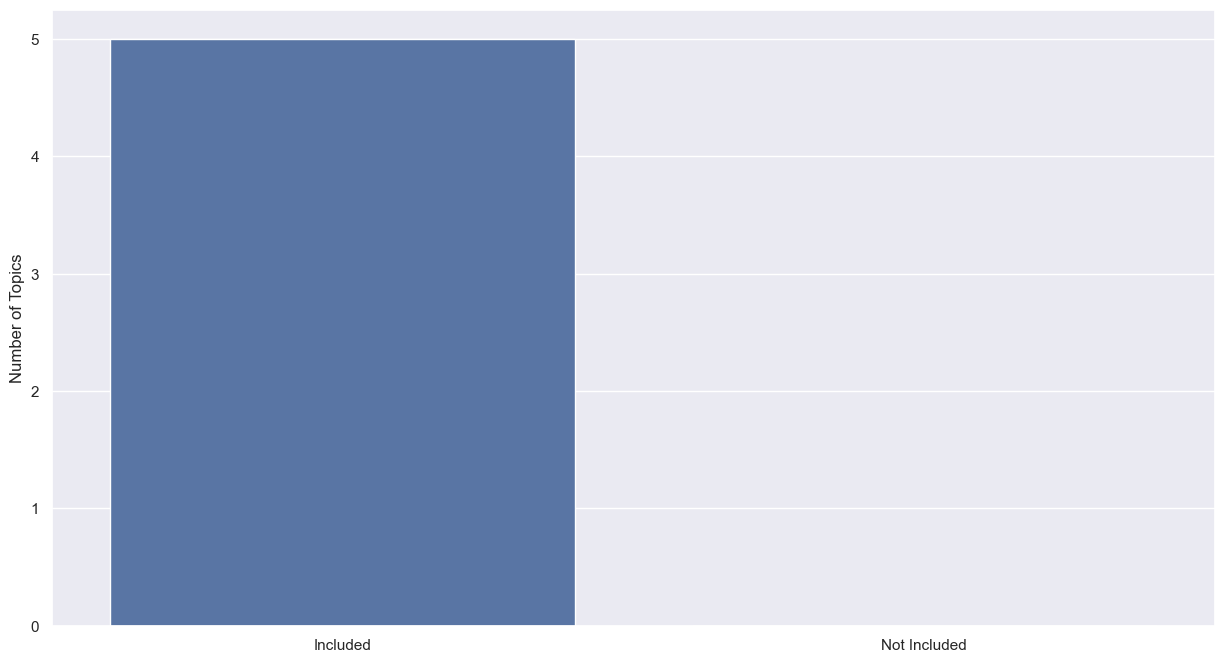

100.0% of Topics are included in Cluster Analysis:


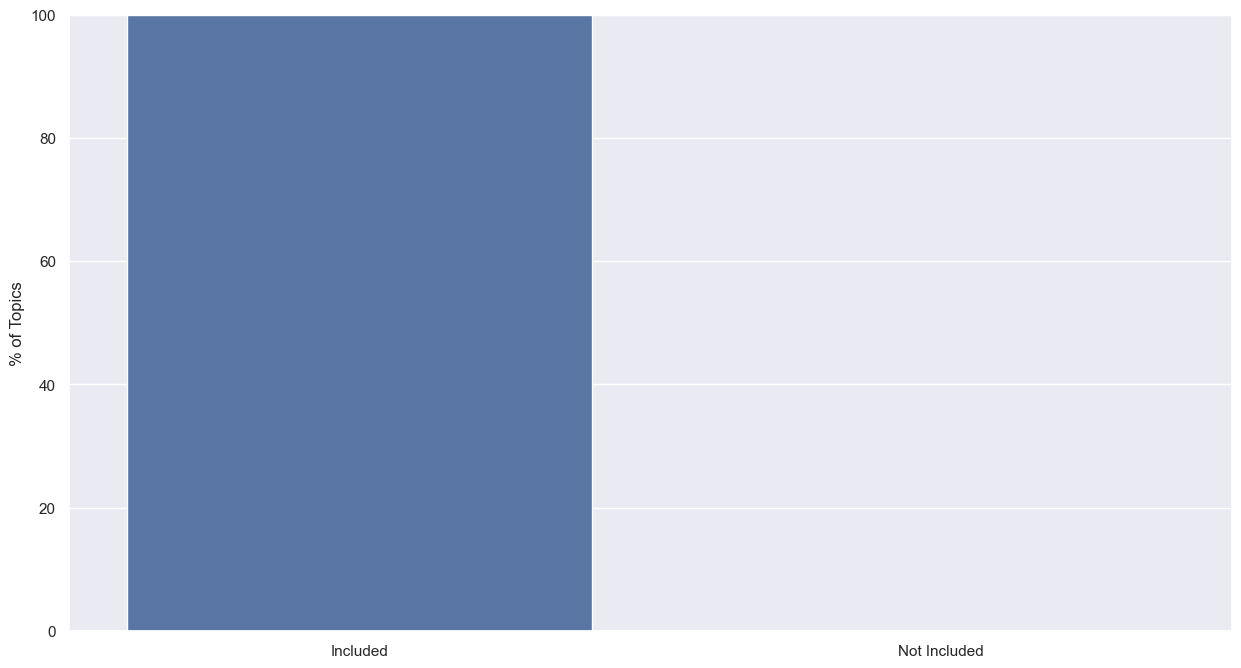

In [46]:
cluster_eval.display_included_groups()

****************************************************************************************************
****************************************************************************************************
 
----------------------------------------------------------------------------------------------------
Number of Clusters per Topic:
----------------------------------------------------------------------------------------------------


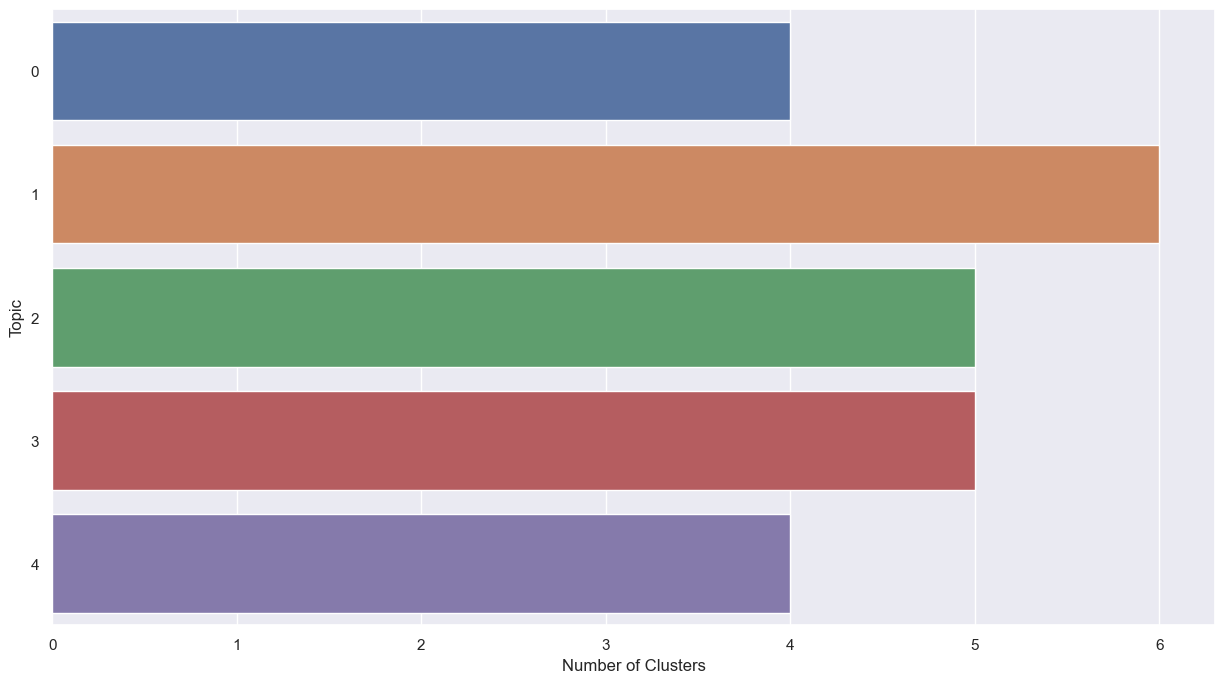

In [47]:
cluster_eval.display_number_of_clusters_all_group()

In [48]:
cluster_eval.print_number_of_clusters_all_group()

****************************************************************************************************
****************************************************************************************************
 
----------------------------------------------------------------------------------------------------
Number of Clusters for each Topic:
----------------------------------------------------------------------------------------------------
Topic  Number of Clusters
    0                   4
    4                   4
    2                   5
    3                   5
    1                   6


****************************************************************************************************
****************************************************************************************************
 
----------------------------------------------------------------------------------------------------
Min Cluster Size per Topic:
----------------------------------------------------------------------------------------------------


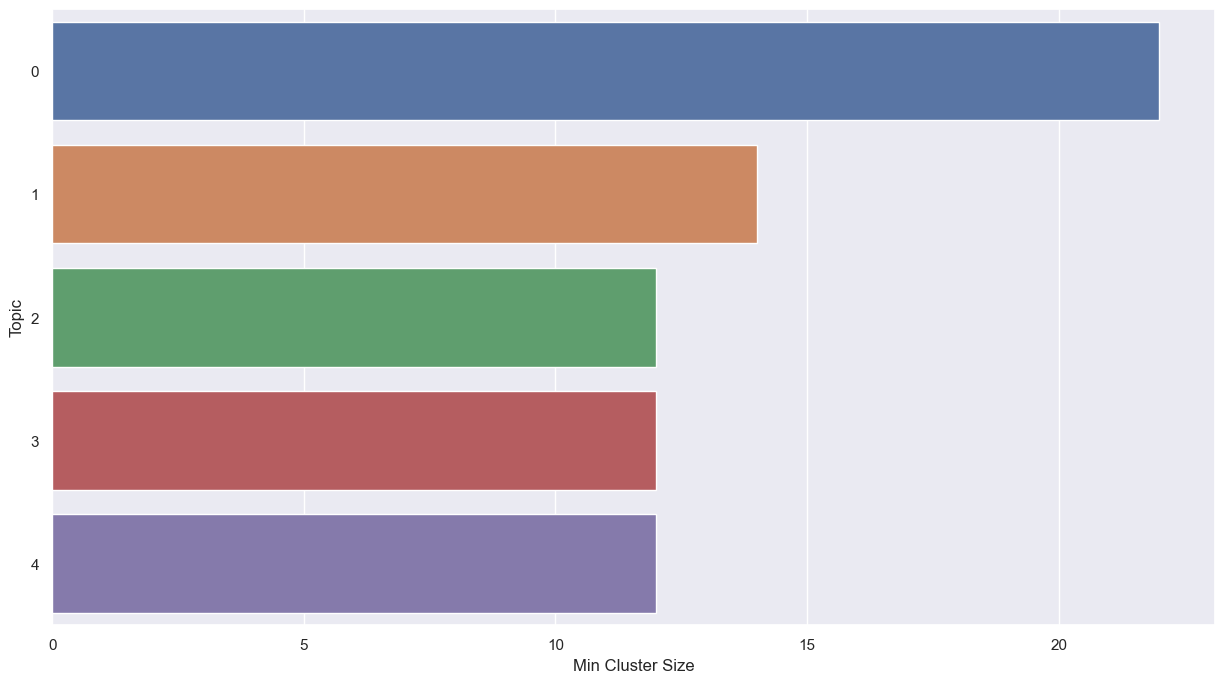

In [49]:
cluster_eval.display_min_cluster_size_all_group()

In [50]:
cluster_eval.print_min_cluster_sizes_all_group()

****************************************************************************************************
****************************************************************************************************
 
----------------------------------------------------------------------------------------------------
Min Cluster Size per Topic:
----------------------------------------------------------------------------------------------------
Topic  Min Cluster Size
    2                12
    3                12
    4                12
    1                14
    0                22


****************************************************************************************************
****************************************************************************************************
 
----------------------------------------------------------------------------------------------------
Percentage Clustered per Topic:
----------------------------------------------------------------------------------------------------


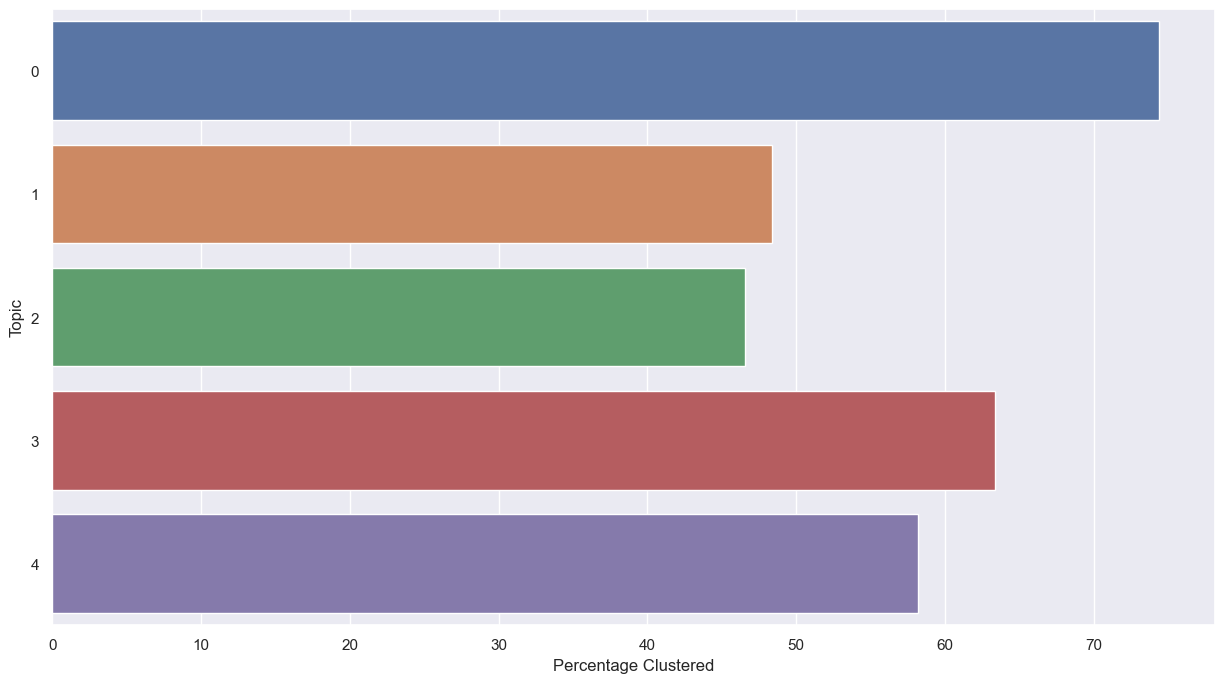

In [51]:
cluster_eval.display_percentage_clustered_all_group()

In [52]:
cluster_eval.print_percentage_clustered_all_group()

****************************************************************************************************
****************************************************************************************************
 
----------------------------------------------------------------------------------------------------
Percentage Clustered per Topic:
----------------------------------------------------------------------------------------------------
Topic  Percentage Clustered
    2             46.558704
    1             48.380567
    4             58.158996
    3             63.319672
    0             74.400000


****************************************************************************************************
****************************************************************************************************
 
----------------------------------------------------------------------------------------------------
Number of Sequences per Cluster for each Topic:
----------------------------------------------------------------------------------------------------
Plots:


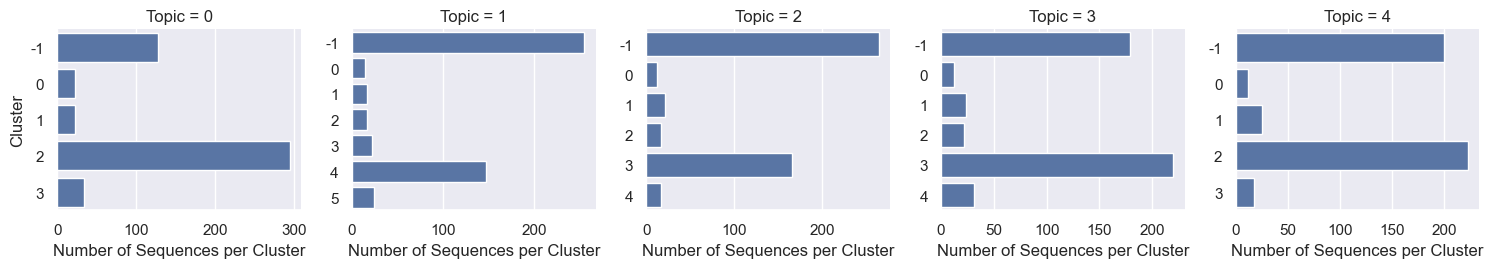

In [53]:
cluster_eval.display_number_sequences_per_cluster_all_group(height=3)

****************************************************************************************************
****************************************************************************************************
 
----------------------------------------------------------------------------------------------------
Number of Unique Sequences per Cluster for each Topic:
----------------------------------------------------------------------------------------------------
Plots:


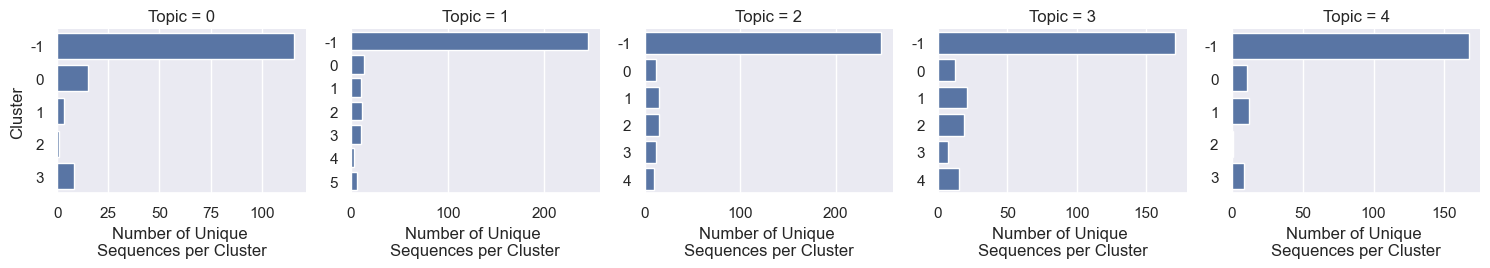

In [54]:
cluster_eval.display_number_unique_sequences_per_cluster_all_group(height=3)

****************************************************************************************************
****************************************************************************************************
 
----------------------------------------------------------------------------------------------------
Number of Unique Sequences vs Number of Sequences per Cluster for each Topic:
----------------------------------------------------------------------------------------------------
Plots:


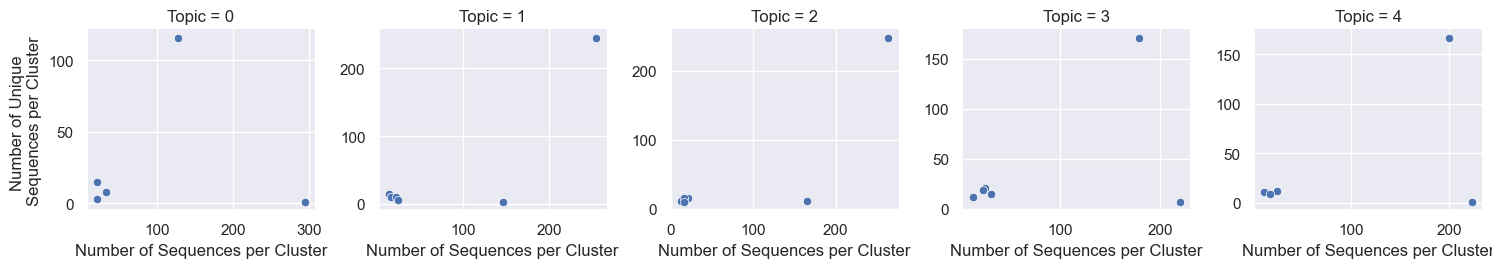

In [55]:
cluster_eval.display_number_unique_sequences_vs_number_sequences_per_cluster_all_group(height=3)

****************************************************************************************************
****************************************************************************************************
 
----------------------------------------------------------------------------------------------------
Central Tendency Differences in Evaluation Metric between Clusters per Topic:
Chosen Evaluation Metric: "Topic Highest Score All Learning Resources Mean"
----------------------------------------------------------------------------------------------------


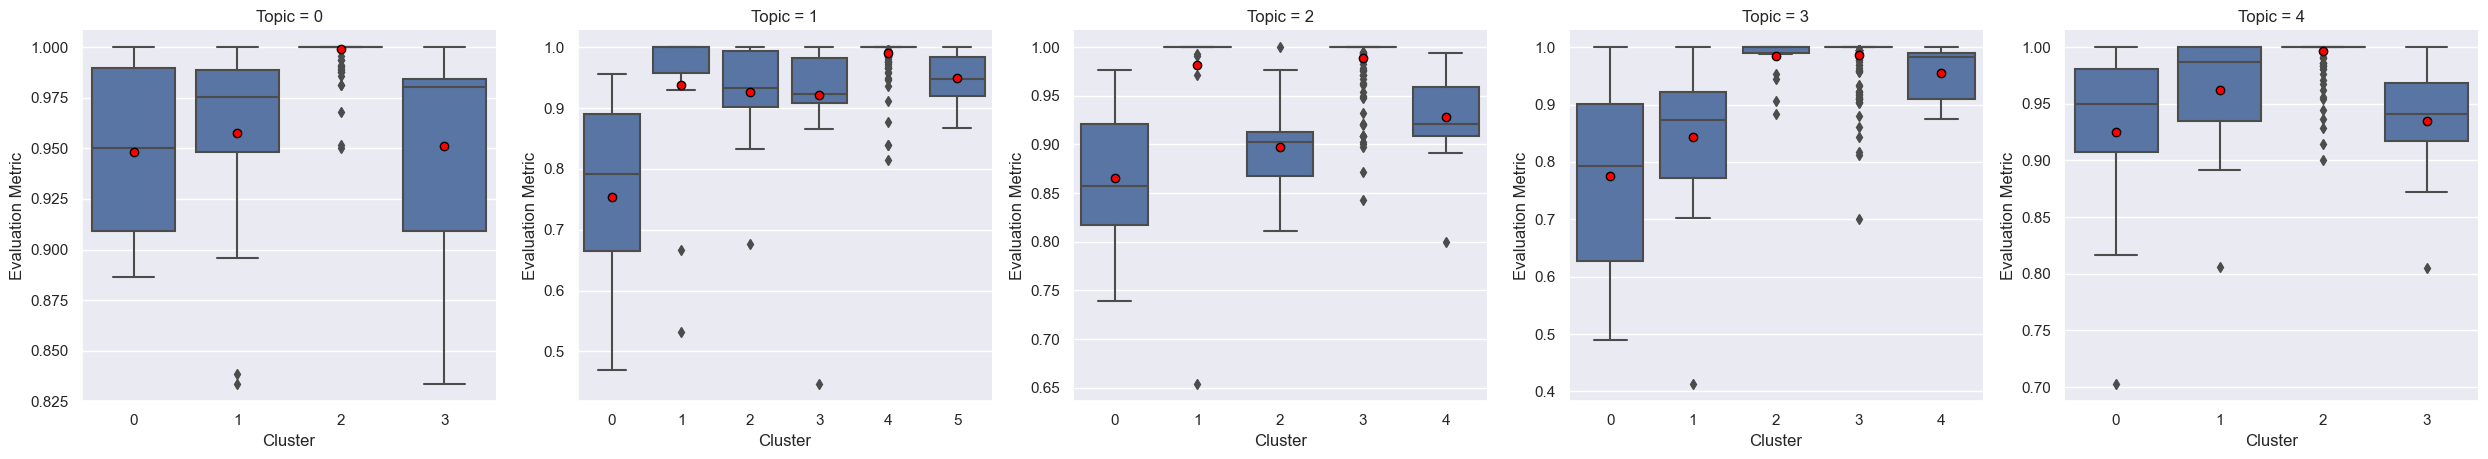

In [56]:
cluster_eval.display_eval_metric_dist_between_cluster_all_groups(height=5)

****************************************************************************************************
****************************************************************************************************
 
----------------------------------------------------------------------------------------------------
Clusters per Topic
Dimensionality Reducer: UMAP
----------------------------------------------------------------------------------------------------


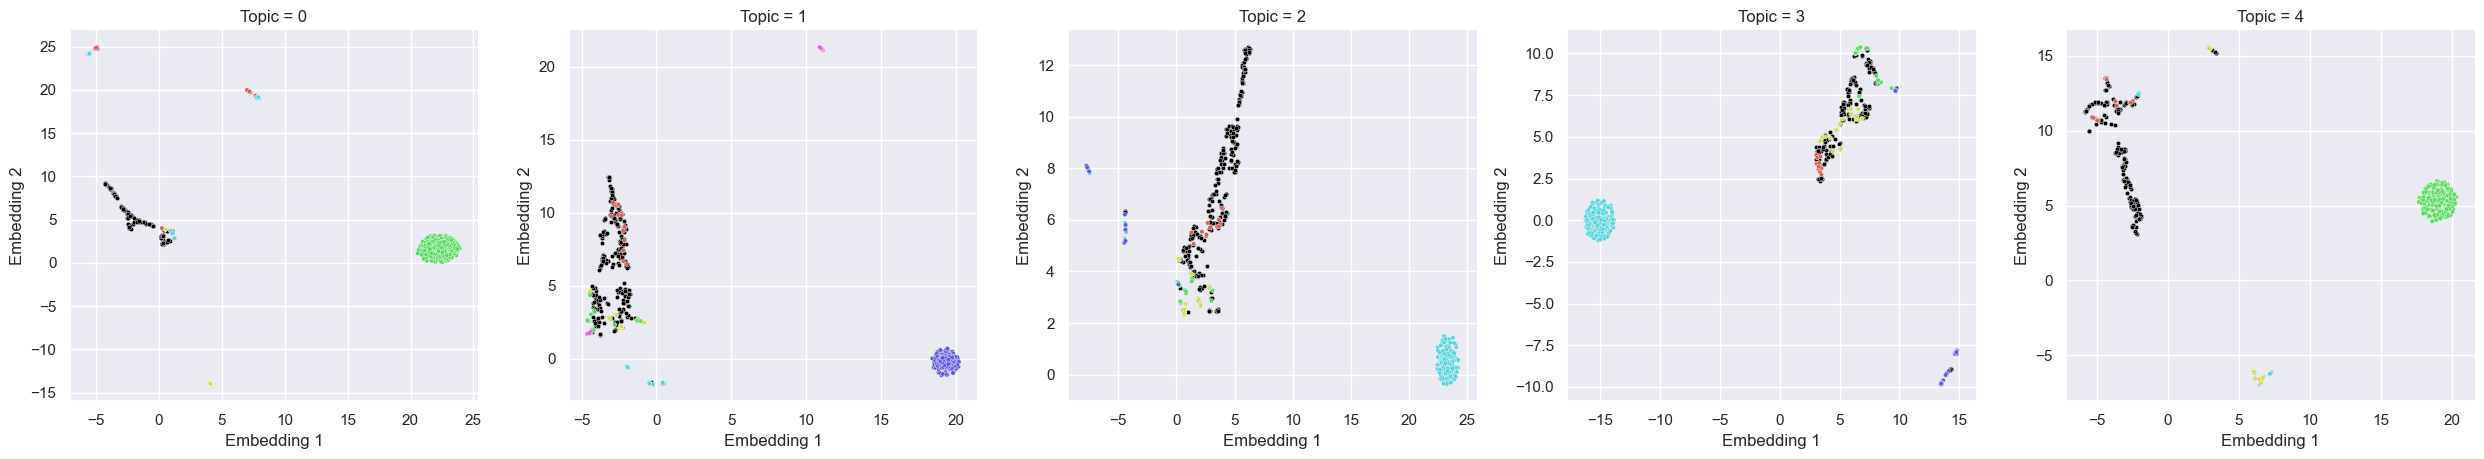

In [57]:
cluster_eval.display_clusters_all_group_umap(height=5)